 “We pledge on our honor
that we have neither received nor given unauthorized assistance on this deliverable.”

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline


In [108]:

def get_meteo_weather_history(lat, lon, start_date, end_date):

    # API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "America/Los_Angeles"
    }

    # Make the request
    response = requests.get(url, params=params)
    data = response.json()

    # Convert to DataFrame
    weather_df = pd.DataFrame({
        "date": data["daily"]["time"],
        "temp_max": data["daily"]["temperature_2m_max"],
        "temp_min": data["daily"]["temperature_2m_min"],
        "precipitation": data["daily"]["precipitation_sum"]
    })

    # Convert date to datetime object
    weather_df["date"] = pd.to_datetime(weather_df["date"])


    return weather_df


Get the weather for Fort Mason Equator Coffe (don't do this over and over - this uses a free open source api which asks its users to respect the usage)
Save it to a CSV
Turns out we only need to do Fort Mason as the other two coffee shops are close by

In [109]:
# Date range (based on your dataset)
start_date = "2019-01-01"
end_date = "2024-12-31"

# Fort Mason - Equator Coffee lat lon
fortMasonLatitude = 37.805424841127625
fortMasonLongitude = -122.43189815767089
# only run this if we lose our data and need to pull it again (uses a free api)
if (False):
    weather_df = get_meteo_weather_history(fortMasonLatitude, fortMasonLongitude, start_date, end_date)
    # Save to CSV
    weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv", index=False)
else:
    #weather_df = pd.read_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\san_fran_open_meteo_weather.csv")
    weatherURL = "https://www.dropbox.com/scl/fi/khb765ddg0qox6iy8qtkb/sanfran_weather.csv?rlkey=yccip6qd8kcx0jqz80jocddqf&dl=1"
    weather_data = pd.read_csv(weatherURL)


# Preview
print(weather_data.head())


# # Lake Merrit - Equator Coffee lat lon  - DON'T BOTHER - LAT LON IS NEARLY THE SAME AS FORT MASON
# lakeMerritLatitude = 37.81242756270673
# lakeMerritongitude = -122.26105919815194
# weather_df = get_meteo_weather_history(lakeMerritLatitude, lakeMerritongitude, start_date, end_date)
# # Save to CSV
# weather_df.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\lake_merrit_open_meteo_weather.csv", index=False)


         date  temp_max  temp_min  precipitation
0  2019-01-01      12.1       4.2            0.0
1  2019-01-02      11.6       4.5            0.0
2  2019-01-03      10.9       4.6            0.0
3  2019-01-04      12.0       4.9            0.0
4  2019-01-05      12.7       9.4            5.8


Clean the Data - Remove specific days like Christmas, New Years, etc.

In [110]:
# List of holidays to remove
holidays = [
    '2019-01-01', '2019-12-25', '2020-01-01', '2020-12-25', 
    '2021-01-01', '2021-12-25', '2022-01-01', '2022-12-25', 
    '2023-01-01', '2023-12-25', '2024-01-01', '2024-12-25'
]

covid_lockdown = ['2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
                  '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22',
                  '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
                  '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
                  '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03',
                  '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07',
                  '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11',
                  '2020-04-12', '2020-04-13']

holidays += covid_lockdown   

# Convert holidays to datetime
holidays = pd.to_datetime(holidays)

# # Add 2020-03-15':'2020-04-13 (COVID-19 lockdown period)
# holidays += pd.date_range(start='2020-03-15', end='2020-04-13').strftime('%Y-%m-%d').tolist()

# # change the date column name from 'date' to 'DOB'
# weather_data.rename(columns={'date': 'date'}, inplace=True)

# Remove holidays from weather data
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data[~weather_data['date'].isin(holidays)]

print("\nCleaned Weather Data:")
print(weather_data.head())


Cleaned Weather Data:
        date  temp_max  temp_min  precipitation
1 2019-01-02      11.6       4.5            0.0
2 2019-01-03      10.9       4.6            0.0
3 2019-01-04      12.0       4.9            0.0
4 2019-01-05      12.7       9.4            5.8
5 2019-01-06      13.4       8.5           36.5


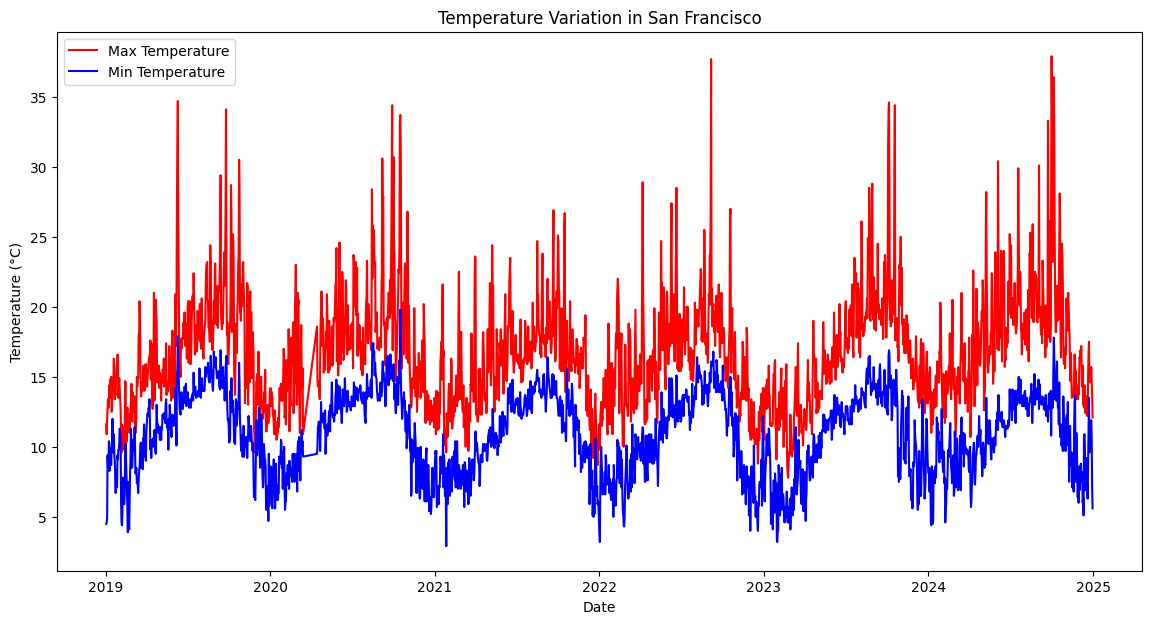

In [111]:
# Graph the weather data
plt.figure(figsize=(14, 7)) 
plt.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red')
plt.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation in San Francisco')
plt.legend()
plt.show()


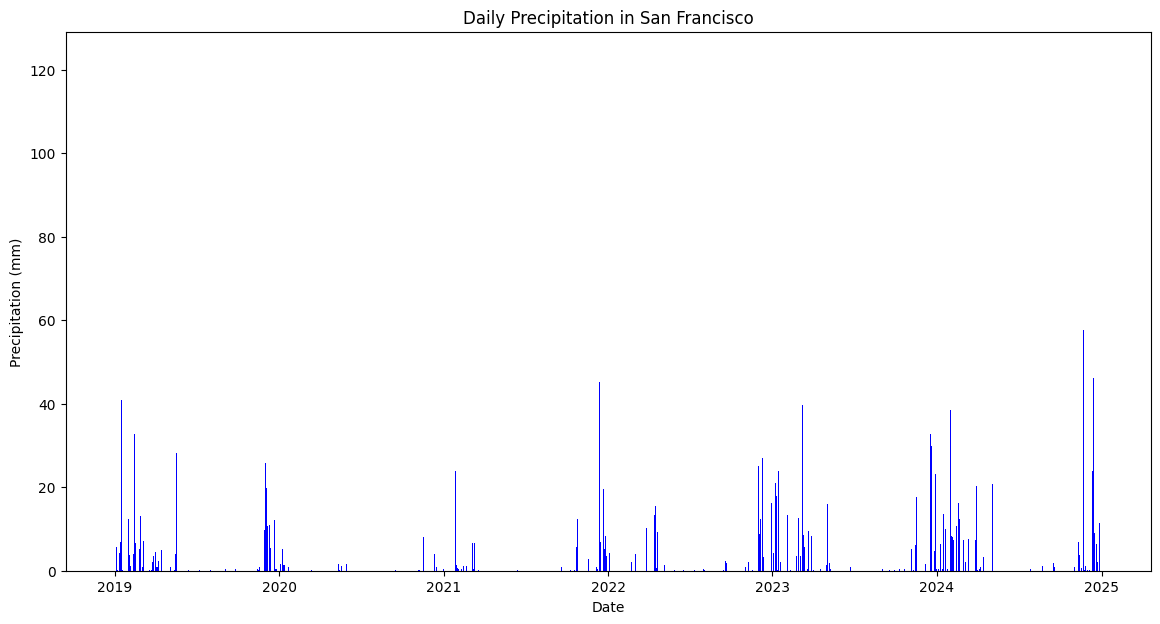

In [112]:
plt.figure(figsize=(14, 7))
plt.bar(weather_data['date'], weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco')
plt.show()

In [113]:
# Find the day with the highest precipitation
max_precipitation_day = weather_data.loc[weather_data['precipitation'].idxmax()]

print("Day with the highest precipitation:")
print(max_precipitation_day)

# How many days have precipitation greater than 50mm?
high_precipitation_days = weather_data[weather_data['precipitation'] > 50]
print("\nNumber of days with precipitation greater than 50mm:")
print(len(high_precipitation_days))


Day with the highest precipitation:
date             2022-12-31 00:00:00
temp_max                        13.2
temp_min                        10.5
precipitation                  123.0
Name: 1460, dtype: object

Number of days with precipitation greater than 50mm:
4


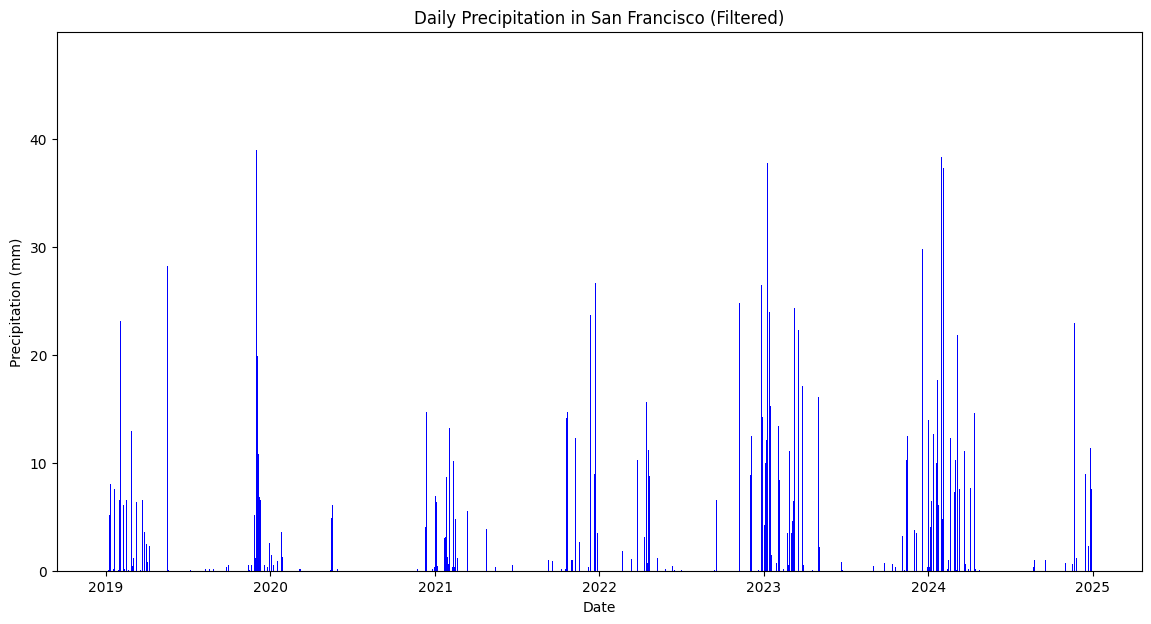

In [114]:
# Filter out days with precipitation greater than 50mm
filtered_weather_data = weather_data[weather_data['precipitation'] <= 50]

# Plot the daily precipitation
plt.figure(figsize=(14, 7))
plt.bar(filtered_weather_data['date'], filtered_weather_data['precipitation'], color='blue')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Daily Precipitation in San Francisco (Filtered)')
plt.show()

Next let's get our sales data for the 3 stores

Start with Fort Mason

In [115]:
fortMason5ySalesURL = "https://www.dropbox.com/scl/fi/c73v6ce9ij7rupc74quyz/FortMason5yrNetSalesbyDay.csv?rlkey=lnt0t56erqvea18fh052komur&dl=1"
fortMason5y_data = pd.read_csv(fortMason5ySalesURL)

# Preview
print(fortMason5y_data.head())



   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
1            6    Fort Mason  1/1/2019     Tuesday             FOOD   
2            6    Fort Mason  1/1/2019     Tuesday             FOOD   
3            6    Fort Mason  1/1/2019     Tuesday  COFFEE & NA BEV   
4            6    Fort Mason  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1908.65        17.75             0  
1      Baked Goods-Pantry   199.75         0.00             0  
2  Retail Packaged-Pantry   178.00         0.00             0  
3         Other Beverages   163.50         0.00             0  
4           Retail Coffee   119.50         0.00             0  


Clean the Data

In [116]:
# Remove System Balance from the data
fortMason5y_data = fortMason5y_data[fortMason5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
fortMason5y_data = fortMason5y_data.drop(columns=['PROMO AMOUNT'])
print('Data length:', len(fortMason5y_data))

# change the DOB column name from 'DOB' to 'date'
fortMason5y_data.rename(columns={'DOB': 'date'}, inplace=True)

# Remove the holidays from the fortMason5y_data
fortMason5y_data['date'] = pd.to_datetime(fortMason5y_data['date'])
fortMason5y_data = fortMason5y_data[~fortMason5y_data['date'].isin(holidays)]
print('Holidays and COVID removed data length:', len(fortMason5y_data))

# Preview
print(fortMason5y_data.head())


Data length: 19850
Holidays and COVID removed data length: 19743
    LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
12            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
13            6    Fort Mason 2019-01-02   Wednesday             FOOD   
14            6    Fort Mason 2019-01-02   Wednesday             FOOD   
15            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
16            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                           SD   AMOUNT  COMP AMOUNT  
12       Retail Coffee Drinks  1191.81        10.59  
13         Baked Goods-Pantry   209.00         0.00  
14  Retail Packaged-3rd party   196.26         2.24  
15                Accessories   196.00         5.00  
16              Retail Coffee   158.00         0.00  


More cleaning - Making an assumption that the store is closed if it has 0 regular coffee sales

In [117]:
# Print total entries
print("\nTotal entries:", len(fortMason5y_data))

# Append the dates where there are less than 4 date entries (i.e. less than 4 sales on that day) to the holidays
#holidays = holidays.append(pd.to_datetime(fortMason5y_data.groupby('date').filter(lambda x: len(x) < 4)['date'].unique()))


# store all the dates where there are less than 4 date entries (i.e. less than 4 sales on that day)
combinedDatesToRemove = pd.to_datetime(fortMason5y_data.groupby('date').filter(lambda x: len(x) < 4)['date'].unique())
print("Combined Dates to Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Remove entries where there are less than 4 DOB entries (i.e. less than 4 sales on that day) 
fortMason5y_data = fortMason5y_data.groupby('date').filter(lambda x: len(x) > 3) 

# Print total entries
print("\nTotal entries:", len(fortMason5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
fortMason5y_coffee_data = fortMason5y_data[fortMason5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(fortMason5y_coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = fortMason5y_coffee_data[fortMason5y_coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))



Total entries: 19743
Combined Dates to Remove: 3
<DatetimeArray>
['2023-07-31 00:00:00', '2023-08-01 00:00:00', '2023-08-02 00:00:00']
Length: 3, dtype: datetime64[ns]

Total entries: 19737
     LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
12             6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
24             6    Fort Mason 2019-01-03    Thursday  COFFEE & NA BEV   
36             6    Fort Mason 2019-01-04      Friday  COFFEE & NA BEV   
47             6    Fort Mason 2019-01-05    Saturday  COFFEE & NA BEV   
58             6    Fort Mason 2019-01-06      Sunday  COFFEE & NA BEV   
70             6    Fort Mason 2019-01-07      Monday  COFFEE & NA BEV   
83             6    Fort Mason 2019-01-08     Tuesday  COFFEE & NA BEV   
95             6    Fort Mason 2019-01-09   Wednesday  COFFEE & NA BEV   
104            6    Fort Mason 2019-01-10    Thursday  COFFEE & NA BEV   
116            6    Fort Mason 2019-01-11      Friday  COFFEE & NA BE

SD
Accessories               123841.21
BLANK NAME                  4702.66
Baked Goods-3rd party    1165341.86
Baked Goods-Pantry         89642.73
Beer & Wine                23503.57
Brewing Equipment           4288.32
Catering                   35237.85
Donation                      30.00
Extra Items                   58.95
Ice Cream                   4348.45
Name: AMOUNT, dtype: float64
SD
Accessories                  1.238412e+05
BLANK NAME                   4.702660e+03
Baked Goods-3rd party        1.165342e+06
Baked Goods-Pantry           8.964273e+04
Beer & Wine                  2.350357e+04
Brewing Equipment            4.288320e+03
Catering                     3.523785e+04
Donation                     3.000000e+01
Extra Items                  5.895000e+01
Ice Cream                    4.348450e+03
Other Beverages              1.933254e+05
Prepared Foods               6.159979e+05
Retail Coffee                5.964941e+05
Retail Coffee Drinks         5.048343e+06
Retail Packaged-3

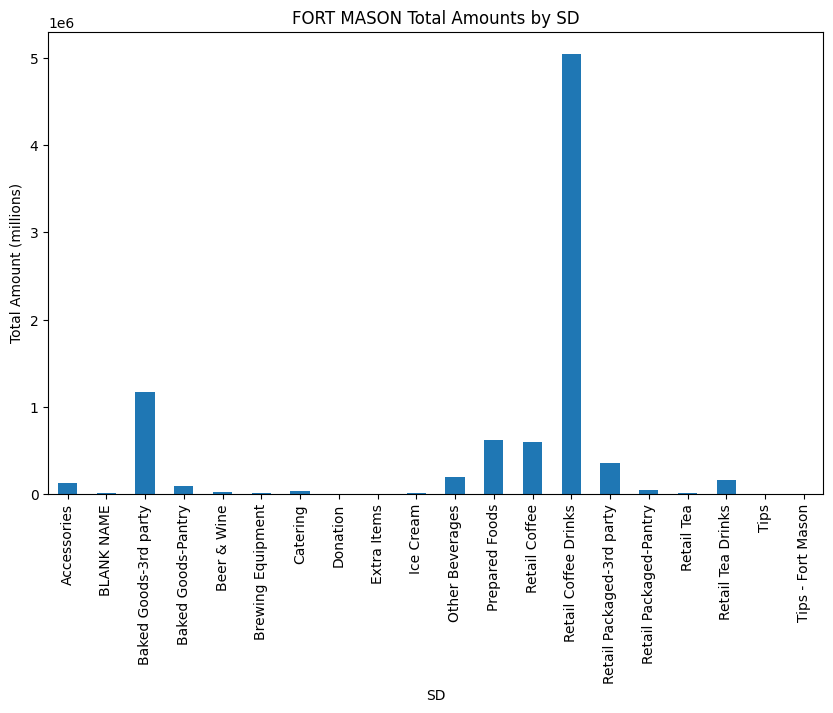

In [118]:

# Group the data by 'SD' and sum the 'AMOUNT'
fm_grouped_data = fortMason5y_data.groupby('SD')['AMOUNT'].sum()
print(fm_grouped_data.head(10))
print(fm_grouped_data)

# # Remove System Balance from the data
# fm_grouped_data = fm_grouped_data.drop('System Balance')

# Plot the data
plt.figure(figsize=(10, 6))
fm_grouped_data.plot(kind='bar')
plt.title('FORT MASON Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount (millions)')
plt.show()

In [119]:
blank_name_indices = fortMason5y_data[fortMason5y_data['SD'] == 'BLANK NAME'].index
print(blank_name_indices)

Index([ 4895,  4907,  4920,  4935,  4945,  4958,  4970,  4982,  4993,  5007,
        5030,  5038,  5052,  5390,  5398,  5405,  5410,  5435,  5440,  5448,
        5456,  5471,  5481,  5492,  5500,  5508,  5514,  6226,  6236,  6247,
        6254,  6264,  6553,  6631,  6669,  6680, 13514, 13721, 13911, 14025,
       14065, 14171, 15003, 15012, 15022, 15031, 15048, 15073, 15082, 15107,
       15117, 15128, 15496, 16007],
      dtype='int64')


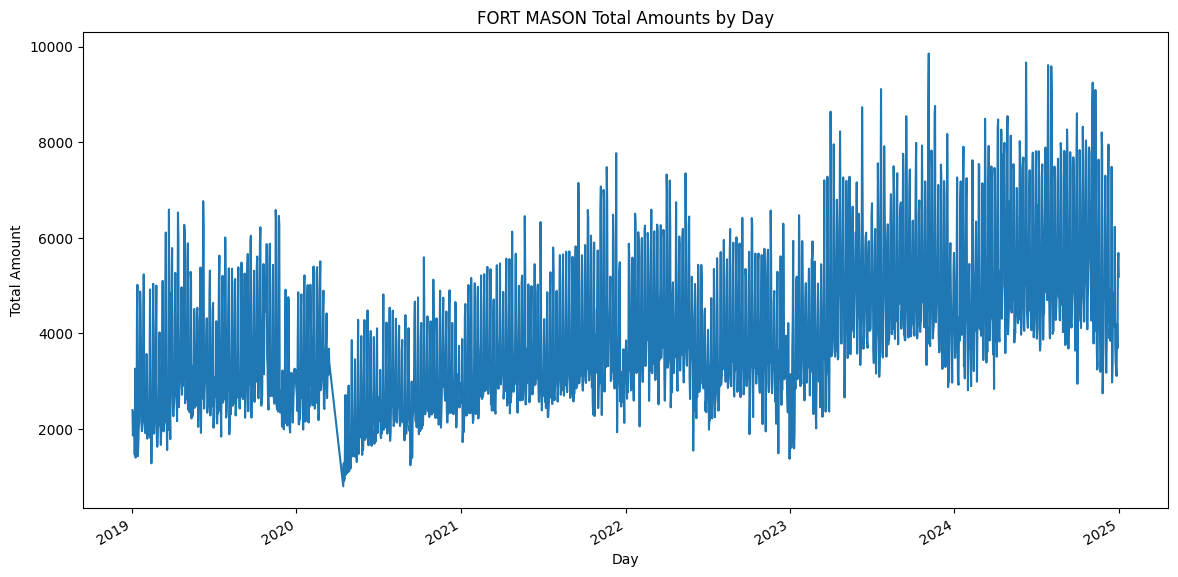

In [120]:
# Group the data by 'date' and sum the 'AMOUNT'
fm_daily_totals = fortMason5y_data.groupby('date')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
fm_daily_totals.plot(kind='line')
plt.title('FORT MASON Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()

In [121]:
# Find the days with zero sales (or very low sales) - see if they are Christmas, New Year's Day, etc. - but maybe it's too much rain or too hot!?
sales_anomolies_max = 250

unusually_low_sales_days = fm_daily_totals[fm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)


Now do Lake Merritt

In [122]:
lakeMerritt5ySalesURL = "https://www.dropbox.com/scl/fi/zcfrcc3mlhuapy2bqbyhc/LakeMerritt5yrNetSalesbyDay.csv?rlkey=7b0vk7k3frcwkoxg281tx4mpu&dl=1"
lakeMerritt5y_data = pd.read_csv(lakeMerritt5ySalesURL)

# Preview
print(lakeMerritt5y_data.head())


   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            7  Lake Merritt  1/1/2019     Tuesday  COFFEE & NA BEV   
1            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
2            7  Lake Merritt  1/1/2019     Tuesday           RETAIL   
3            7  Lake Merritt  1/1/2019     Tuesday             FOOD   
4            7  Lake Merritt  1/1/2019     Tuesday             FOOD   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1141.88         0.22             0  
1      Baked Goods-Pantry   125.50         0.00             0  
2           Retail Coffee   108.00         0.00             0  
3          Prepared Foods    72.00         0.00             0  
4  Retail Packaged-Pantry    51.50         0.00             0  


Clean the data

In [123]:
# Remove System Balance from the data
lakeMerritt5y_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
lakeMerritt5y_data = lakeMerritt5y_data.drop(columns=['PROMO AMOUNT'])

# change the DOB column name from 'DOB' to 'date'
lakeMerritt5y_data.rename(columns={'DOB': 'date'}, inplace=True)

# Remove the holidays from the data
lakeMerritt5y_data['date'] = pd.to_datetime(lakeMerritt5y_data['date'])
lakeMerritt5y_data = lakeMerritt5y_data[~lakeMerritt5y_data['date'].isin(holidays)]

# Preview
print(lakeMerritt5y_data.head())

    LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
9             7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   
10            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
11            7  Lake Merritt 2019-01-02   Wednesday           RETAIL   
12            7  Lake Merritt 2019-01-02   Wednesday             FOOD   
13            7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   

                        SD  AMOUNT  COMP AMOUNT  
9     Retail Coffee Drinks  602.68         2.52  
10      Baked Goods-Pantry  104.50         0.00  
11           Retail Coffee   47.45         0.00  
12  Retail Packaged-Pantry   44.00         0.00  
13       Retail Tea Drinks   21.00         0.00  


More cleaning - get rid of days with what appears to be only private sales

In [124]:
# Print total entries
print("\nTotal entries:", len(lakeMerritt5y_data))

# store all the dates where there are less than 4 date entries (i.e. less than 4 sales on that day)
datesToRemove = pd.to_datetime(lakeMerritt5y_data.groupby('date').filter(lambda x: len(x) < 4)['date'].unique())
print(datesToRemove)

# add the dates to the combinedDatesToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, datesToRemove])
print("Combined Dates To Remove entries:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Remove entries where there are less than 4 date entries (i.e. less than 4 sales on that day)
lakeMerritt5y_data = lakeMerritt5y_data.groupby('date').filter(lambda x: len(x) > 3)
# Print total entries
print("\nTotal entries:", len(lakeMerritt5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
coffee_data = lakeMerritt5y_data[lakeMerritt5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = coffee_data[coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))


Total entries: 16435
<DatetimeArray>
['2023-12-13 00:00:00']
Length: 1, dtype: datetime64[ns]
Combined Dates To Remove entries: 4
['2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2023-12-13T00:00:00.000000000']

Total entries: 16433
    LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
9             7  Lake Merritt 2019-01-02   Wednesday  COFFEE & NA BEV   
18            7  Lake Merritt 2019-01-03    Thursday  COFFEE & NA BEV   
26            7  Lake Merritt 2019-01-04      Friday  COFFEE & NA BEV   
36            7  Lake Merritt 2019-01-05    Saturday  COFFEE & NA BEV   
45            7  Lake Merritt 2019-01-06      Sunday  COFFEE & NA BEV   
51            7  Lake Merritt 2019-01-07      Monday  COFFEE & NA BEV   
60            7  Lake Merritt 2019-01-08     Tuesday  COFFEE & NA BEV   
68            7  Lake Merritt 2019-01-09   Wednesday  COFFEE & NA BEV   
74            7  Lake Merritt 2019-01-10    Thursday  COFFE

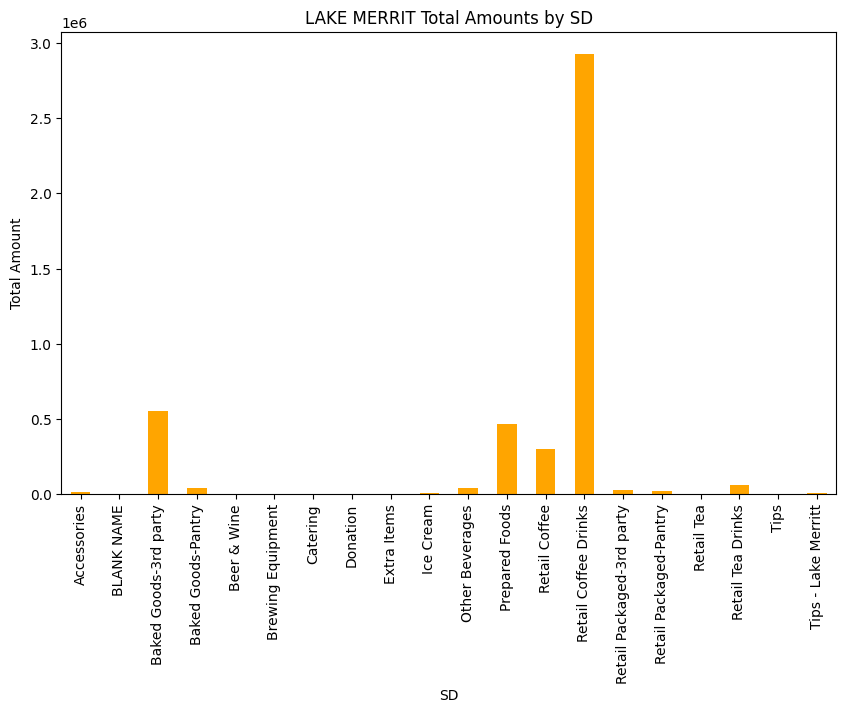

In [125]:
# Group the data by 'SD' and sum the 'AMOUNT'
lm_grouped_data = lakeMerritt5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
lm_grouped_data.plot(kind='bar', color='orange')
plt.title('LAKE MERRIT Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

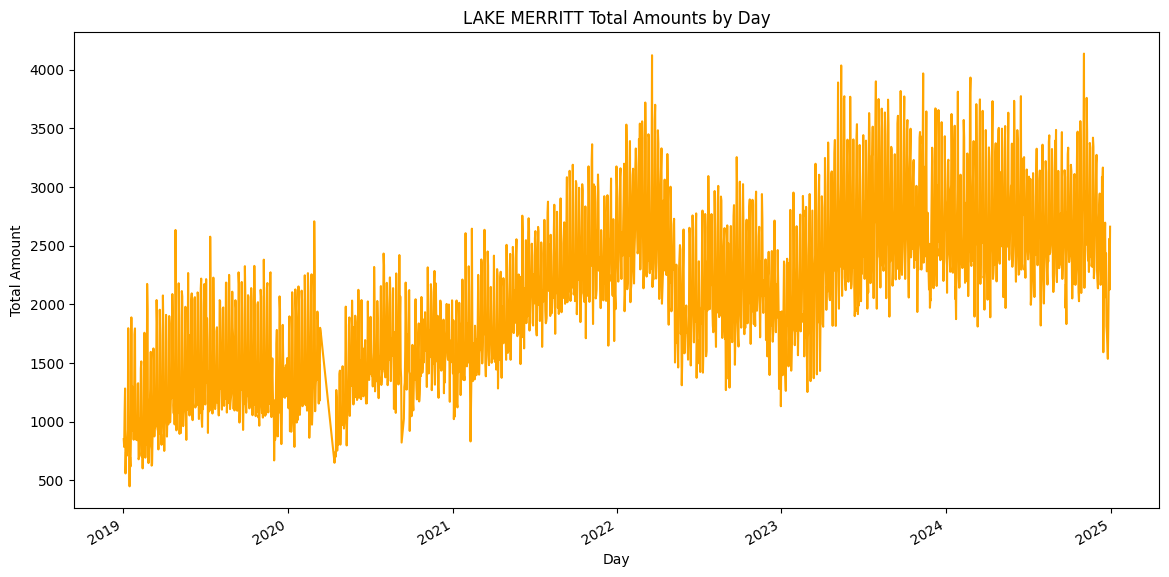

In [126]:
# Group the data by 'date' and sum the 'AMOUNT'
lm_daily_totals = lakeMerritt5y_data.groupby('date')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
lm_daily_totals.plot(kind='line', color='orange')
plt.title('LAKE MERRITT Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [127]:
unusually_low_sales_days = lm_daily_totals[lm_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)


Finally, do Larkspur

In [128]:
larkspur5ySalesURL = "https://www.dropbox.com/scl/fi/n037thzcegug919e0ajqj/Larkspur5yrNetSalesbyDay.csv?rlkey=3pg7sv4fbur1tfo2ax7ebz70z&dl=1"
larkspur5y_data = pd.read_csv(larkspur5ySalesURL)

# Preview
print(larkspur5y_data.head())

   LOCATION ID LOCATION NAME       DOB DAY OF WEEK              MSD  \
0            4      Larkspur  1/1/2019     Tuesday  COFFEE & NA BEV   
1            4      Larkspur  1/1/2019     Tuesday             FOOD   
2            4      Larkspur  1/1/2019     Tuesday             FOOD   
3            4      Larkspur  1/1/2019     Tuesday             FOOD   
4            4      Larkspur  1/1/2019     Tuesday           RETAIL   

                       SD   AMOUNT  COMP AMOUNT  PROMO AMOUNT  
0    Retail Coffee Drinks  1612.96        35.14             0  
1      Baked Goods-Pantry   185.00         0.00             0  
2   Baked Goods-3rd party   175.00         0.00             0  
3  Retail Packaged-Pantry   144.75         0.00             0  
4           Retail Coffee   142.50         0.00             0  


Clean the data

In [129]:
# Remove System Balance from the data
larkspur5y_data = larkspur5y_data[larkspur5y_data['SD'] != 'System Balance']

# Remove PROMO AMOUNT Column from the data 
larkspur5y_data = larkspur5y_data.drop(columns=['PROMO AMOUNT'])

# change the DOB column name from 'DOB' to 'date'
larkspur5y_data.rename(columns={'DOB': 'date'}, inplace=True)

# Remove the holidays from the data
larkspur5y_data['date'] = pd.to_datetime(larkspur5y_data['date'])
larkspur5y_data = larkspur5y_data[~larkspur5y_data['date'].isin(holidays)]


# these days should be removed for anomalies like power outages, etc.
daysToRemove = [
    '2021-10-24', '2024-12-14',
    '2024-02-07', '2024-11-20', '2024-12-15',
    '2023-01-10', '2023-11-28'

]
larkspur5y_data = larkspur5y_data[~larkspur5y_data['date'].isin(daysToRemove)]

daysToRemove = pd.to_datetime(daysToRemove)

# add the dates to the combinedDatesToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, daysToRemove])
print("\nCombined Dates To Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)

# Preview
print(larkspur5y_data.head())


Combined Dates To Remove: 11
['2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2023-12-13T00:00:00.000000000'
 '2021-10-24T00:00:00.000000000' '2024-12-14T00:00:00.000000000'
 '2024-02-07T00:00:00.000000000' '2024-11-20T00:00:00.000000000'
 '2024-12-15T00:00:00.000000000' '2023-01-10T00:00:00.000000000'
 '2023-11-28T00:00:00.000000000']
    LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
14            4      Larkspur 2019-01-02   Wednesday  COFFEE & NA BEV   
15            4      Larkspur 2019-01-02   Wednesday             FOOD   
16            4      Larkspur 2019-01-02   Wednesday             FOOD   
17            4      Larkspur 2019-01-02   Wednesday           RETAIL   
18            4      Larkspur 2019-01-02   Wednesday             FOOD   

                        SD   AMOUNT  COMP AMOUNT  
14    Retail Coffee Drinks  1285.48        23.47  
15      Baked Goods-Pantry   203.00         0.00  
16   Baked Goods-3r

C:\Users\Paul\AppData\Local\Temp\ipykernel_25736\483274361.py:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  larkspur5y_data = larkspur5y_data[~larkspur5y_data['date'].isin(daysToRemove)]


More cleaning - get rid of the days with appear to be private sales only

In [130]:
# Print total entries
print("\nTotal entries:", len(larkspur5y_data))

# store all the dates where there are less than 4 date entries (i.e. less than 4 sales on that day)
datesToRemove = pd.to_datetime(larkspur5y_data.groupby('date').filter(lambda x: len(x) < 4)['date'].unique())
print(datesToRemove)
# add the dates to the daysToRemove list
combinedDatesToRemove = np.concatenate([combinedDatesToRemove, datesToRemove])
print("\nCombined Dates To Remove:", len(combinedDatesToRemove))
print(combinedDatesToRemove)


# Remove entries where there are less than 4 date entries (i.e. less than 4 sales on that day)
larkspur5y_data = larkspur5y_data.groupby('date').filter(lambda x: len(x) > 3)
# Print total entries
print("\nTotal entries:", len(larkspur5y_data))


# Group the data by only where SD = Reatail Coffee Drinks
coffee_data = larkspur5y_data[larkspur5y_data['SD'] == 'Retail Coffee Drinks']
# Preview
print(coffee_data.head(10))

# Show the days where the coffee sales were unusually low
low_coffee_sales_days = coffee_data[coffee_data['AMOUNT'] < 100]
print("\nDays with unusually low coffee sales (empty here is good!):")
print(low_coffee_sales_days.head(10))


Total entries: 18795
<DatetimeArray>
['2020-04-15 00:00:00', '2023-11-27 00:00:00', '2024-02-05 00:00:00']
Length: 3, dtype: datetime64[ns]

Combined Dates To Remove: 14
['2023-07-31T00:00:00.000000000' '2023-08-01T00:00:00.000000000'
 '2023-08-02T00:00:00.000000000' '2023-12-13T00:00:00.000000000'
 '2021-10-24T00:00:00.000000000' '2024-12-14T00:00:00.000000000'
 '2024-02-07T00:00:00.000000000' '2024-11-20T00:00:00.000000000'
 '2024-12-15T00:00:00.000000000' '2023-01-10T00:00:00.000000000'
 '2023-11-28T00:00:00.000000000' '2020-04-15T00:00:00.000000000'
 '2023-11-27T00:00:00.000000000' '2024-02-05T00:00:00.000000000']

Total entries: 18790
     LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
14             4      Larkspur 2019-01-02   Wednesday  COFFEE & NA BEV   
24             4      Larkspur 2019-01-03    Thursday  COFFEE & NA BEV   
34             4      Larkspur 2019-01-04      Friday  COFFEE & NA BEV   
44             4      Larkspur 2019-01-05    Saturday  

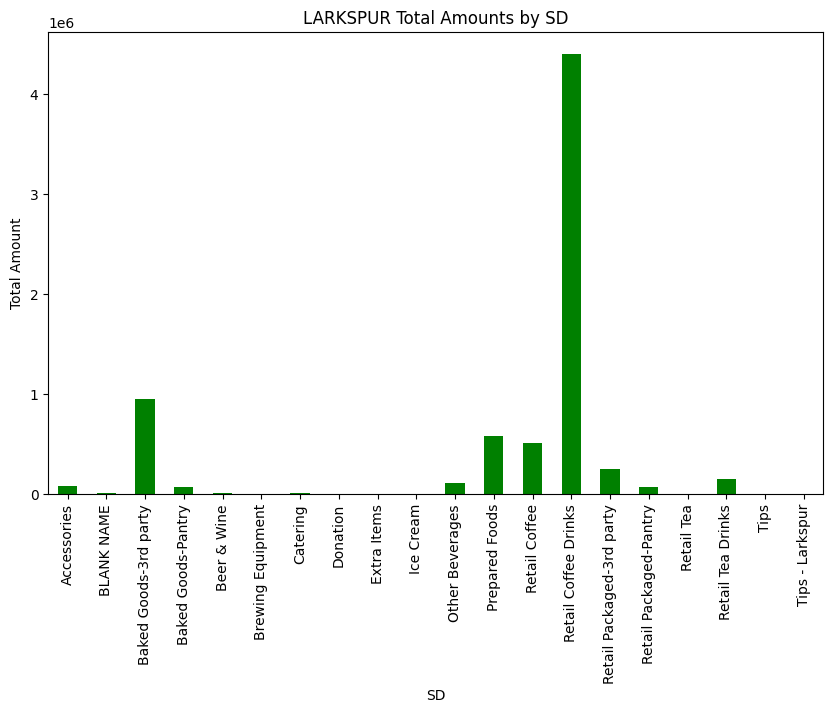

In [131]:
# Group the data by 'SD' and sum the 'AMOUNT'
ls_grouped_data = larkspur5y_data.groupby('SD')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(10, 6))
ls_grouped_data.plot(kind='bar', color='green')
plt.title('LARKSPUR Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount')
plt.show()

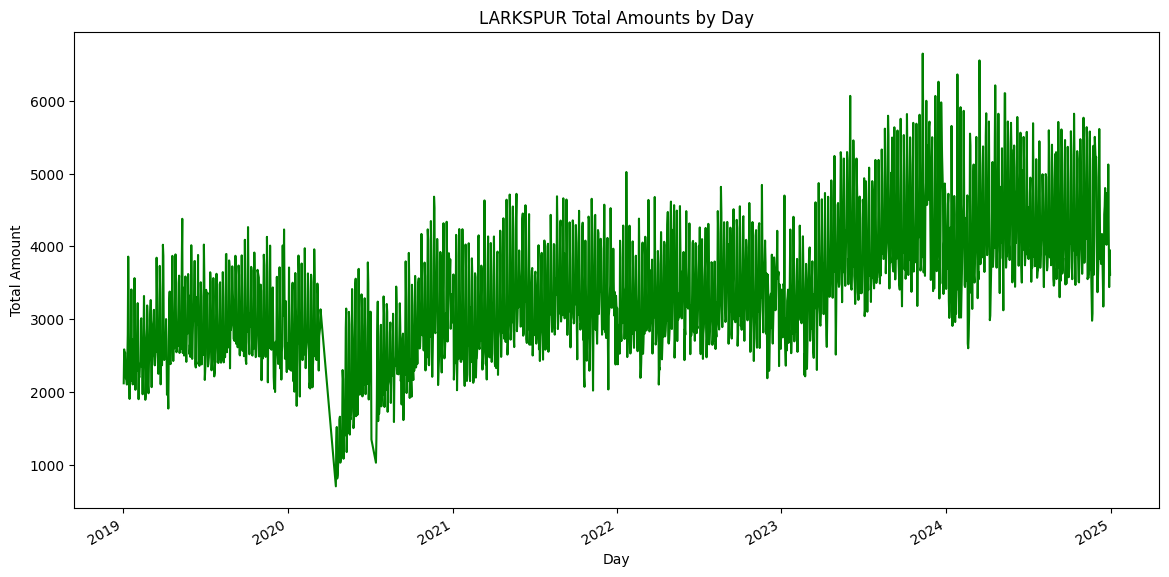

In [132]:
# # Convert 'date' to datetime
# larkspur5y_data['date'] = pd.to_datetime(larkspur5y_data['date'])

# Group the data by 'date' and sum the 'AMOUNT'
ls_daily_totals = larkspur5y_data.groupby('date')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
ls_daily_totals.plot(kind='line', color='green')
plt.title('LARKSPUR Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [133]:
unusually_low_sales_days = ls_daily_totals[ls_daily_totals < sales_anomolies_max]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

low_sales_days = ls_daily_totals[ls_daily_totals < 2500]
print('low_sales_days')
print(low_sales_days)

unusually_low_sales_days
Series([], Name: AMOUNT, dtype: float64)
low_sales_days
date
2019-01-02    2119.01
2019-01-04    2442.86
2019-01-06    2250.35
2019-01-07    2181.96
2019-01-08    2169.26
               ...   
2023-02-21    2233.50
2023-02-23    2215.00
2023-02-27    2317.93
2023-03-14    2468.40
2023-03-21    2302.38
Name: AMOUNT, Length: 320, dtype: float64


Merge the sales date for all 3 stores into one graph

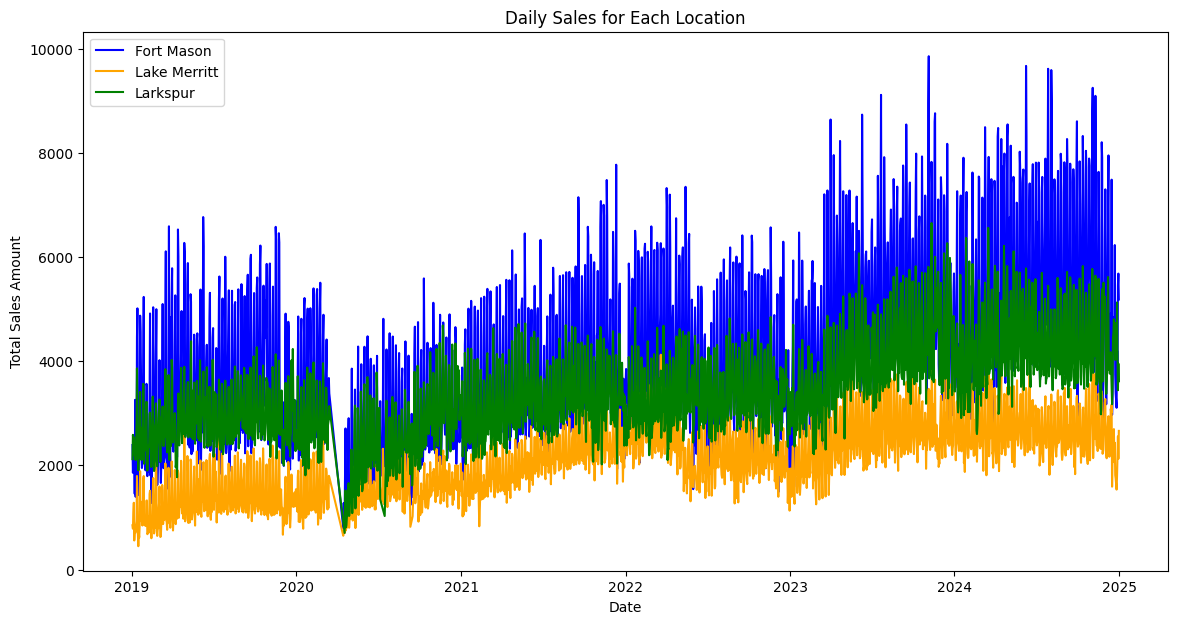

In [134]:
# Plot the daily sales for each location in one graph
plt.figure(figsize=(14, 7))

# Plot Fort Mason daily sales
plt.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason', color='blue')

# Plot Lake Merritt daily sales
plt.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt', color='orange')

# Plot Larkspur daily sales
plt.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur', color='green')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.title('Daily Sales for Each Location')
plt.legend()

# Show the plot
plt.show()

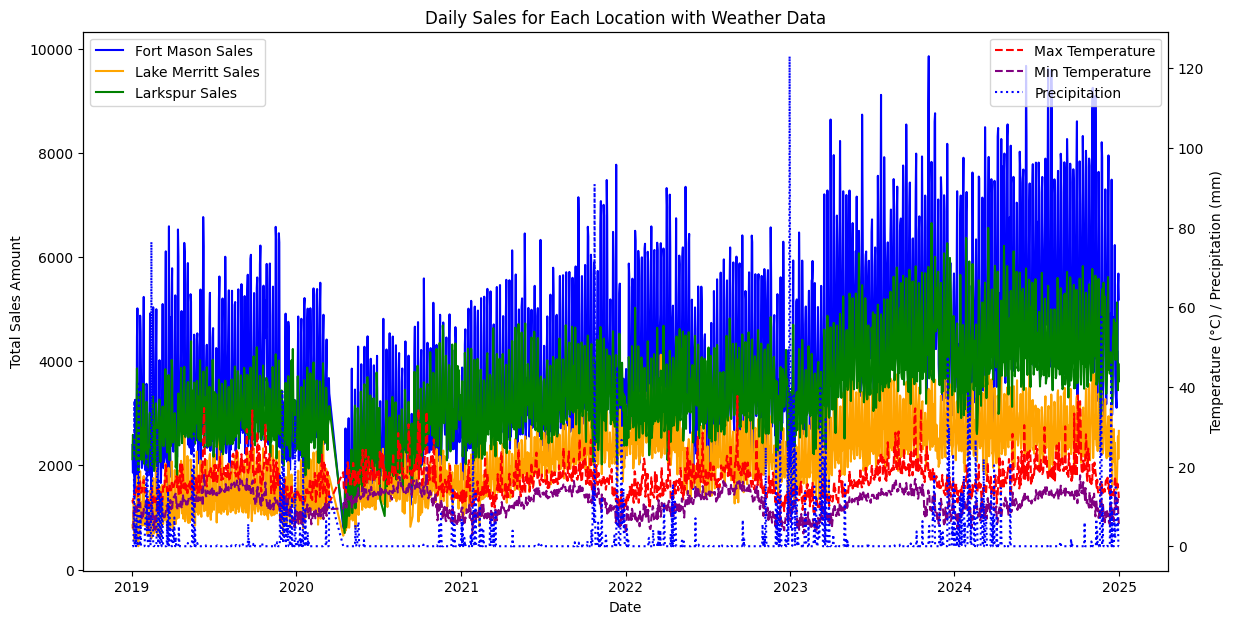

In [135]:
# Plot the daily sales for each location in one graph
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Fort Mason daily sales
ax1.plot(fm_daily_totals.index, fm_daily_totals.values, label='Fort Mason Sales', color='blue')

# Plot Lake Merritt daily sales
ax1.plot(lm_daily_totals.index, lm_daily_totals.values, label='Lake Merritt Sales', color='orange')

# Plot Larkspur daily sales
ax1.plot(ls_daily_totals.index, ls_daily_totals.values, label='Larkspur Sales', color='green')

# Add labels and title for sales
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount')
ax1.set_title('Daily Sales for Each Location with Weather Data')
ax1.legend(loc='upper left')

# Create a secondary y-axis for weather data
ax2 = ax1.twinx()

# Plot Max Temperature
ax2.plot(weather_data['date'], weather_data['temp_max'], label='Max Temperature', color='red', linestyle='--')

# Plot Min Temperature
ax2.plot(weather_data['date'], weather_data['temp_min'], label='Min Temperature', color='purple', linestyle='--')

# Plot Precipitation
ax2.plot(weather_data['date'], weather_data['precipitation'], label='Precipitation', color='blue', linestyle=':')

# Add labels for weather data
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [136]:
# Combine the sales data from all three locations
combined_sales_data = pd.concat([fortMason5y_data, lakeMerritt5y_data, larkspur5y_data])

# Reset the index
combined_sales_data.reset_index(drop=True, inplace=True)

print("Combined Sales Data Length:", len(combined_sales_data))

# Remove the combined dates to remove fomr the combined sales data
combined_sales_data['date'] = pd.to_datetime(combined_sales_data['date'])
combined_sales_data = combined_sales_data[~combined_sales_data['date'].isin(combinedDatesToRemove)]
print("Combined Sales Data Lengt After Dates Cleaned!:", len(combined_sales_data))

# Check for sales data for ALL 3 STORES
# Remove entries where there are less than 12 date entries (i.e. less than 4 sales on that day for each store)
combined_sales_data = combined_sales_data.groupby('date').filter(lambda x: len(x) > 11)
# Print total entries
print("\nTotal entries:", len(combined_sales_data))


# Preview the combined data
print(combined_sales_data.head())
print(combined_sales_data.tail())

Combined Sales Data Length: 54960
Combined Sales Data Lengt After Dates Cleaned!: 54749

Total entries: 54738
   LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
0            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
1            6    Fort Mason 2019-01-02   Wednesday             FOOD   
2            6    Fort Mason 2019-01-02   Wednesday             FOOD   
3            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
4            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                          SD   AMOUNT  COMP AMOUNT  
0       Retail Coffee Drinks  1191.81        10.59  
1         Baked Goods-Pantry   209.00         0.00  
2  Retail Packaged-3rd party   196.26         2.24  
3                Accessories   196.00         5.00  
4              Retail Coffee   158.00         0.00  
       LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
54955            4      Larkspur 2024-12-31     Tuesday        

SD
Accessories               211215.83
BLANK NAME                 10786.52
Baked Goods-3rd party    2653836.20
Baked Goods-Pantry        199525.33
Beer & Wine                38198.19
Brewing Equipment           9383.58
Catering                   43656.74
Donation                      51.92
Extra Items                  122.20
Ice Cream                   9536.95
Name: AMOUNT, dtype: float64
SD
Retail Coffee                1.400063e+06
Retail Coffee Drinks         1.232621e+07
Retail Packaged-3rd party    6.288048e+05
Retail Packaged-Pantry       1.338425e+05
Retail Tea                   1.378735e+04
Retail Tea Drinks            3.764435e+05
Tips                         3.640000e+02
Tips - Fort Mason            3.665630e+03
Tips - Lake Merritt          3.182020e+03
Tips - Larkspur              3.434180e+03
Name: AMOUNT, dtype: float64


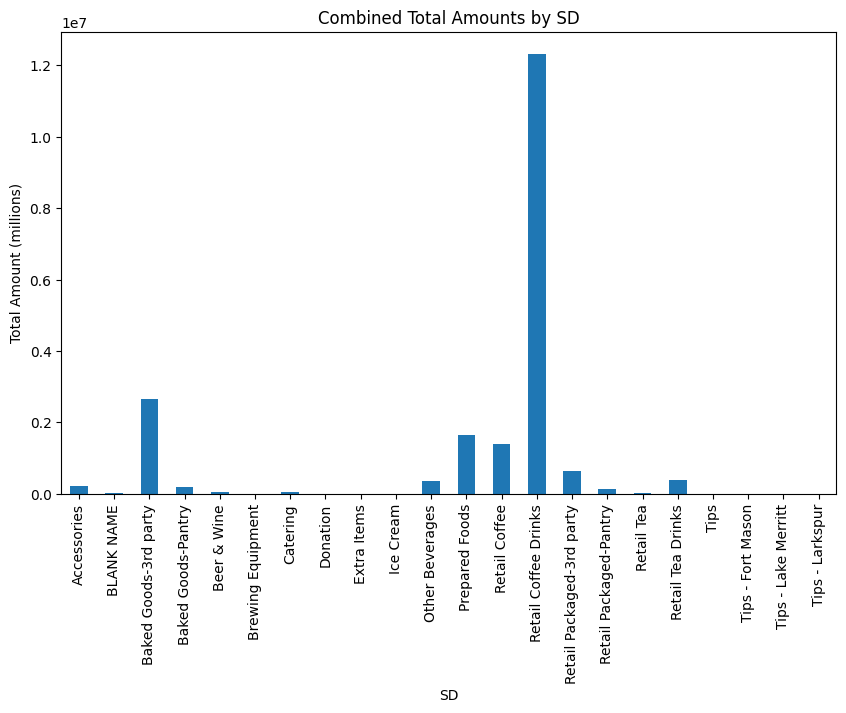

In [137]:
# Group the data by 'SD' and sum the 'AMOUNT'
combined_grouped_data = combined_sales_data.groupby('SD')['AMOUNT'].sum()
print(combined_grouped_data.head(10))
print(combined_grouped_data.tail(10))   

# # Remove System Balance from the data
# fm_grouped_data = fm_grouped_data.drop('System Balance')

# Plot the data
plt.figure(figsize=(10, 6))
combined_grouped_data.plot(kind='bar')
plt.title('Combined Total Amounts by SD')
plt.xlabel('SD')
plt.ylabel('Total Amount (millions)')
plt.show()

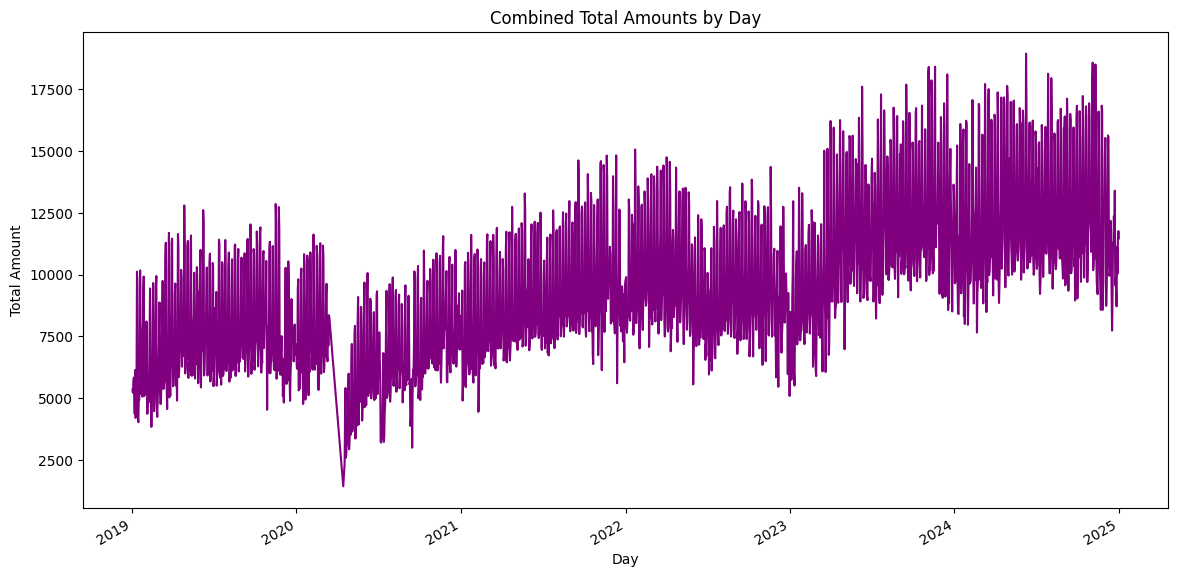

In [138]:
# Group the data by 'date' and sum the 'AMOUNT'
combined_daily_totals = combined_sales_data.groupby('date')['AMOUNT'].sum()

# Plot the data
plt.figure(figsize=(14, 7))
combined_daily_totals.plot(kind='line', color='purple')
plt.title('Combined Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


In [139]:
# one last time to check anomalies
unusually_low_sales_days = combined_daily_totals[combined_daily_totals < 6000]
print('unusually_low_sales_days')
print(unusually_low_sales_days)

unusually_low_sales_days
date
2019-01-02    5359.4600
2019-01-03    5226.5299
2019-01-04    5615.5300
2019-01-05    5836.6798
2019-01-06    5163.5300
                ...    
2022-12-27    5978.0500
2022-12-31    5093.6400
2023-01-04    5747.2500
2023-01-11    5516.7400
2023-02-28    5899.6100
Name: AMOUNT, Length: 243, dtype: float64


Find the dates for that sudden drop that all 3 stores encountered (COVID or other external factor)

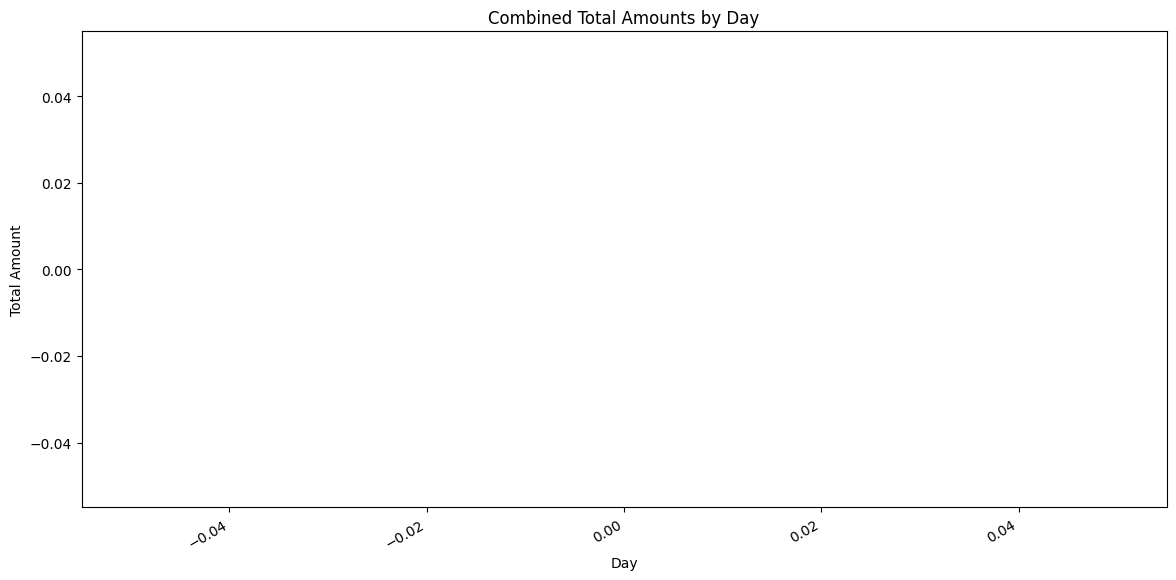

In [140]:
# Filter data for the year 2020
filtered_sales_data_2020 = combined_daily_totals.loc['2020-03-15':'2020-04-13']

# Plot the data
plt.figure(figsize=(14, 7))
filtered_sales_data_2020.plot(kind='line', color='purple')
plt.title('Combined Total Amounts by Day')
plt.xlabel('Day')
plt.ylabel('Total Amount')
plt.show()


Finally, remove the combined dates to remove from the weather data so that every date with weather matches a date with legitimate sales data

In [141]:
# Remove combined dates to remove from weather data
print("Weather Data Length before matching:", len(weather_data))
print("Combined Dates to Reomve Length:", len(combinedDatesToRemove))
#combined_weather_data = weather_data[~weather_data['date'].isin(combinedDatesToRemove)]
#print("Combined Weather Data Length:", len(combined_weather_data))
#print("Combined Sales Data Length:", len(combined_daily_totals))


# Remove all dates from the combined weather data that are not in the combined sales data
combined_weather_data = weather_data[weather_data['date'].isin(combined_daily_totals.index)]
print("Combined Weather Data Length:", len(combined_weather_data))
print("Combined Sales Data Length:", len(combined_daily_totals))


Weather Data Length before matching: 2150
Combined Dates to Reomve Length: 14
Combined Weather Data Length: 2130
Combined Sales Data Length: 2130


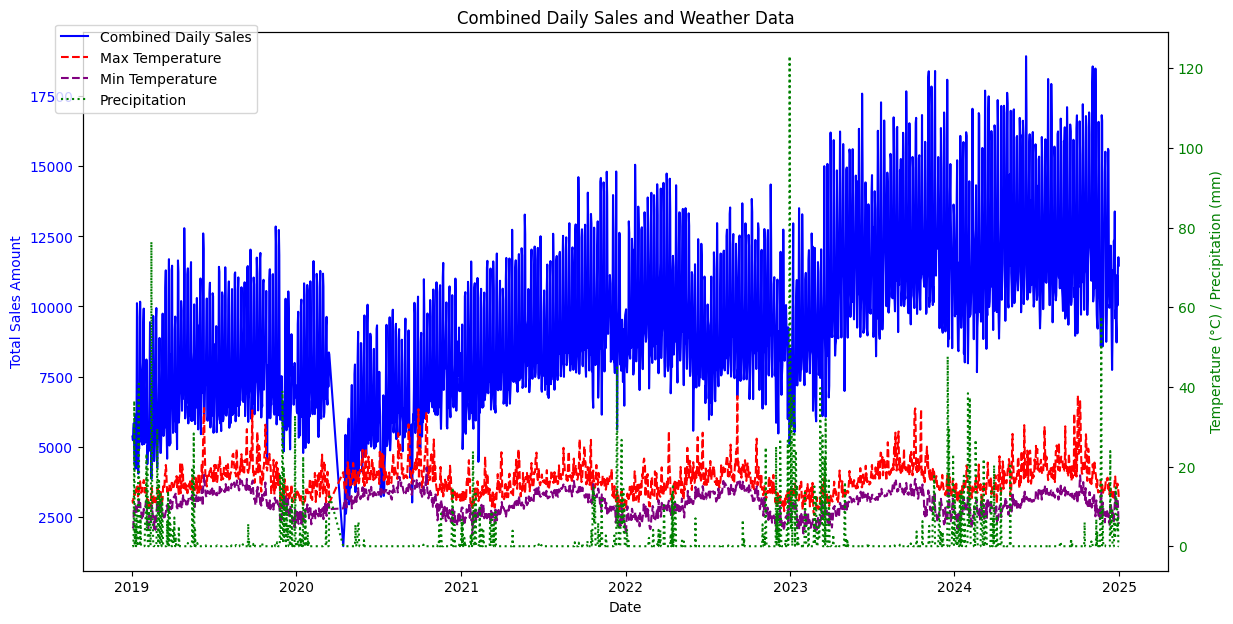

In [142]:
# Plot the combined daily sales and weather data
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot combined daily sales
ax1.plot(combined_daily_totals.index, combined_daily_totals.values, label='Combined Daily Sales', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales Amount', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Combined Daily Sales and Weather Data')

# Create a secondary y-axis for weather data
ax2 = ax1.twinx()

# Plot Max Temperature
ax2.plot(combined_weather_data['date'], combined_weather_data['temp_max'], label='Max Temperature', color='red', linestyle='--')

# Plot Min Temperature
ax2.plot(combined_weather_data['date'], combined_weather_data['temp_min'], label='Min Temperature', color='purple', linestyle='--')

# Plot Precipitation
ax2.plot(combined_weather_data['date'], combined_weather_data['precipitation'], label='Precipitation', color='green', linestyle=':')

# Add labels for weather data
ax2.set_ylabel('Temperature (°C) / Precipitation (mm)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

TODO - TEAM - USE THESE 3 VALUES FOR YOUR MODELS!!!!

1. combined_sales_data = All 3 stores combined with matching dates (includes all the columns, LOCATION, date, SD, AMOUNT, etc.)
2. combined_daily_totals = All 3 stores combined daily sales amounts
3. combined_weather_data = Matching weather dates to all 3 stores being open (if any one store closed, the data is removed from these combined values)

GO GO GO!

In [143]:
# Merge combined_weather_data and combined_daily_totals on date
merged_data = combined_weather_data.merge(combined_daily_totals, left_on='date', right_index=True)
print(merged_data.head)
print(merged_data.tail())
print(merged_data.columns)
print(merged_data.info())
print(merged_data.describe())
print(merged_data.isnull().sum())


<bound method NDFrame.head of            date  temp_max  temp_min  precipitation      AMOUNT
1    2019-01-02      11.6       4.5            0.0   5359.4600
2    2019-01-03      10.9       4.6            0.0   5226.5299
3    2019-01-04      12.0       4.9            0.0   5615.5300
4    2019-01-05      12.7       9.4            5.8   5836.6798
5    2019-01-06      13.4       8.5           36.5   5163.5300
...         ...       ...       ...            ...         ...
2187 2024-12-27      14.9      11.3           11.4  11114.9500
2188 2024-12-28      15.7      11.9            4.0  10033.9100
2189 2024-12-29      14.6      10.7            7.6  11458.2400
2190 2024-12-30      13.7       7.1            0.0  11757.7400
2191 2024-12-31      12.1       5.6            0.0  11457.9300

[2130 rows x 5 columns]>
           date  temp_max  temp_min  precipitation    AMOUNT
2187 2024-12-27      14.9      11.3           11.4  11114.95
2188 2024-12-28      15.7      11.9            4.0  10033.91
2189 

Summary Statistics:
                                date     temp_max     temp_min  precipitation  \
count                           2130  2130.000000  2130.000000    2130.000000   
mean   2022-01-05 05:42:45.633803008    16.831033    10.926150       1.647042   
min              2019-01-02 00:00:00     7.800000     2.900000       0.000000   
25%              2020-07-21 06:00:00    14.000000     8.700000       0.000000   
50%              2022-01-11 12:00:00    16.400000    11.200000       0.000000   
75%              2023-07-01 18:00:00    18.900000    13.300000       0.000000   
max              2024-12-31 00:00:00    37.900000    19.800000     123.000000   
std                              NaN     4.010445     2.880926       5.980547   

             AMOUNT  
count   2130.000000  
mean    9417.516928  
min     1443.620000  
25%     7146.040000  
50%     9085.190000  
75%    11162.407500  
max    18929.950000  
std     3041.089889  

Correlation Table:
                   date  temp_ma

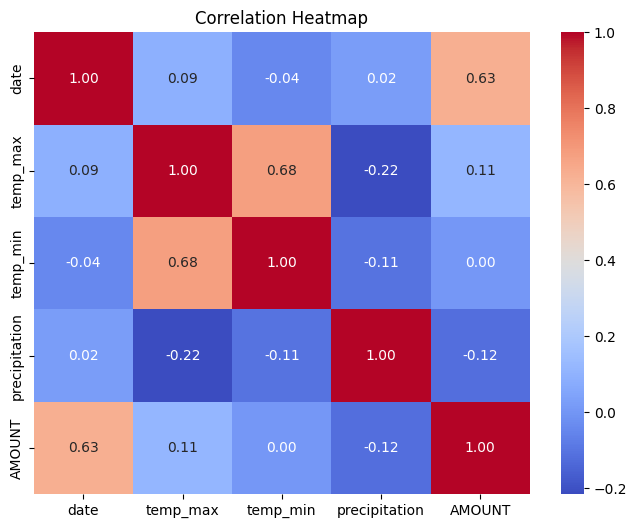

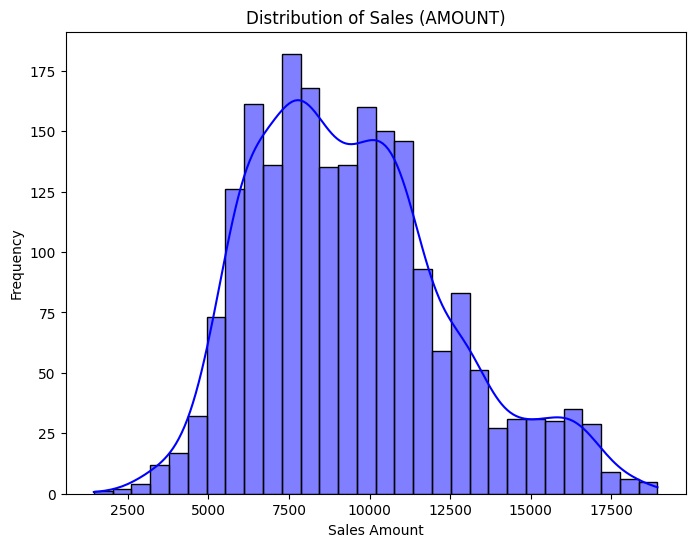

Mean Sales: 9417.52
Standard Deviation of Sales: 3041.09


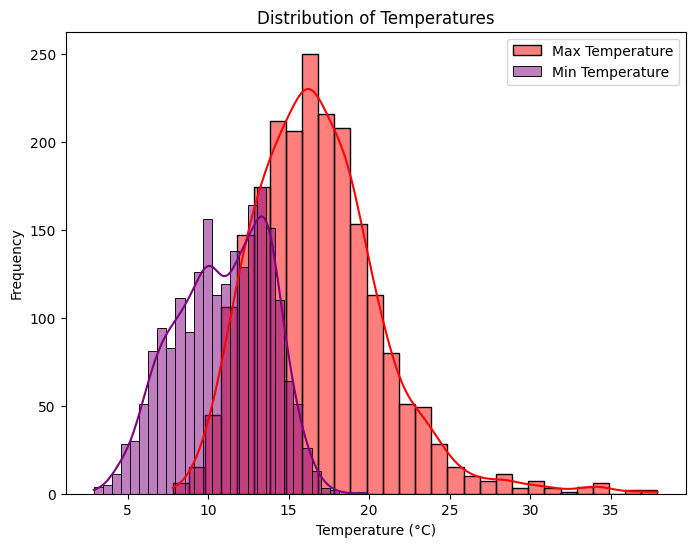

Mean Max Temperature: 16.83
Mean Min Temperature: 10.93
Standard Deviation of Max Temperature: 4.01
Standard Deviation of Min Temperature: 2.88


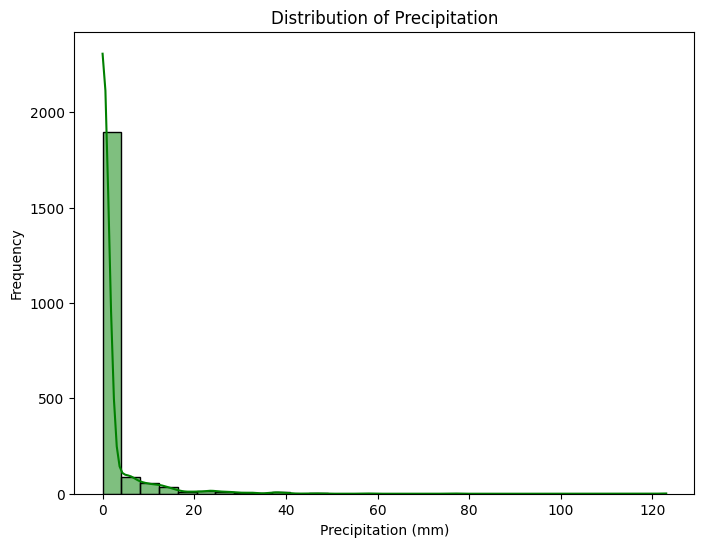

In [144]:
# Summary statistics
print("Summary Statistics:")
print(merged_data.describe())

# Correlation table
print("\nCorrelation Table:")
correlation_table = merged_data.corr()
print(correlation_table)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Distributions
# Distribution of sales (AMOUNT)
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['AMOUNT'], kde=True, color='blue', bins=30)
plt.title("Distribution of Sales (AMOUNT)")
plt.xlabel("Sales Amount")
plt.ylabel("Frequency")
plt.show()

# Mean and standard deviation of sales (AMOUNT)
mean_sales = merged_data['AMOUNT'].mean()
std_sales = merged_data['AMOUNT'].std()
print(f"Mean Sales: {mean_sales:.2f}")
print(f"Standard Deviation of Sales: {std_sales:.2f}")

# Distribution of temperature (temp_max and temp_min)
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['temp_max'], kde=True, color='red', bins=30, label='Max Temperature')
sns.histplot(merged_data['temp_min'], kde=True, color='purple', bins=30, label='Min Temperature')
plt.title("Distribution of Temperatures")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Mean and standard deviation of temperature (temp_max and temp_min)
mean_temp_max = merged_data['temp_max'].mean()
mean_temp_min = merged_data['temp_min'].mean()
std_temp_max = merged_data['temp_max'].std()
std_temp_min = merged_data['temp_min'].std()
print(f"Mean Max Temperature: {mean_temp_max:.2f}")
print(f"Mean Min Temperature: {mean_temp_min:.2f}")
print(f"Standard Deviation of Max Temperature: {std_temp_max:.2f}")
print(f"Standard Deviation of Min Temperature: {std_temp_min:.2f}")

# Distribution of precipitation
plt.figure(figsize=(8, 6))
sns.histplot(merged_data['precipitation'], kde=True, color='green', bins=30)
plt.title("Distribution of Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

Paul - Copilot prompt: Train a linear regression model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

Linear Regression Model Evaluation:
Mean Squared Error (MSE): 9677431.15498675
R-squared (R2): 0.029650138213992205
Mean Absolute Error (MAE): 2439.5856066782694

Coefficients:
         Feature  Coefficient
0       temp_max   541.994454
1       temp_min  -387.878182
2  precipitation  -267.188881


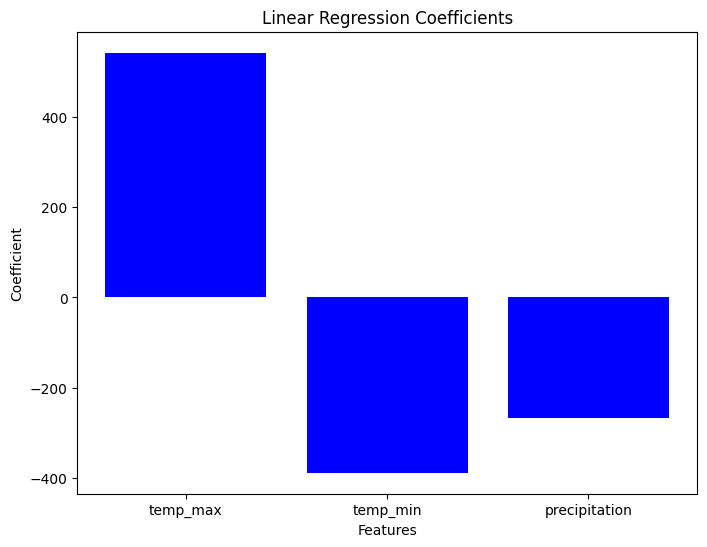

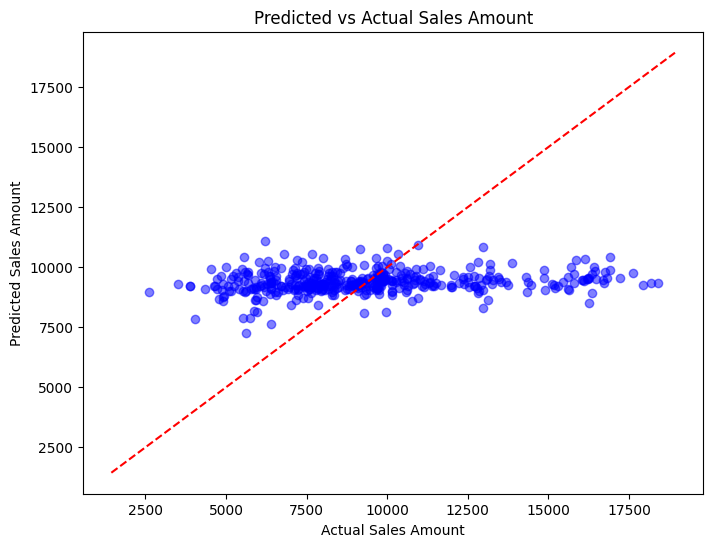

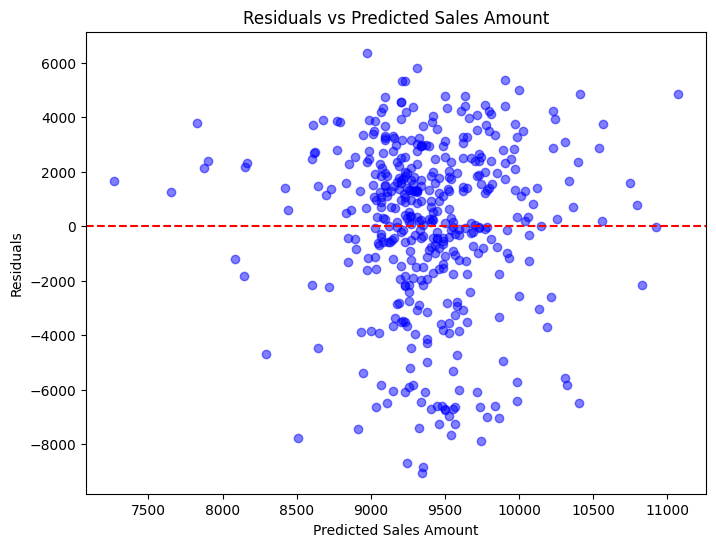


VIF Data:
         feature       VIF
0          const  1.000417
1       temp_max  1.913595
2       temp_min  1.845088
3  precipitation  1.051052

Correlation Matrix:
               temp_max  temp_min  precipitation
temp_max       1.000000  0.680346      -0.216285
temp_min       0.680346  1.000000      -0.105838
precipitation -0.216285 -0.105838       1.000000


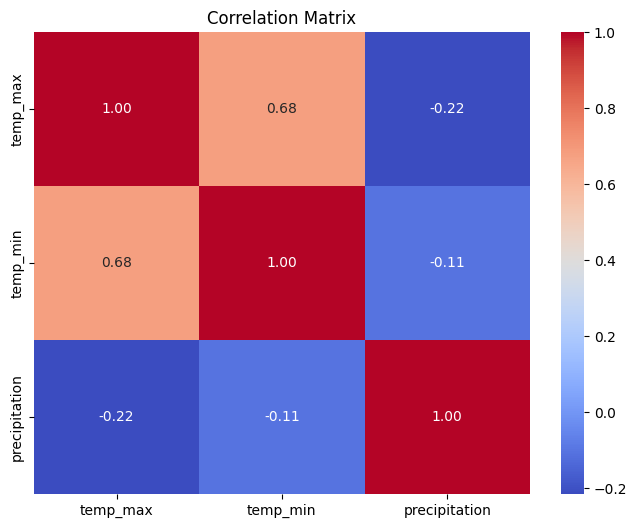

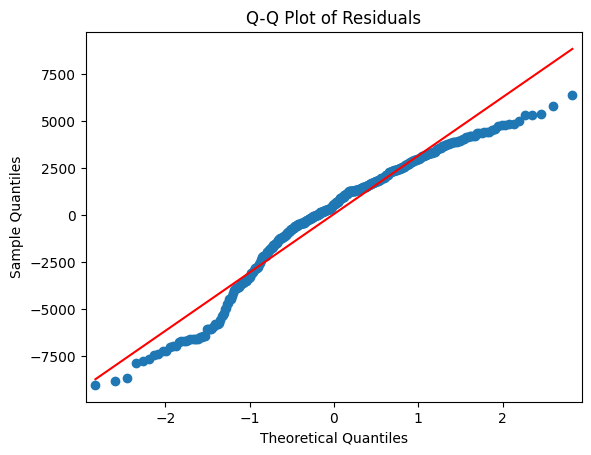

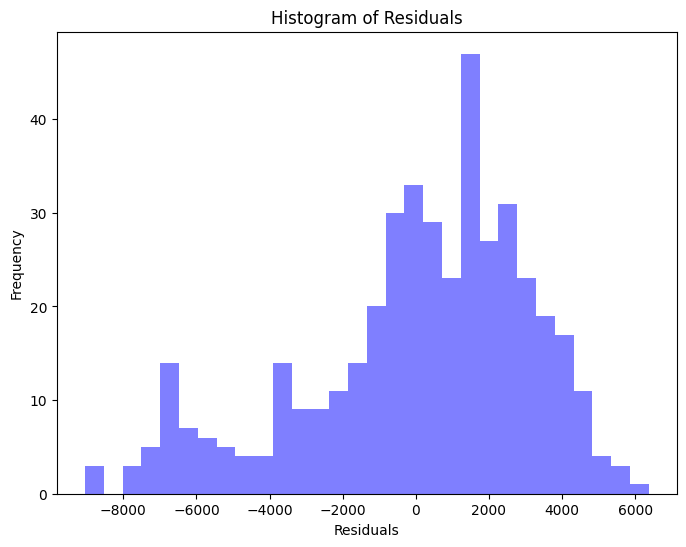


Shapiro-Wilk Test Statistic: 0.9467726382162956
Shapiro-Wilk Test p-value: 3.0486011881099335e-11

Durbin-Watson Test Statistic: 2.0294987327515503


<Figure size 800x600 with 0 Axes>

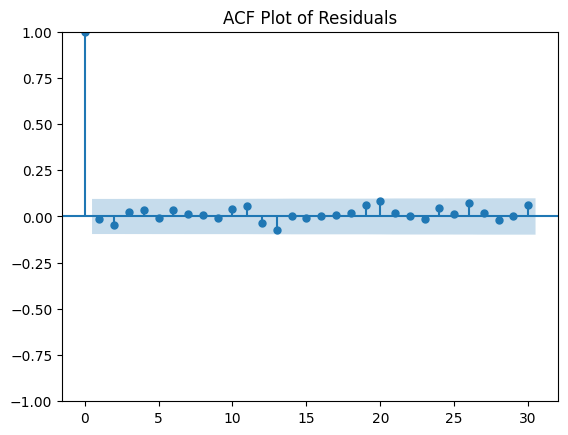

<Figure size 800x600 with 0 Axes>

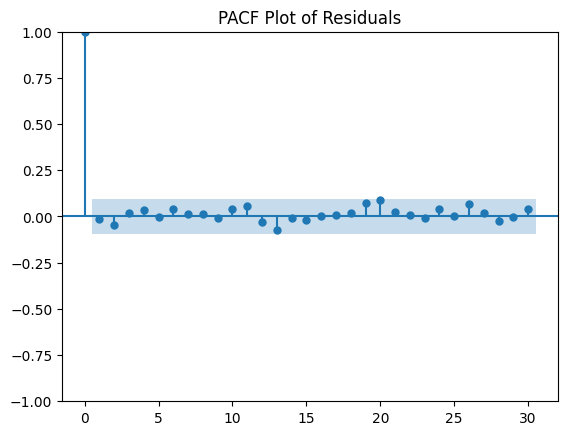

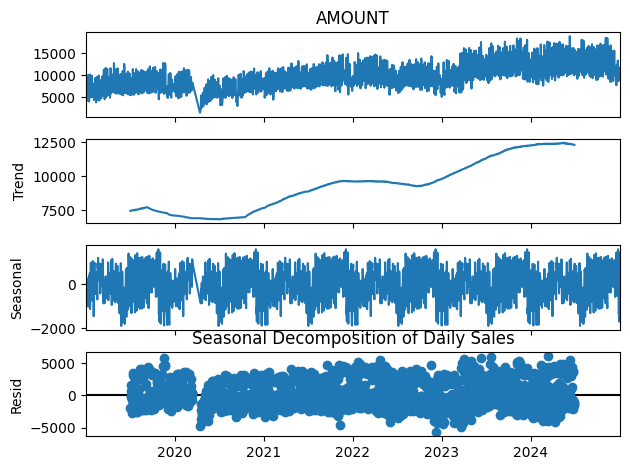

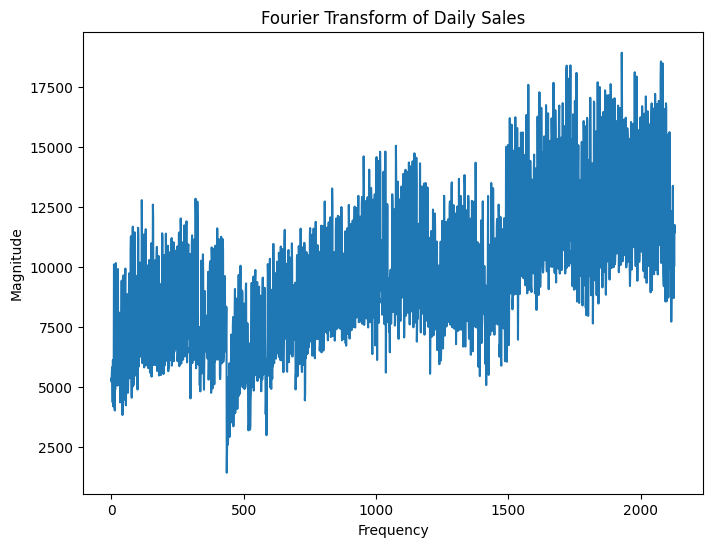

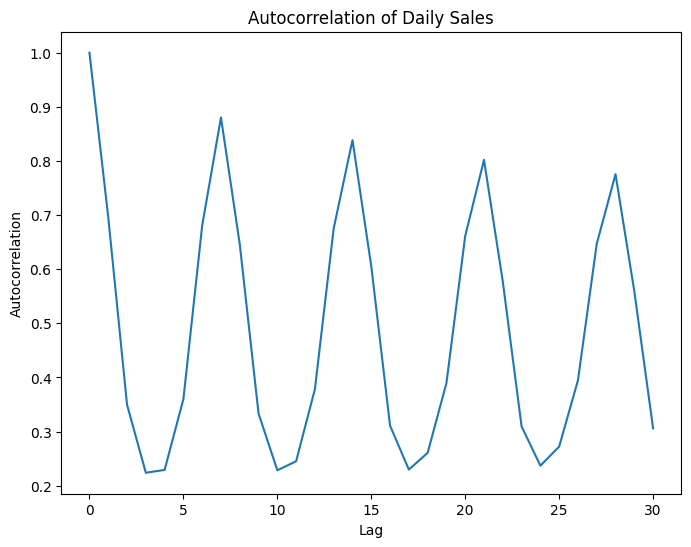

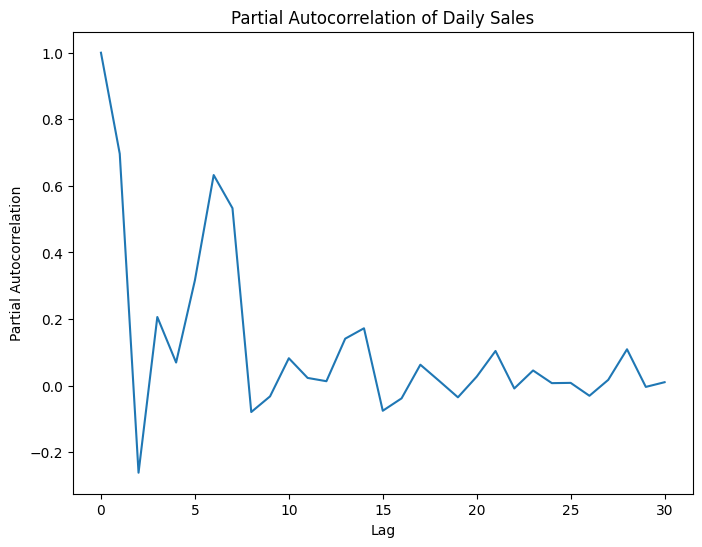

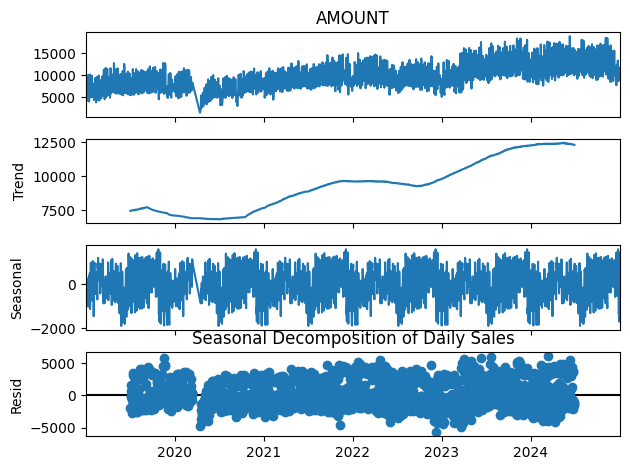

In [145]:

# Run Linear Regression Model
# Prepare the data for modeling 
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# Add a constant term for the intercept
#X_scaled_df = sm.add_constant(X_scaled_df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
# Create a Linear Regression model
model = LinearRegression()
# Fit the model to the training data
model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# Print the evaluation metrics
print("Linear Regression Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
# Display the coefficients
coefficients = pd.DataFrame({'Feature': X_scaled_df.columns, 'Coefficient': model.coef_})
print("\nCoefficients:")
print(coefficients)

# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'], color='blue')
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Linear Regression Coefficients")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='blue', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Check for multicollinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X_with_const = add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVIF Data:")
print(vif_data)
# Check for multicollinearity using correlation matrix
correlation_matrix = X.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
# Check for normality of residuals using Q-Q plot
import scipy.stats as stats
import statsmodels.api as sm
# Q-Q plot
sm.qqplot(y_pred - y_test, line='s')
plt.title("Q-Q Plot of Residuals") 
plt.show()
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(y_pred - y_test, bins=30, color='blue', alpha=0.5)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Check for normality of residuals using Shapiro-Wilk test
from scipy.stats import shapiro
# Perform Shapiro-Wilk test
shapiro_test = shapiro(y_pred - y_test)
print("\nShapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)


# # Check for homoscedasticity using Breusch-Pagan test
# from statsmodels.stats.diagnostic import het_breuschpagan
# # Perform Breusch-Pagan test
# bp_test = het_breuschpagan(y_pred - y_test, X_with_const)
# bp_test_results = pd.DataFrame(bp_test, columns=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value'])
# print("\nBreusch-Pagan Test Results:")
# print(bp_test_results)

# Check for autocorrelation using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
# Perform Durbin-Watson test
dw_test = durbin_watson(y_pred - y_test)
print("\nDurbin-Watson Test Statistic:", dw_test)
# Check for autocorrelation using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF plot
plt.figure(figsize=(8, 6))
plot_acf(y_pred - y_test, lags=30)
plt.title("ACF Plot of Residuals")
plt.show()
# PACF plot
plt.figure(figsize=(8, 6))
plot_pacf(y_pred - y_test, lags=30)
plt.title("PACF Plot of Residuals")
plt.show()
# Check for seasonality using seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
result = seasonal_decompose(combined_daily_totals, model='additive', period=365)
result.plot()
plt.title("Seasonal Decomposition of Daily Sales")
plt.show()


# convert combined_daily_totals to dataframe
combined_daily_totals_df = pd.DataFrame(combined_daily_totals)

# Check for seasonality using Fourier Transform
from scipy.fftpack import fft
# Perform Fourier Transform
fft_result = fft(combined_daily_totals_df)
# Plot the Fourier Transform result
plt.figure(figsize=(8, 6))
plt.plot(np.abs(fft_result))
plt.title("Fourier Transform of Daily Sales")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Check for seasonality using autocorrelation
from statsmodels.tsa.stattools import acf, pacf
# Perform autocorrelation
acf_result = acf(combined_daily_totals, nlags=30)
# Plot the autocorrelation result
plt.figure(figsize=(8, 6))
plt.plot(acf_result)
plt.title("Autocorrelation of Daily Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()
# Check for seasonality using partial autocorrelation
from statsmodels.tsa.stattools import pacf
# Perform partial autocorrelation
pacf_result = pacf(combined_daily_totals, nlags=30)
# Plot the partial autocorrelation result
plt.figure(figsize=(8, 6))
plt.plot(pacf_result)
plt.title("Partial Autocorrelation of Daily Sales")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.show()
# Check for seasonality using seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
result = seasonal_decompose(combined_daily_totals, model='additive', period=365)
# Plot the seasonal decomposition result
result.plot()
plt.title("Seasonal Decomposition of Daily Sales")
plt.show()


# # Check for seasonality using STL decomposition
# from statsmodels.tsa.seasonal import STL
# # Perform STL decomposition
# stl = STL(combined_daily_totals, seasonal=13)
# result = stl.fit()
# # Plot the STL decomposition result
# result.plot()
# plt.title("STL Decomposition of Daily Sales")
# plt.show()

Paul - Copilot prompt: Train a random forest regressor model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

Random Forest Regressor Model Evaluation:
Mean Squared Error (MSE): 11639964.33079512
R-squared (R2): -0.1671318140828013
Mean Absolute Error (MAE): 2655.577717920073

Feature Importances:
         Feature  Importance
0       temp_max    0.471253
1       temp_min    0.420452
2  precipitation    0.108295


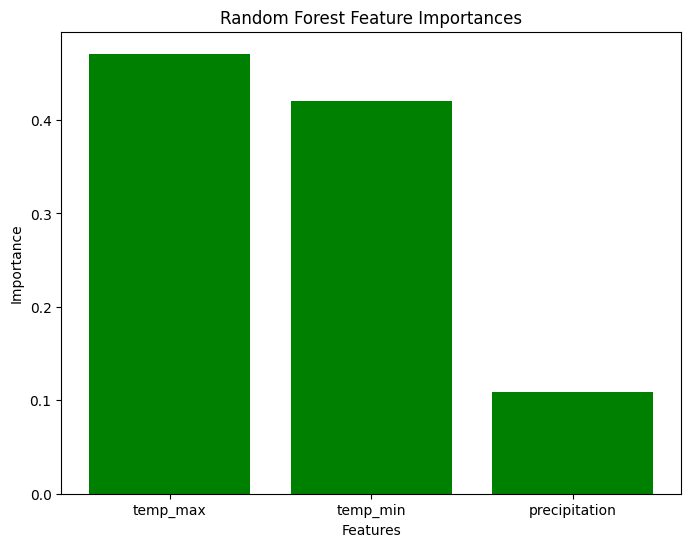

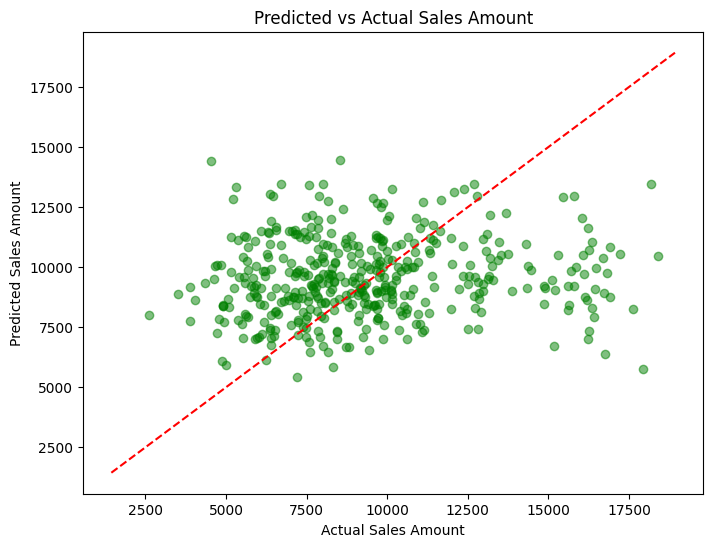

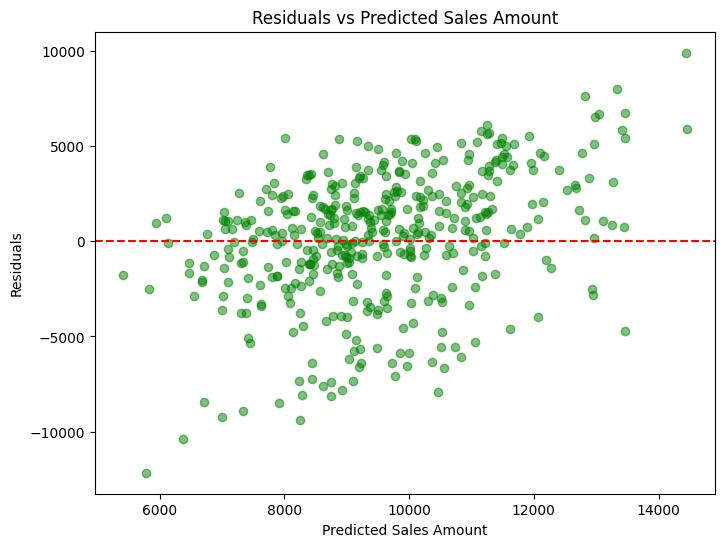


VIF Data:
         feature        VIF
0          const  21.105483
1       temp_max   1.913595
2       temp_min   1.845088
3  precipitation   1.051052

Correlation Matrix:
               temp_max  temp_min  precipitation
temp_max       1.000000  0.680346      -0.216285
temp_min       0.680346  1.000000      -0.105838
precipitation -0.216285 -0.105838       1.000000


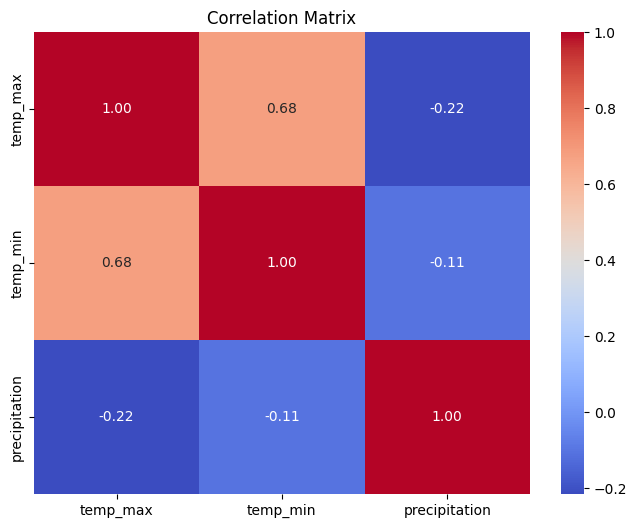

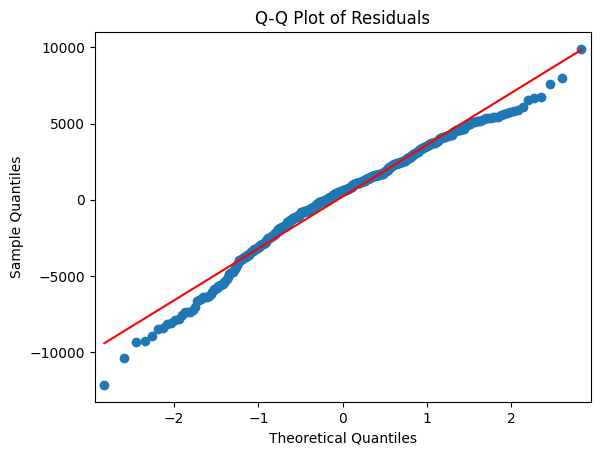

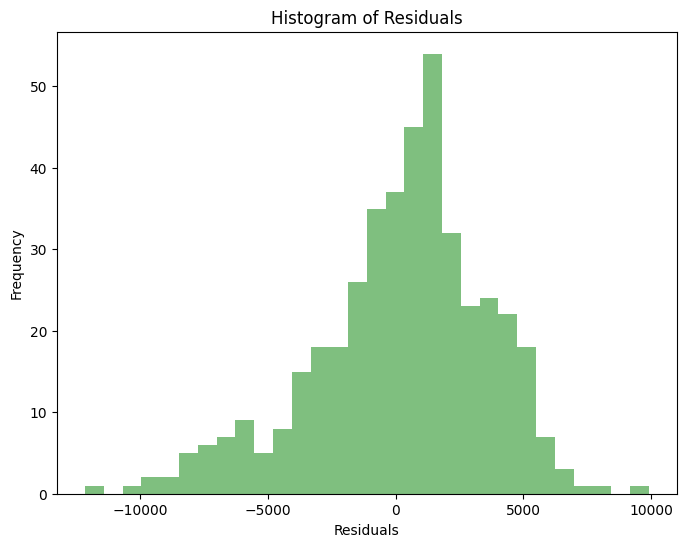


Shapiro-Wilk Test Statistic: 0.9768325115733595
Shapiro-Wilk Test p-value: 2.603336294318759e-06

Durbin-Watson Test Statistic: 1.9370840909931182


<Figure size 800x600 with 0 Axes>

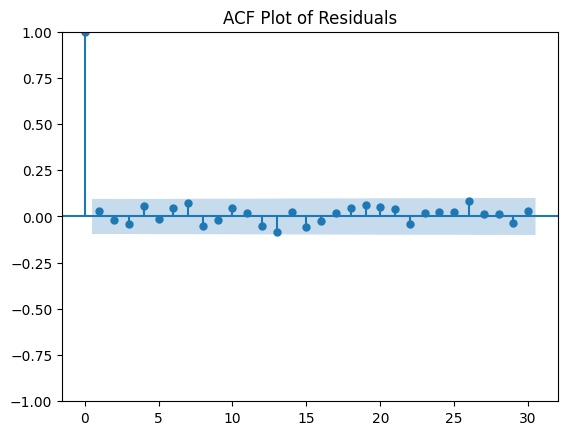

<Figure size 800x600 with 0 Axes>

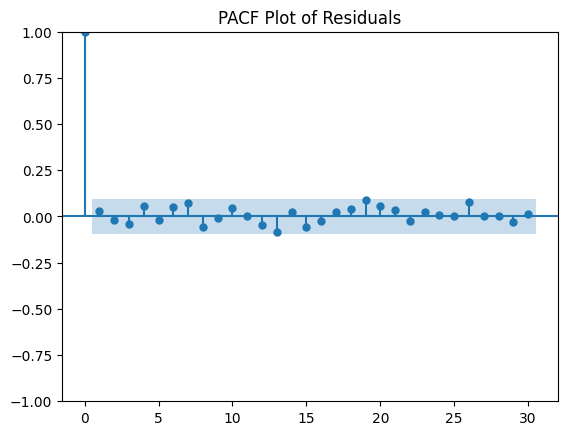

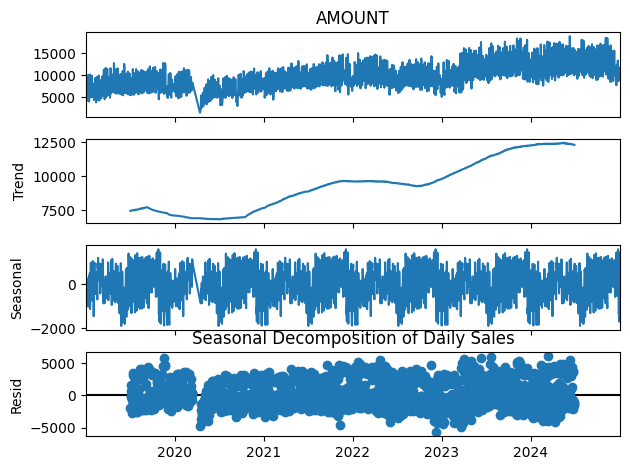

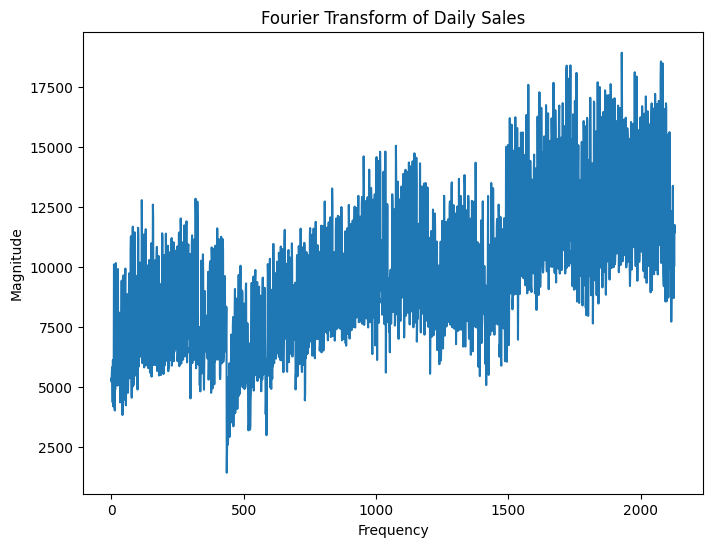

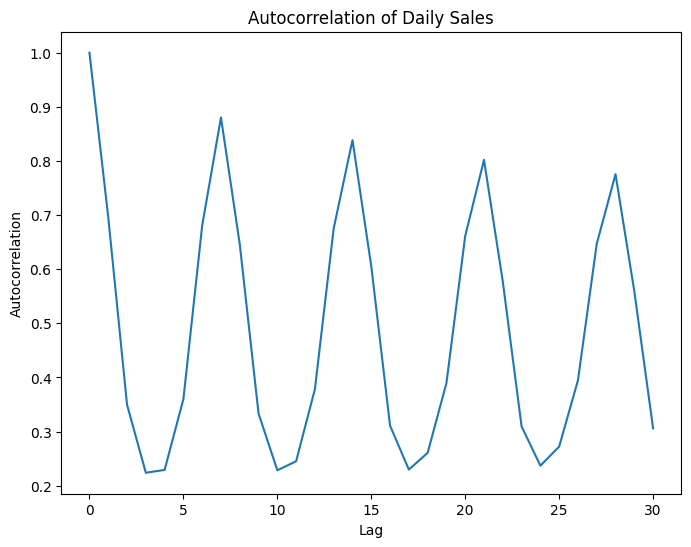

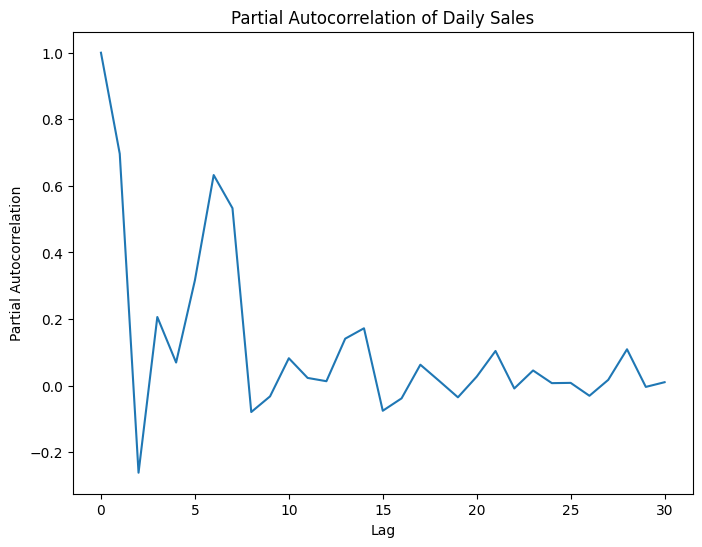

In [146]:

# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regressor Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='green')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='green', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Check for multicollinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X_with_const = add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVIF Data:")
print(vif_data)
# Check for multicollinearity using correlation matrix
correlation_matrix = X.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
# Check for normality of residuals using Q-Q plot
import scipy.stats as stats
import statsmodels.api as sm
# Q-Q plot
sm.qqplot(y_pred - y_test, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(y_pred - y_test, bins=30, color='green', alpha=0.5)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
# Check for normality of residuals using Shapiro-Wilk test
from scipy.stats import shapiro
# Perform Shapiro-Wilk test
shapiro_test = shapiro(y_pred - y_test)
print("\nShapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

# # Check for homoscedasticity using Breusch-Pagan test
# from statsmodels.stats.diagnostic import het_breuschpagan
# # Perform Breusch-Pagan test
# bp_test = het_breuschpagan(y_pred - y_test, X_with_const)
# bp_test_results = pd.DataFrame(bp_test, columns=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value'])
# print("\nBreusch-Pagan Test Results:")
# print(bp_test_results)

# Check for autocorrelation using Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
# Perform Durbin-Watson test
dw_test = durbin_watson(y_pred - y_test)
print("\nDurbin-Watson Test Statistic:", dw_test)
# Check for autocorrelation using ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF plot
plt.figure(figsize=(8, 6))
plot_acf(y_pred - y_test, lags=30)
plt.title("ACF Plot of Residuals")
plt.show()
# PACF plot
plt.figure(figsize=(8, 6))
plot_pacf(y_pred - y_test, lags=30)
plt.title("PACF Plot of Residuals")
plt.show()
# Check for seasonality using seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition
result = seasonal_decompose(combined_daily_totals, model='additive', period=365)
# Plot the seasonal decomposition result
result.plot()
plt.title("Seasonal Decomposition of Daily Sales")
plt.show()
# Check for seasonality using Fourier Transform
from scipy.fftpack import fft
# Perform Fourier Transform
fft_result = fft(combined_daily_totals_df)
# Plot the Fourier Transform result
plt.figure(figsize=(8, 6))
plt.plot(np.abs(fft_result))
plt.title("Fourier Transform of Daily Sales")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()
# Check for seasonality using autocorrelation
from statsmodels.tsa.stattools import acf, pacf
# Perform autocorrelation
acf_result = acf(combined_daily_totals, nlags=30)
# Plot the autocorrelation result
plt.figure(figsize=(8, 6))
plt.plot(acf_result)
plt.title("Autocorrelation of Daily Sales")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()
# Check for seasonality using partial autocorrelation
from statsmodels.tsa.stattools import pacf
# Perform partial autocorrelation
pacf_result = pacf(combined_daily_totals, nlags=30)
# Plot the partial autocorrelation result
plt.figure(figsize=(8, 6))
plt.plot(pacf_result)
plt.title("Partial Autocorrelation of Daily Sales")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.show()


Paul - Copilot prompt: Train a Multiple Linear Regression (OLS) model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

OLS Model Evaluation:
Mean Squared Error (MSE): 9677431.15498675
R-squared (R2): 0.029650138213992316
Mean Absolute Error (MAE): 2439.585606678268

OLS Model Summary:
                            OLS Regression Results                            
Dep. Variable:                 AMOUNT   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     18.34
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.03e-11
Time:                        22:26:01   Log-Likelihood:                -16039.
No. Observations:                1704   AIC:                         3.209e+04
Df Residuals:                    1700   BIC:                         3.211e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err        

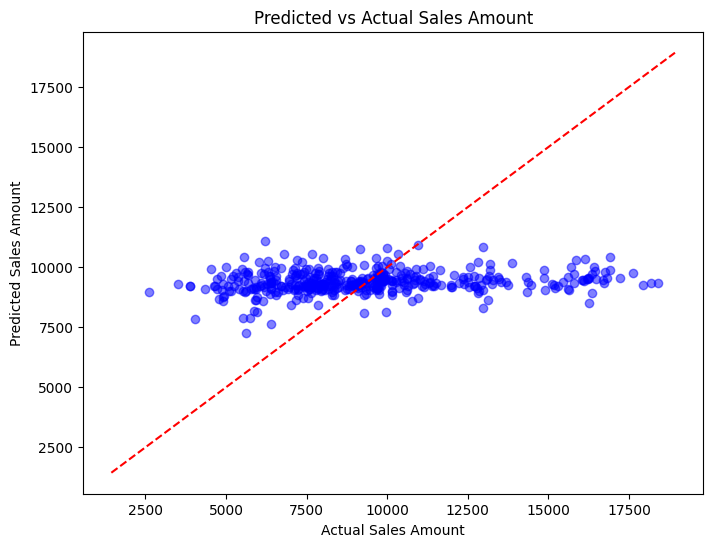

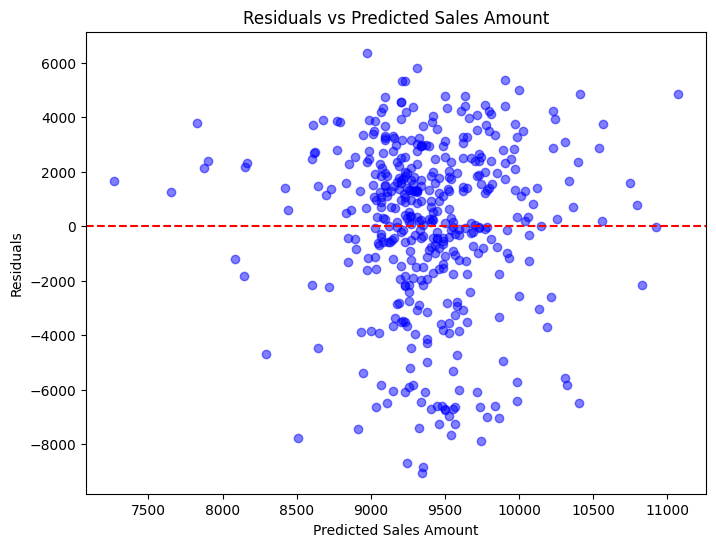

In [147]:
# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Add a constant to the independent variables for OLS
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the OLS model
ols_model = sm.OLS(y_train, X_train).fit()

# Make predictions on the test data
y_pred = ols_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("OLS Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
print("\nOLS Model Summary:")
print(ols_model.summary())

# Show correlation matrix
correlation_matrix = merged_data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='blue', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Paul - For shits and giggles, do a classifcation model before going on to more advanced stuff - Copilot prompt: Train a LOGIT model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

Logistic Regression Model Evaluation:
Accuracy: 0.5610328638497653

Confusion Matrix:
[[139  83]
 [104 100]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       222
           1       0.55      0.49      0.52       204

    accuracy                           0.56       426
   macro avg       0.56      0.56      0.56       426
weighted avg       0.56      0.56      0.56       426


Coefficients:
         Feature  Coefficient
0       temp_max     0.087480
1       temp_min    -0.077131
2  precipitation    -0.021989


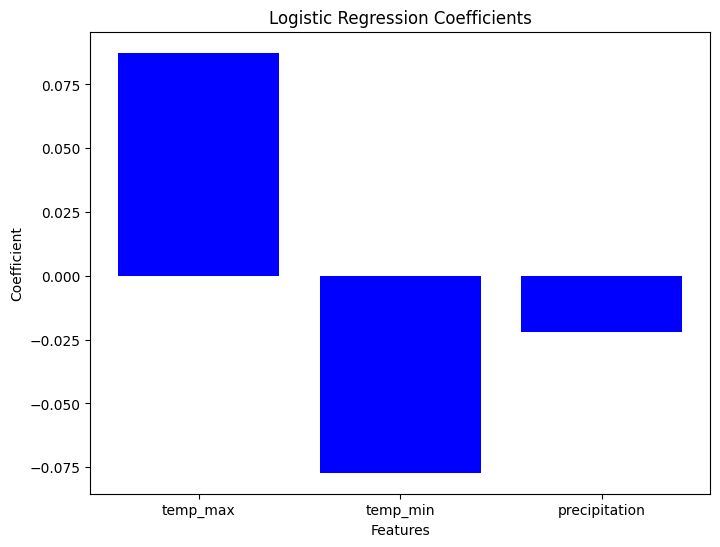

In [148]:
# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y_binary = (merged_data['AMOUNT'] > merged_data['AMOUNT'].median()).astype(int)  # Binary classification: 1 if sales > median, else 0

# Split the data into training and testing sets
X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Create a Logistic Regression model
logit_model = LogisticRegression()

# Fit the model to the training data
logit_model.fit(X_train, y_train_binary)

# Make predictions on the test data
y_pred_binary = logit_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_binary, y_pred_binary)
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
class_report = classification_report(y_test_binary, y_pred_binary)

print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logit_model.coef_[0]})
print("\nCoefficients:")
print(coefficients)

# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'], color='blue')
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Logistic Regression Coefficients")
plt.show()

Paul - Copilot prompt: Train an XGBoost model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

XGBoost Model Evaluation:
Mean Squared Error (MSE): 10209867.426308954
R-squared (R2): -0.023736907791613415
Mean Absolute Error (MAE): 2502.8673187004842

Feature Importances:
         Feature  Importance
2  precipitation    0.369814
1       temp_min    0.325746
0       temp_max    0.304440


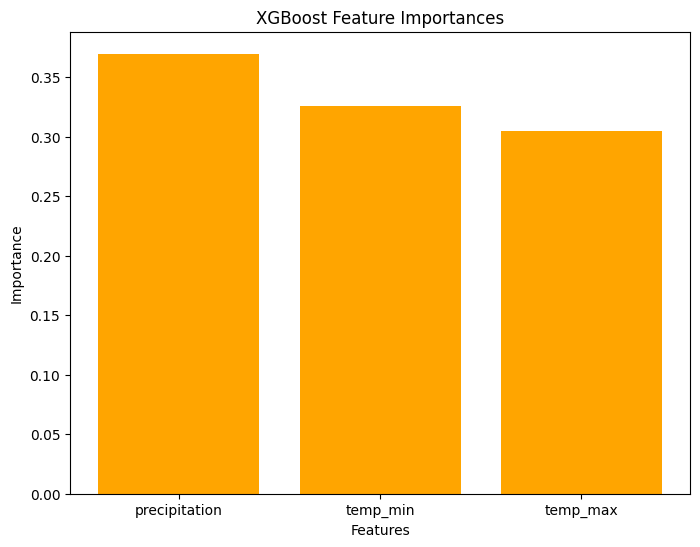

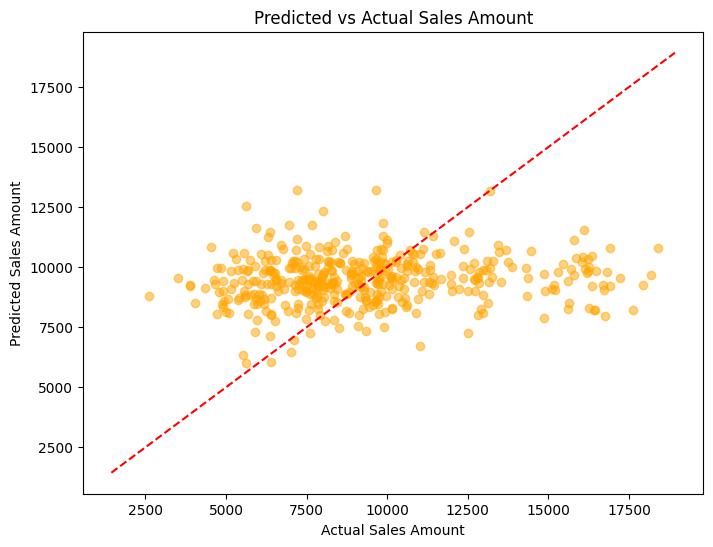

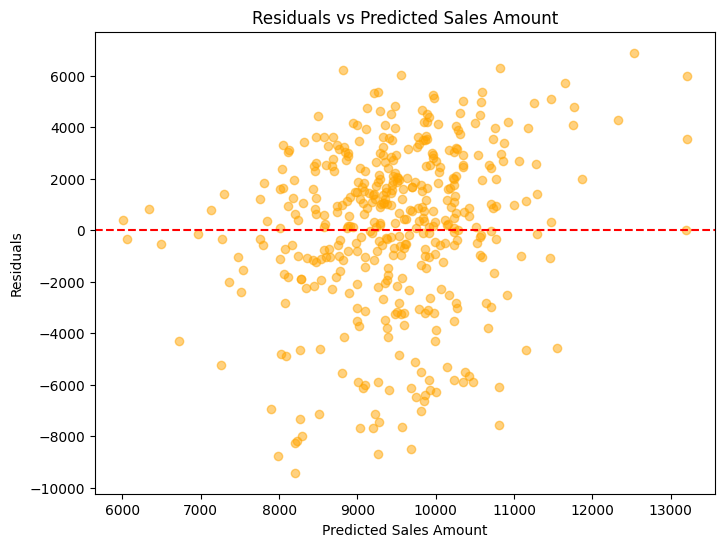

In [149]:
# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='orange')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='orange', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Paul - Lasso w. Cross Validation
Copilot Prompt: Train a LassoCV model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

LassoCV Model Evaluation:
Mean Squared Error (MSE): 9677626.104830673
R-squared (R2): 0.029630590717236505
Mean Absolute Error (MAE): 2439.6847399982366
Best Alpha: 2.166192441248102

Coefficients:
         Feature  Coefficient
0       temp_max   134.715893
1       temp_min  -133.961279
2  precipitation   -44.662533


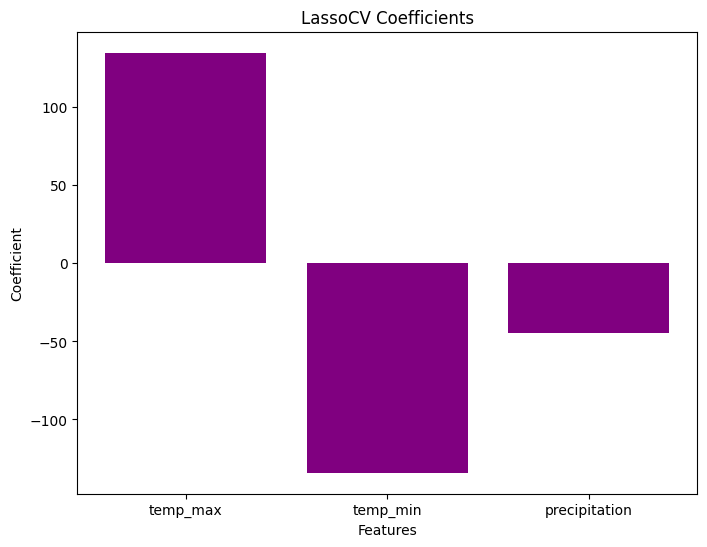

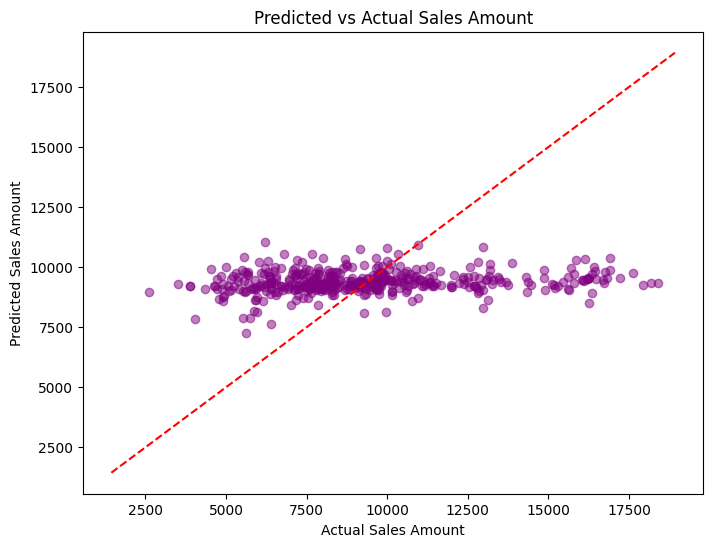

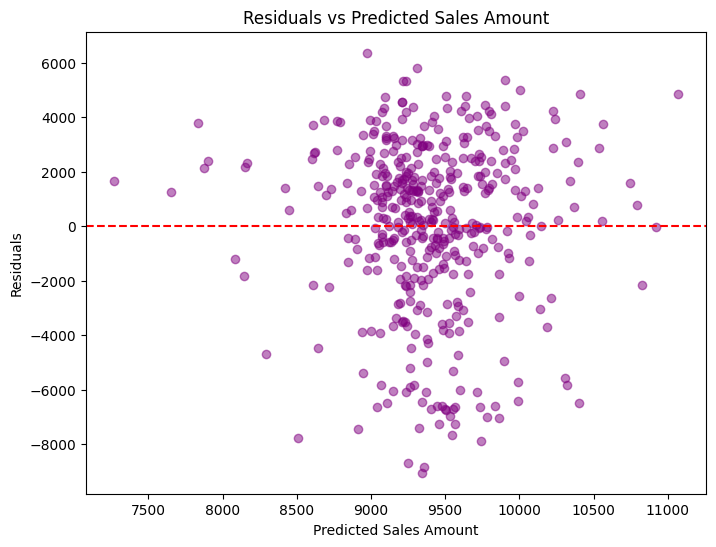

In [150]:

# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LassoCV model
lasso_model = LassoCV(cv=5, random_state=42)

# Fit the model to the training data
lasso_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lasso_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("LassoCV Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)
print("Best Alpha:", lasso_model.alpha_)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso_model.coef_})
print("\nCoefficients:")
print(coefficients)

# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'], color='purple')
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("LassoCV Coefficients")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='purple', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Paul - Ridge Regresion
Copilot Prompt: Apply a StandardScalar and train a Ridge model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales.

Ridge Regression Model Evaluation:
Mean Squared Error (MSE): 9677522.393695928
R-squared (R2): 0.0296409897667006
Mean Absolute Error (MAE): 2439.625712168543

Coefficients:
         Feature  Coefficient
0       temp_max   550.030738
1       temp_min  -386.955015
2  precipitation  -273.842242


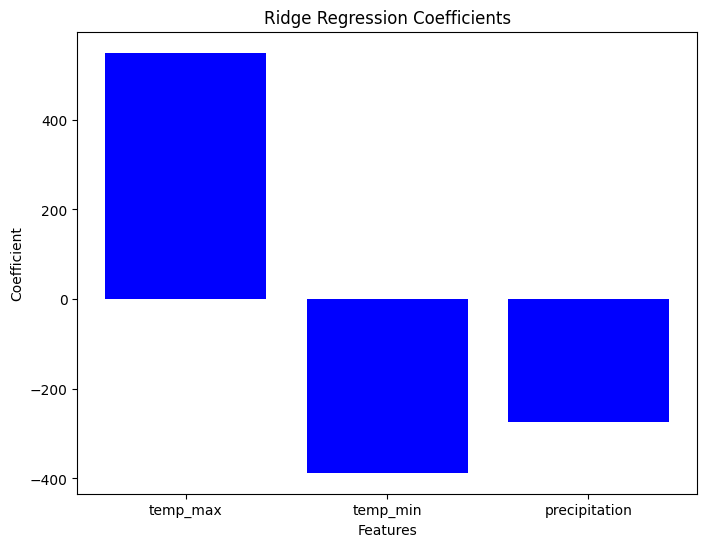

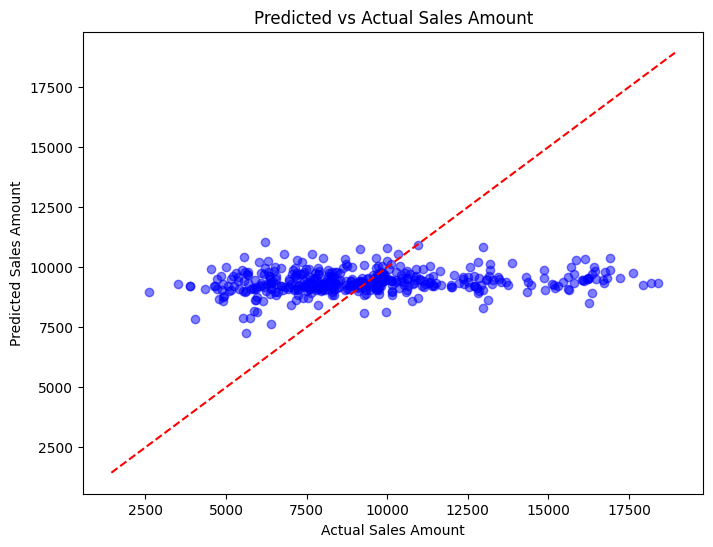

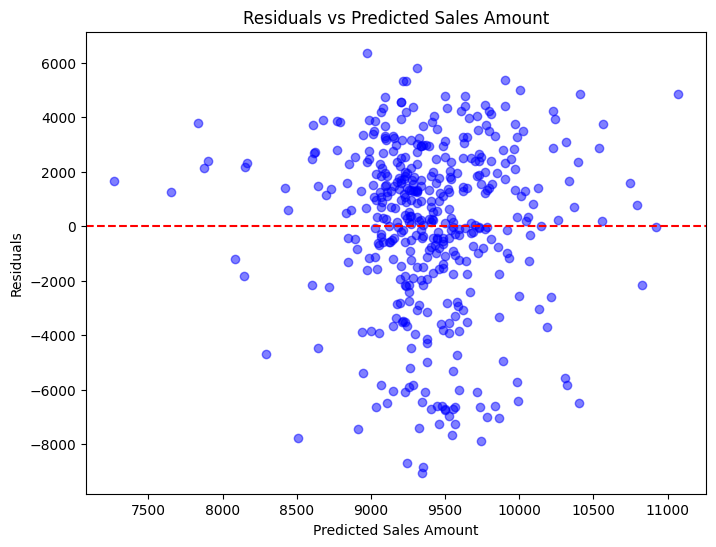

In [151]:
# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Ridge regression model
ridge_model = Ridge(alpha=1.0, random_state=42)

# Fit the model to the training data
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = ridge_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Ridge Regression Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Display the coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge_model.coef_})
print("\nCoefficients:")
print(coefficients)

# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients['Feature'], coefficients['Coefficient'], color='blue')
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.title("Ridge Regression Coefficients")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='blue', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Decision Tree Regressor Model Evaluation:
Mean Squared Error (MSE): 17169005.783474702
R-squared (R2): -0.7215252810569497
Mean Absolute Error (MAE): 3174.505979655712


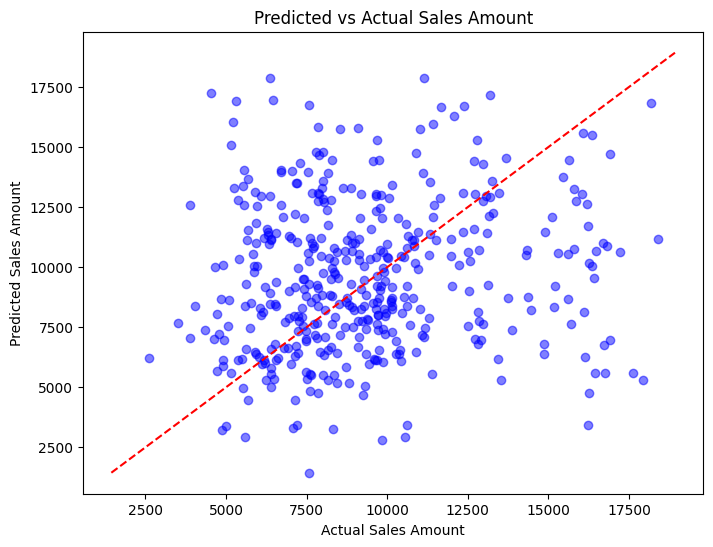

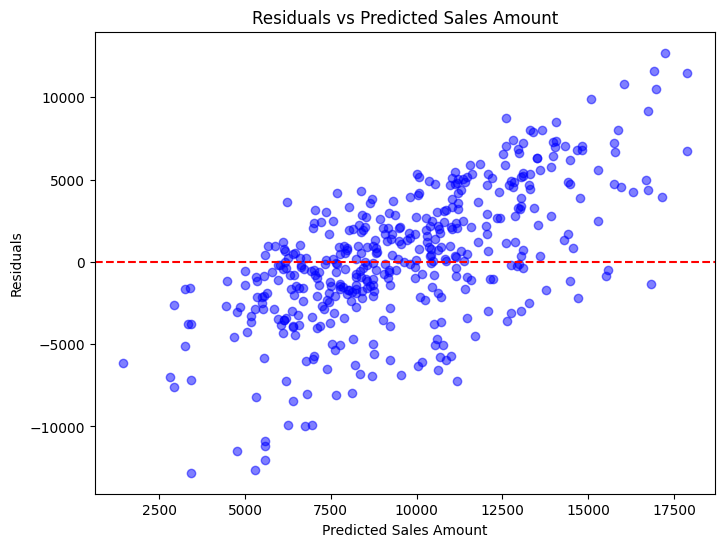

In [152]:
# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation']]
y = merged_data['AMOUNT']

# Apply StandardScaler to standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a DecisionTreeRegressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Decision Tree Regressor Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='blue', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Paul - let's try something new
 
 Copilot prompt: Train a random forest regressor model using 80/20 split (learn/test) to find the affects of the weather (combined_weather_data) on sales (combined_sales_data) to determine the effects of temperature or precipitation on product sales. This time add time-based features (day of week, weekend flag, month, and lagged sales).

Random Forest Regressor Model Evaluation:
Mean Squared Error (MSE): 1173333.0558016968
R-squared (R2): 0.873435431927849
Mean Absolute Error (MAE): 776.9357358028167

Feature Importances:
         Feature  Importance
6   lagged_sales    0.460088
3    day_of_week    0.307989
4     is_weekend    0.137425
0       temp_max    0.028489
1       temp_min    0.024053
2  precipitation    0.023676
5          month    0.018281


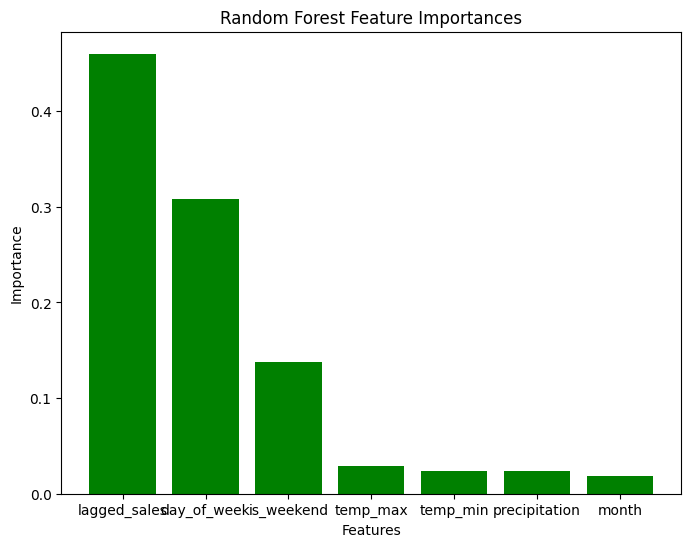

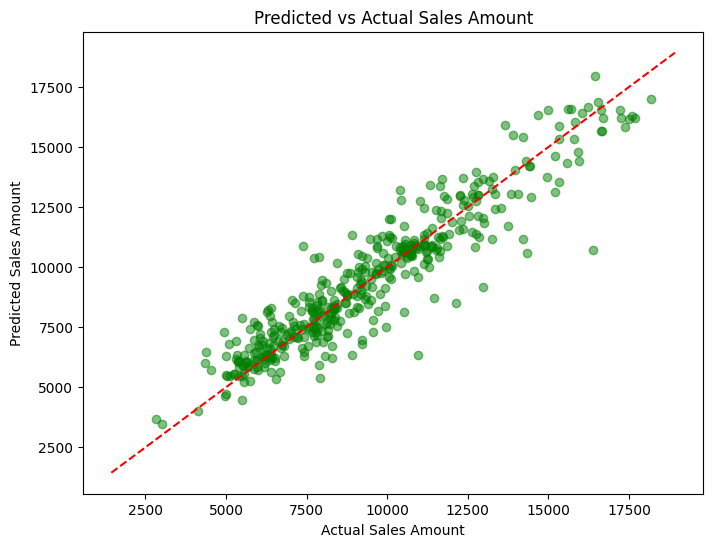

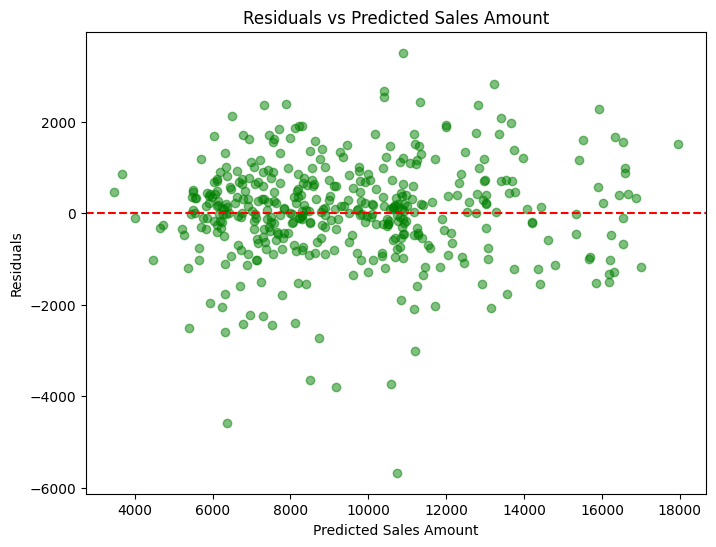


VIF Data:
         feature        VIF
0          const  34.989336
1       temp_max   1.991999
2       temp_min   1.962805
3  precipitation   1.060739
4    day_of_week   2.901147
5     is_weekend   3.237042
6          month   1.147730
7   lagged_sales   1.267995

Correlation Matrix:
               temp_max  temp_min  precipitation  day_of_week  is_weekend  \
temp_max       1.000000  0.680046      -0.216545    -0.023292   -0.017344   
temp_min       0.680046  1.000000      -0.106253     0.010090    0.006284   
precipitation -0.216545 -0.106253       1.000000     0.007369    0.020781   
day_of_week   -0.023292  0.010090       0.007369     1.000000    0.790226   
is_weekend    -0.017344  0.006284       0.020781     0.790226    1.000000   
month          0.288327  0.341795      -0.037514    -0.002462   -0.001454   
lagged_sales   0.123788  0.009693      -0.046046     0.106000    0.327951   

                  month  lagged_sales  
temp_max       0.288327      0.123788  
temp_min       0.34

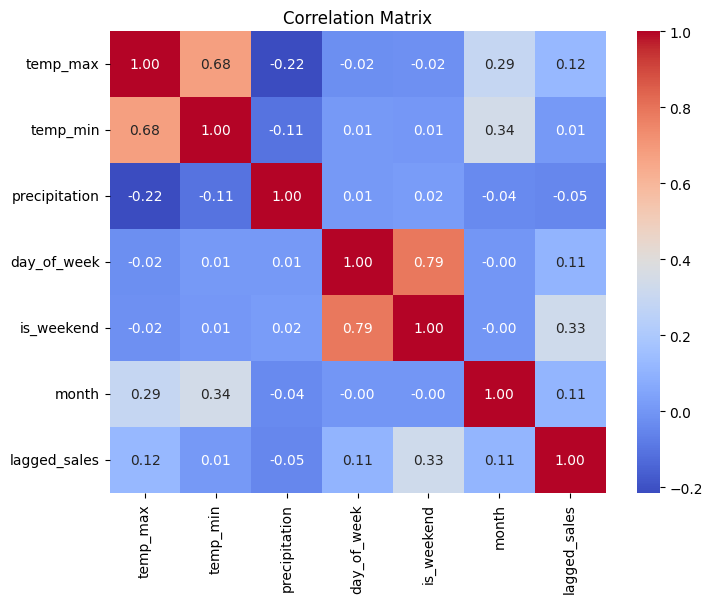

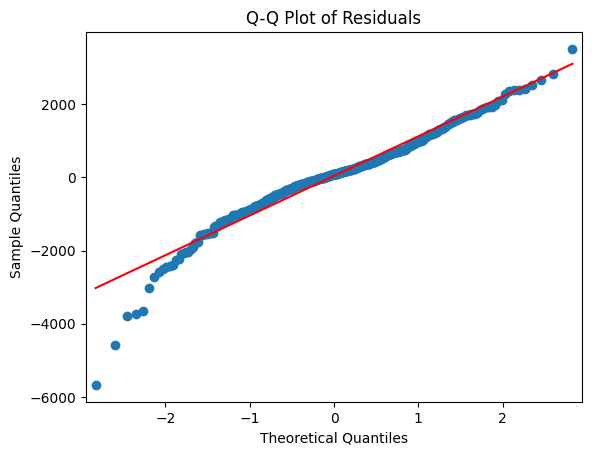

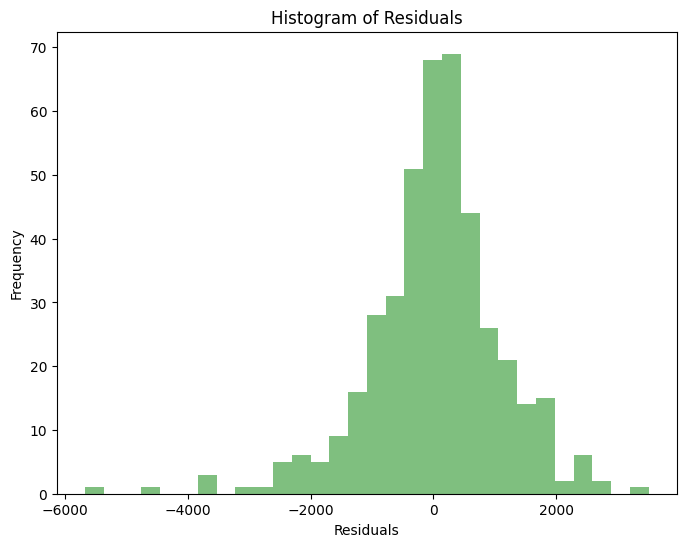


Shapiro-Wilk Test Statistic: 0.9574572849943033
Shapiro-Wilk Test p-value: 9.470867014300407e-10


In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Add time-based features to the merged_data
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek  # Monday=0, Sunday=6
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5, 6]).astype(int)  # 1 if weekend, else 0
merged_data['month'] = merged_data['date'].dt.month  # Month of the year

# Add lagged sales feature (e.g., sales from the previous day)
merged_data['lagged_sales'] = merged_data['AMOUNT'].shift(1)

# Drop rows with NaN values introduced by the lagged feature
merged_data = merged_data.dropna()

# Prepare the data for modeling
X = merged_data[['temp_max', 'temp_min', 'precipitation', 'day_of_week', 'is_weekend', 'month', 'lagged_sales']]
y = merged_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regressor Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='green')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.show()
# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='green', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='green', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()
# Check for multicollinearity using VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X_with_const = add_constant(X_train)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print("\nVIF Data:")
print(vif_data)
# Check for multicollinearity using correlation matrix
correlation_matrix = X.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)
# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
# Check for normality of residuals using Q-Q plot
import scipy.stats as stats
import statsmodels.api as sm
# Q-Q plot
sm.qqplot(y_pred - y_test, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(y_pred - y_test, bins=30, color='green', alpha=0.5)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()
# Check for normality of residuals using Shapiro-Wilk test
from scipy.stats import shapiro
# Perform Shapiro-Wilk test
shapiro_test = shapiro(y_pred - y_test)
print("\nShapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

# # Check for homoscedasticity using Breusch-Pagan test
# from statsmodels.stats.diagnostic import het_breuschpagan
# # Perform Breusch-Pagan test
# bp_test = het_breuschpagan(y_pred - y_test, X_with_const)
# bp_test_results = pd.DataFrame(bp_test, columns=['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value'])
# print("\nBreusch-Pagan Test Results:")
# print(bp_test_results)


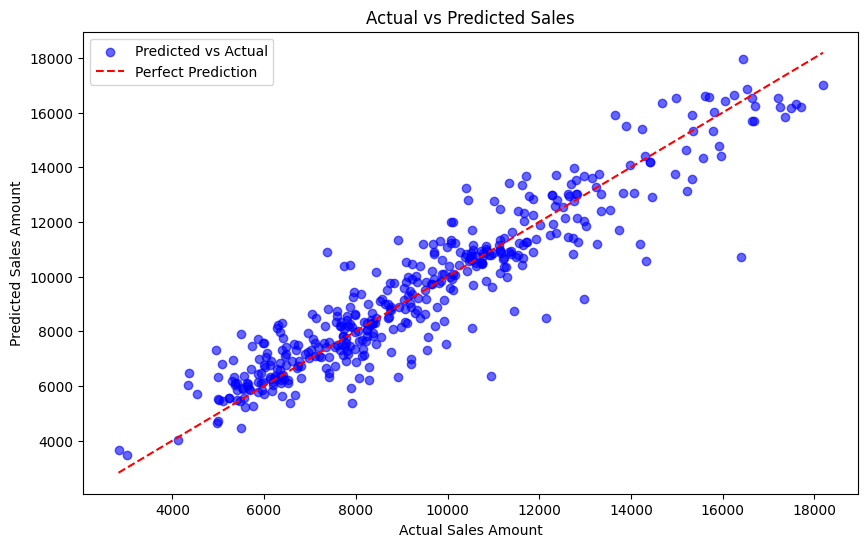

In [154]:
# Plot the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Sales Amount')
plt.ylabel('Predicted Sales Amount')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()

Let's find out what days of the week drive the most volume.
Copilot: Create a model to figure what days of the week drive the most volume.

Model Evaluation:
Mean Squared Error (MSE): 5669683.1696800785
R-squared (R2): 0.3884251381751065
Mean Absolute Error (MAE): 1942.733297555563

Coefficients:
         Day  Coefficient
0     Monday -1366.962858
1    Tuesday -1882.932889
2  Wednesday -1437.925193
3   Thursday -1265.850585
4     Friday   133.067739
5   Saturday  3084.558796
6     Sunday  2736.044989


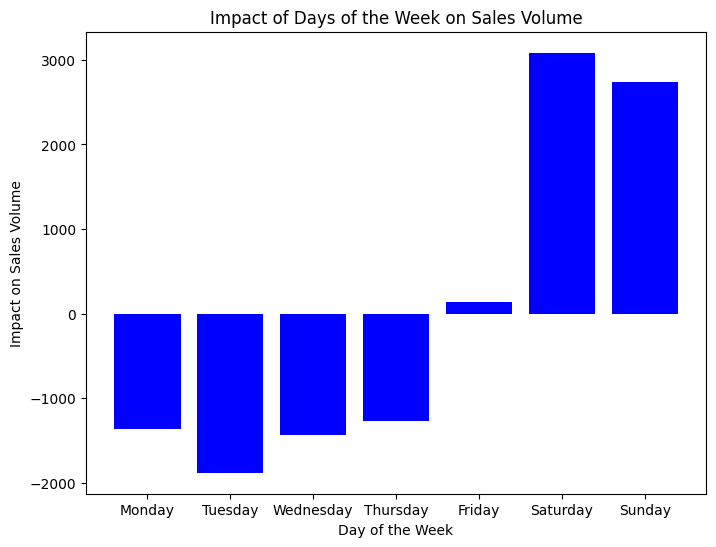

In [155]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Extract the day_of_week and sales amount
X = merged_data[['day_of_week']]
y = merged_data['AMOUNT']

# One-hot encode the day_of_week
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Display the coefficients for each day of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
coefficients = pd.DataFrame({'Day': days, 'Coefficient': model.coef_})
print("\nCoefficients:")
print(coefficients)

# Plot the coefficients
plt.figure(figsize=(8, 6))
plt.bar(coefficients['Day'], coefficients['Coefficient'], color='blue')
plt.xlabel("Day of the Week")
plt.ylabel("Impact on Sales Volume")
plt.title("Impact of Days of the Week on Sales Volume")
plt.show()

Paul - Now let's switch to specific product related data
Copilot: Create a model that checks the specific products in combined_grouped_data for sales related to the weather data

Create a model that will go through the combined sales data and determine which products sell the most by weather.

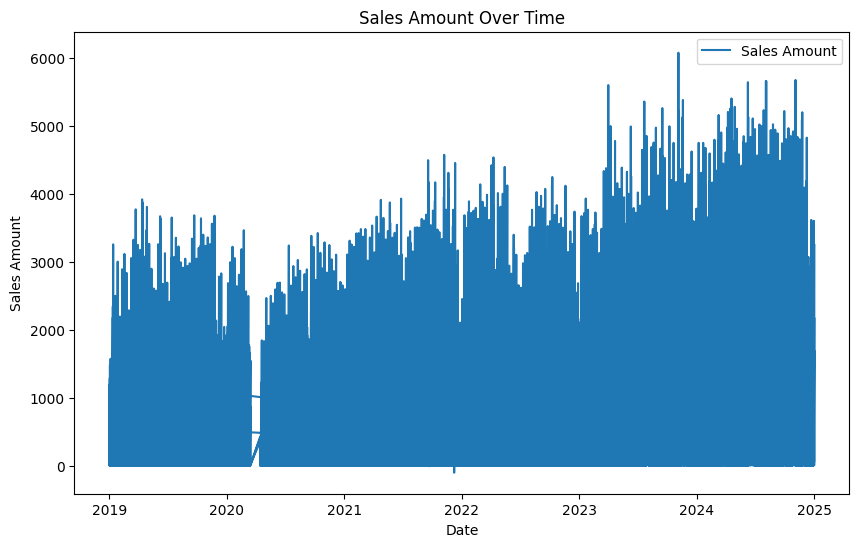

Random Forest Regressor Model Evaluation:
Mean Squared Error (MSE): 80735.15995617532
R-squared (R2): 0.8063889856996193
Mean Absolute Error (MAE): 137.50513328518824

Feature Importances:
                              Feature    Importance
16       Product_Retail Coffee Drinks  8.009409e-01
0                            temp_max  7.239622e-02
1                            temp_min  6.892177e-02
5       Product_Baked Goods-3rd party  2.336787e-02
2                       precipitation  1.949262e-02
14             Product_Prepared Foods  7.932425e-03
15              Product_Retail Coffee  5.396972e-03
6          Product_Baked Goods-Pantry  4.862308e-04
17  Product_Retail Packaged-3rd party  4.801049e-04
18     Product_Retail Packaged-Pantry  1.463250e-04
7                 Product_Beer & Wine  7.912155e-05
12                  Product_Ice Cream  5.868384e-05
13            Product_Other Beverages  5.227286e-05
19                 Product_Retail Tea  4.697121e-05
20          Product_Retail Tea 

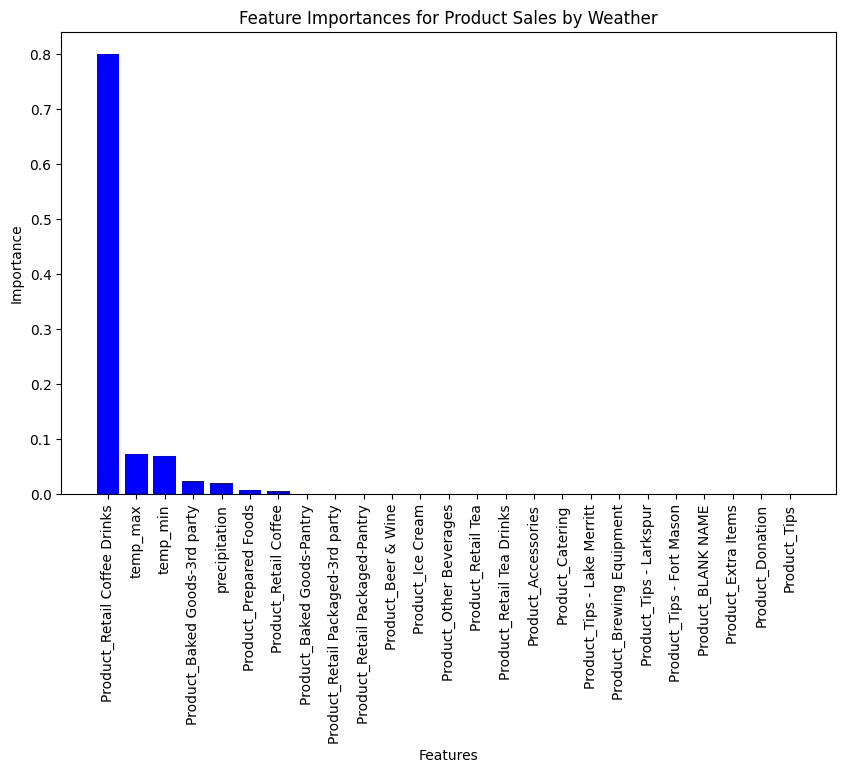

In [156]:
# Prepare the data
# Merge combined_sales_data with combined_weather_data on 'date'
sales_weather_data = combined_sales_data.merge(combined_weather_data, on='date')

# chart the sales_weather_data
plt.figure(figsize=(10, 6))
plt.plot(sales_weather_data['date'], sales_weather_data['AMOUNT'], label='Sales Amount')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Sales Amount Over Time')
plt.legend()
plt.show()


# One-hot encode the product categories (SD column)
sales_weather_data_encoded = pd.get_dummies(sales_weather_data, columns=['SD'], prefix='Product')

# Prepare features (weather data and product categories) and target (sales amount)
X = sales_weather_data_encoded[['temp_max', 'temp_min', 'precipitation'] + 
                                [col for col in sales_weather_data_encoded.columns if col.startswith('Product_')]]
y = sales_weather_data_encoded['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regressor Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Product Sales by Weather")
plt.xticks(rotation=90)
plt.show()

Let's narrow down into ice cream

Create a model that can predict Product_Ice Cream sales by weather

     LOCATION ID LOCATION NAME       date DAY OF WEEK   MSD         SD  \
11             6    Fort Mason 2019-01-02   Wednesday  FOOD  Ice Cream   
125            6    Fort Mason 2019-01-12    Saturday  FOOD  Ice Cream   
172            6    Fort Mason 2019-01-16   Wednesday  FOOD  Ice Cream   
197            6    Fort Mason 2019-01-18      Friday  FOOD  Ice Cream   
209            6    Fort Mason 2019-01-19    Saturday  FOOD  Ice Cream   

     AMOUNT  COMP AMOUNT  temp_max  temp_min  precipitation  
11      6.0          0.0      11.6       4.5            0.0  
125    17.5          0.0      14.3       9.6            4.3  
172     5.5          0.0      14.7      12.0           40.8  
197    11.0          0.0      14.8       9.6            0.2  
209    51.0          0.0      16.3      10.9            0.1  
Ice Cream Sales Prediction Model Evaluation:
Mean Squared Error (MSE): 202.4830443422806
R-squared (R2): -0.23653755780163843
Mean Absolute Error (MAE): 8.768947495468108

Feature Imp

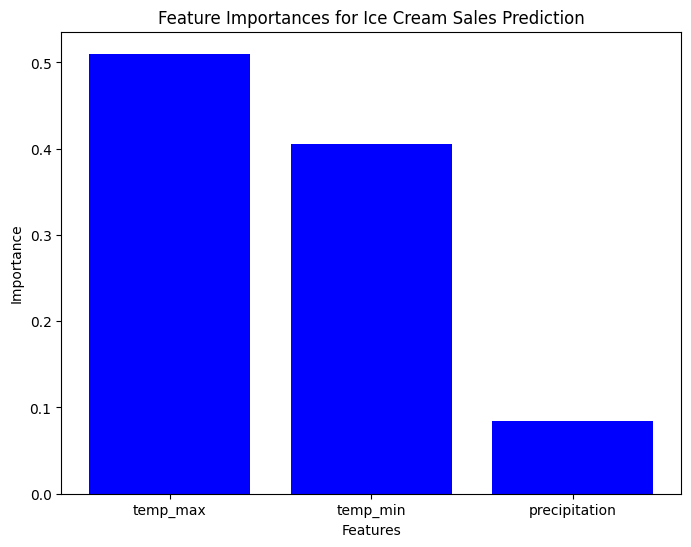

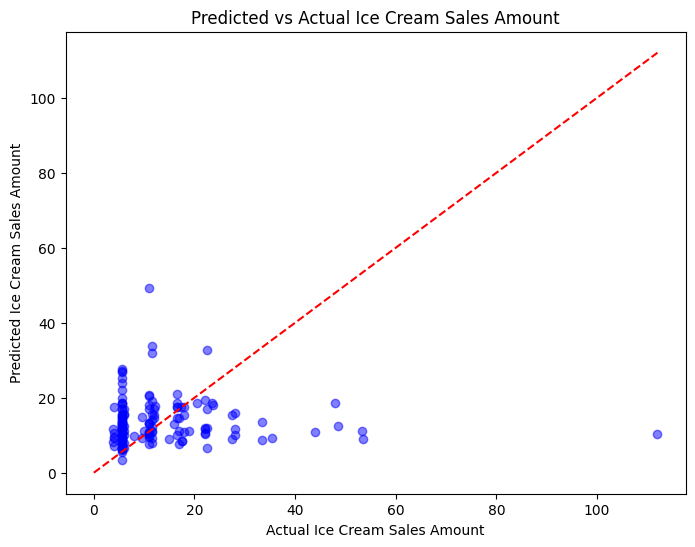

In [157]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Filter the data for Product_Ice Cream sales
ice_cream_data = sales_weather_data[sales_weather_data['SD'] == 'Ice Cream']
print(ice_cream_data.head())

# Prepare the features (weather data) and target (sales amount)
X = ice_cream_data[['temp_max', 'temp_min', 'precipitation']]
y = ice_cream_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
ice_cream_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
ice_cream_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ice_cream_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Ice Cream Sales Prediction Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ice_cream_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Ice Cream Sales Prediction")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Ice Cream Sales Amount")
plt.ylabel("Predicted Ice Cream Sales Amount")
plt.title("Predicted vs Actual Ice Cream Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Does weather affect any specific product at all?
Create a model that determines which product is affect by weather the most.

Product_AccessoriesPrediction Model Evaluation:
Mean Squared Error (MSE): 0.06350588900718596
R-squared (R2): -0.06818829691806716
Mean Absolute Error (MAE): 0.12248728954441339
Product_BLANK NAMEPrediction Model Evaluation:
Mean Squared Error (MSE): 0.0021907048293717322
R-squared (R2): -0.04497081562048311
Mean Absolute Error (MAE): 0.004606419874700361
Product_Baked Goods-3rd partyPrediction Model Evaluation:
Mean Squared Error (MSE): 0.10720858355026214
R-squared (R2): -0.08349578600669938
Mean Absolute Error (MAE): 0.20518937660749645
Product_Baked Goods-PantryPrediction Model Evaluation:
Mean Squared Error (MSE): 0.023366028619007814
R-squared (R2): 0.00707447418499374
Mean Absolute Error (MAE): 0.04470192526085515
Product_Beer & WinePrediction Model Evaluation:
Mean Squared Error (MSE): 0.03391477973078765
R-squared (R2): -0.04956595667084884
Mean Absolute Error (MAE): 0.06499914997333751
Product_Brewing EquipmentPrediction Model Evaluation:
Mean Squared Error (MSE): 0.007033967

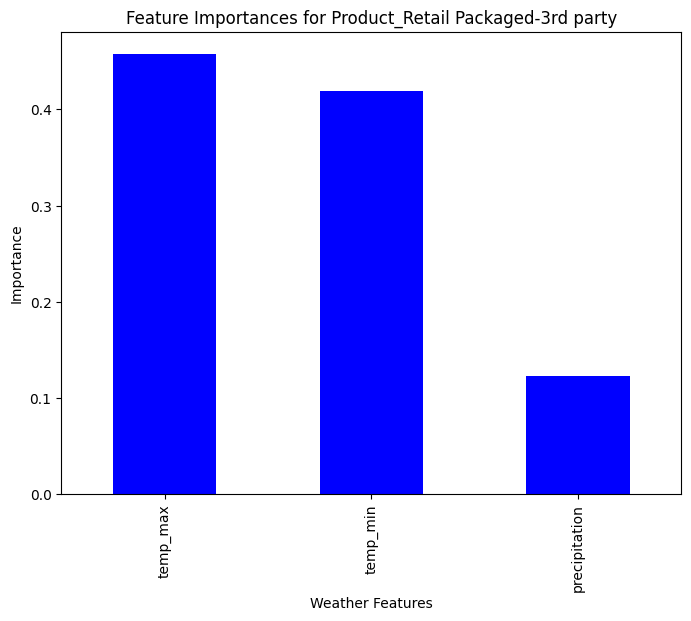

In [158]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

import matplotlib.pyplot as plt

# Prepare the data
# Merge combined_sales_data with combined_weather_data on 'date'
sales_weather_data = combined_sales_data.merge(combined_weather_data, on='date')

# One-hot encode the product categories (SD column)
sales_weather_data_encoded = pd.get_dummies(sales_weather_data, columns=['SD'], prefix='Product')

# Prepare features (weather data) and target (sales amount for each product)
X = sales_weather_data_encoded[['temp_max', 'temp_min', 'precipitation']]
product_columns = [col for col in sales_weather_data_encoded.columns if col.startswith('Product_')]

# Remove Product_Catering from the product columns
product_columns.remove('Product_Catering')

# Store feature importance results
product_importances = {}

# Loop through each product and train a model
for product in product_columns:
    y = sales_weather_data_encoded[product].astype(int)  # Binary target: 1 if product sold, else 0

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit the model to the training data
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(product + "Prediction Model Evaluation:")
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Error (MAE):", mae)


    # Store feature importances
    product_importances[product] = rf_model.feature_importances_

# Convert feature importances to a DataFrame
importance_df = pd.DataFrame(product_importances, index=['temp_max', 'temp_min', 'precipitation']).T

# Find the product most affected by weather
most_affected_product = importance_df.sum(axis=1).idxmax()
print(f"The product most affected by weather is: {most_affected_product}")

# Plot the feature importances for the most affected product
plt.figure(figsize=(8, 6))
importance_df.loc[most_affected_product].plot(kind='bar', color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title(f"Feature Importances for {most_affected_product}")
plt.show()


Now that we have our most effect product explain how the weather effects it.

Show how the weather effects most_affected_product (temperature or precipitation)

Model Evaluation for Product_Retail Packaged-3rd party:
Mean Squared Error (MSE): 15955.617277278012
R-squared (R2): -0.2682640777091425
Mean Absolute Error (MAE): 93.78566216844871

Feature Importances:
         Feature  Importance
0       temp_max    0.440344
1       temp_min    0.440136
2  precipitation    0.119520


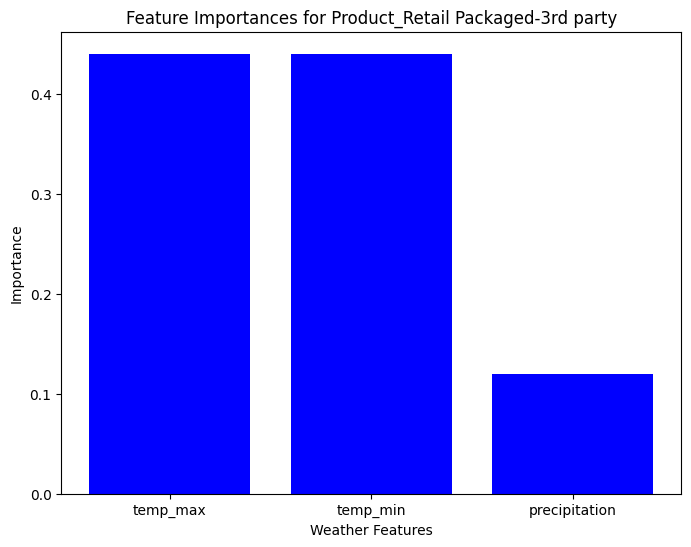

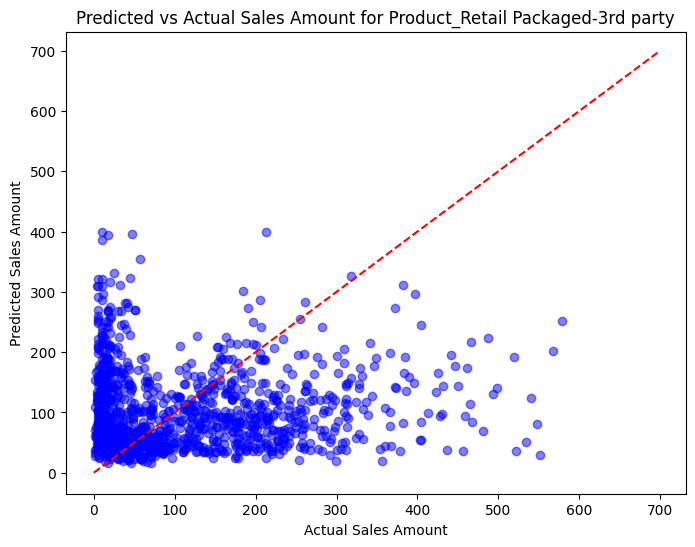

In [159]:
# Filter data for the most affected product
product_data = sales_weather_data[sales_weather_data['SD'] == 'Retail Packaged-3rd party']

# Prepare features (weather data) and target (sales amount)
X = product_data[['temp_max', 'temp_min', 'precipitation']]
y = product_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
product_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
product_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = product_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Model Evaluation for {most_affected_product}:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': product_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title(f"Feature Importances for {most_affected_product}")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title(f"Predicted vs Actual Sales Amount for {most_affected_product}")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Now it makes sense. We need to separate weekend sales from weekday sales (or run a model for day of week)
Create a model that can predict product sales by weather data but only use weekend sales.

    LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
35            6    Fort Mason 2019-01-05    Saturday  COFFEE & NA BEV   
36            6    Fort Mason 2019-01-05    Saturday             FOOD   
37            6    Fort Mason 2019-01-05    Saturday           RETAIL   
38            6    Fort Mason 2019-01-05    Saturday             FOOD   
39            6    Fort Mason 2019-01-05    Saturday             FOOD   

                           SD   AMOUNT  COMP AMOUNT  temp_max  temp_min  \
35       Retail Coffee Drinks  1020.72        16.33      12.7       9.4   
36  Retail Packaged-3rd party   259.51         2.24      12.7       9.4   
37              Retail Coffee   174.95         0.00      12.7       9.4   
38      Baked Goods-3rd party   174.75         0.00      12.7       9.4   
39         Baked Goods-Pantry   137.88         1.12      12.7       9.4   

    precipitation  
35            5.8  
36            5.8  
37            5.8  
38            5.8  
39        

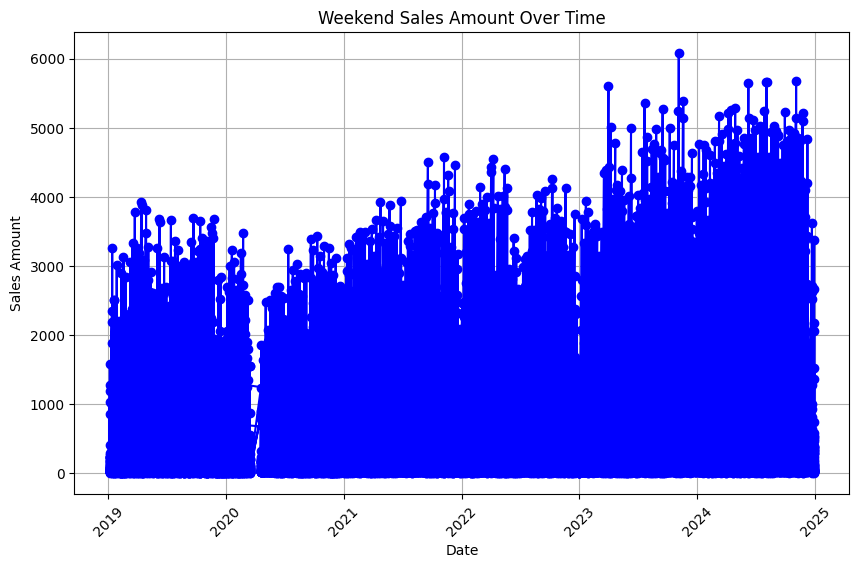

   LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
0            6    Fort Mason 2019-01-02   Wednesday  COFFEE & NA BEV   
1            6    Fort Mason 2019-01-02   Wednesday             FOOD   
2            6    Fort Mason 2019-01-02   Wednesday             FOOD   
3            6    Fort Mason 2019-01-02   Wednesday           RETAIL   
4            6    Fort Mason 2019-01-02   Wednesday           RETAIL   

                          SD   AMOUNT  COMP AMOUNT  temp_max  temp_min  \
0       Retail Coffee Drinks  1191.81        10.59      11.6       4.5   
1         Baked Goods-Pantry   209.00         0.00      11.6       4.5   
2  Retail Packaged-3rd party   196.26         2.24      11.6       4.5   
3                Accessories   196.00         5.00      11.6       4.5   
4              Retail Coffee   158.00         0.00      11.6       4.5   

   precipitation  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


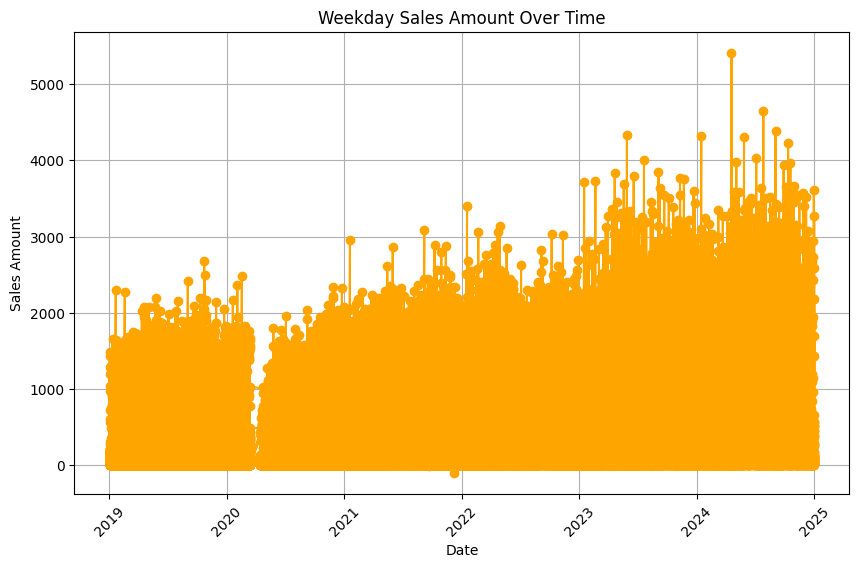

In [160]:
# Filter the data for weekend sales only
weekend_data = sales_weather_data[sales_weather_data['DAY OF WEEK'].isin(['Saturday', 'Sunday'])]
print(weekend_data.head())

# chart the weekend sales data
plt.figure(figsize=(10, 6))
plt.plot(weekend_data['date'], weekend_data['AMOUNT'], marker='o', linestyle='-', color='blue')
plt.title('Weekend Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Filter the data for weekday sales only
weekday_data = sales_weather_data[~sales_weather_data['DAY OF WEEK'].isin(['Saturday', 'Sunday'])]
print(weekday_data.head())
# chart the weekday sales data
# chart the weekday sales data
plt.figure(figsize=(10, 6))
plt.plot(weekday_data['date'], weekday_data['AMOUNT'], marker='o', linestyle='-', color='orange')
plt.title('Weekday Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()


        date      AMOUNT
0 2019-01-05   5836.6798
1 2019-01-06   5163.5300
2 2019-01-12  10117.3100
3 2019-01-13   9615.3601
4 2019-01-19  10170.0199


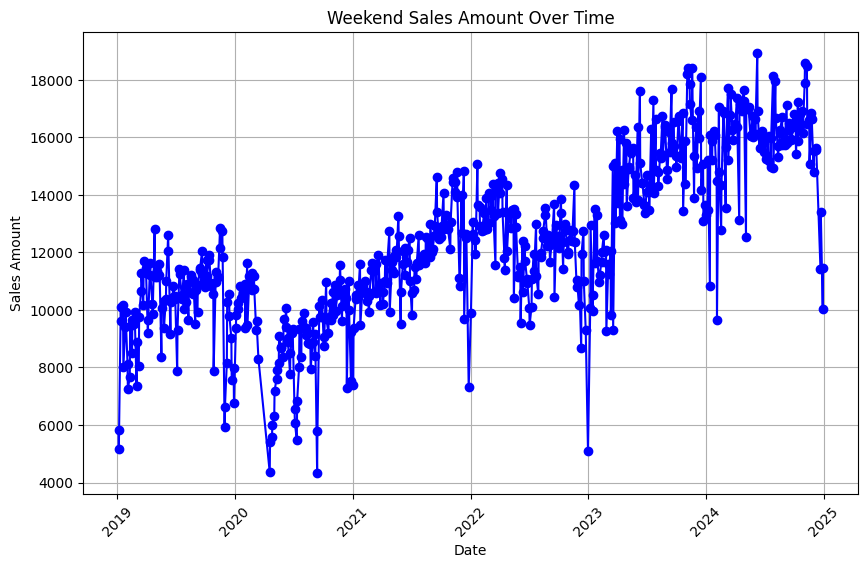

        date     AMOUNT
0 2019-01-02  5359.4600
1 2019-01-03  5226.5299
2 2019-01-04  5615.5300
3 2019-01-07  4376.4300
4 2019-01-08  6144.3300


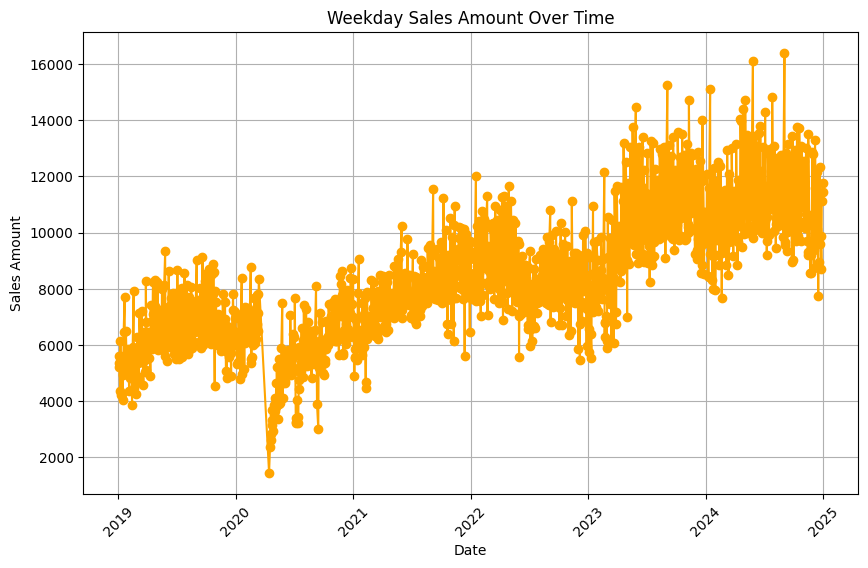

In [161]:
# Group the data by 'date' and sum the 'AMOUNT'
combined_weekend_totals = weekend_data.groupby('date')['AMOUNT'].sum()
combined_weekend_totals = combined_weekend_totals.reset_index()
print(combined_weekend_totals.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(combined_weekend_totals['date'], combined_weekend_totals['AMOUNT'], marker='o', linestyle='-', color='blue')
plt.title('Weekend Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()



combined_weekday_totals = weekday_data.groupby('date')['AMOUNT'].sum()
combined_weekday_totals = combined_weekday_totals.reset_index()
print(combined_weekday_totals.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(combined_weekday_totals['date'], combined_weekday_totals['AMOUNT'], marker='o', linestyle='-', color='orange')
plt.title('Weekday Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.grid()
plt.show()



Now split the weather into weekend and weekday

C:\Users\Paul\AppData\Local\Temp\ipykernel_25736\1806648882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_weather_data['day_of_week'] = combined_weather_data['date'].dt.dayofweek  # Monday=0, Sunday=6


Weekend Weather Data:
         date  temp_max  temp_min  precipitation  day_of_week
4  2019-01-05      12.7       9.4            5.8            5
5  2019-01-06      13.4       8.5           36.5            6
11 2019-01-12      14.3       9.6            4.3            5
12 2019-01-13      15.0       8.7            0.0            6
18 2019-01-19      16.3      10.9            0.1            5

Weekday Weather Data:
        date  temp_max  temp_min  precipitation  day_of_week
1 2019-01-02      11.6       4.5            0.0            2
2 2019-01-03      10.9       4.6            0.0            3
3 2019-01-04      12.0       4.9            0.0            4
6 2019-01-07      12.8       8.3            0.1            0
7 2019-01-08      13.7      10.4            3.2            1


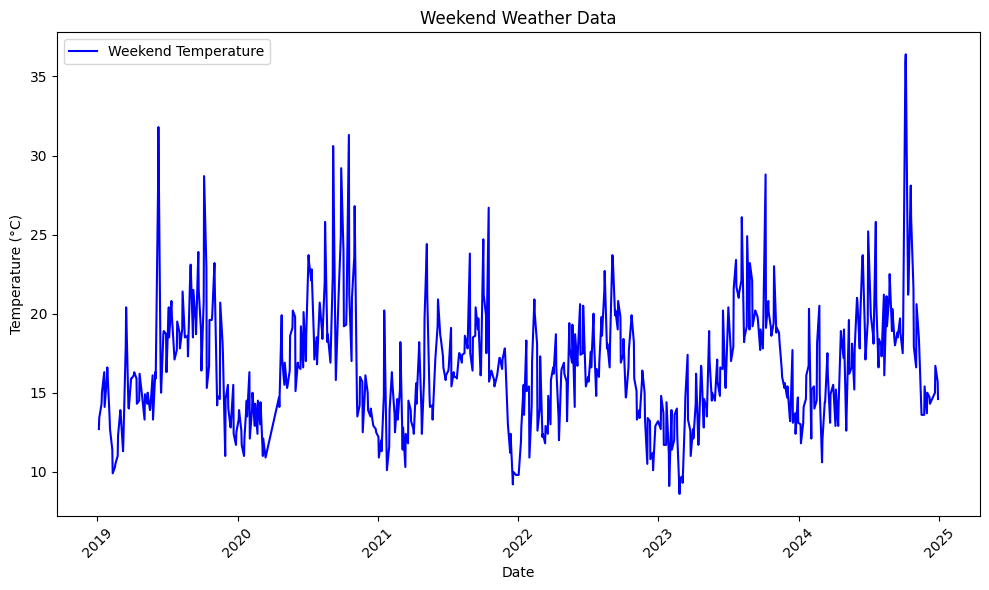

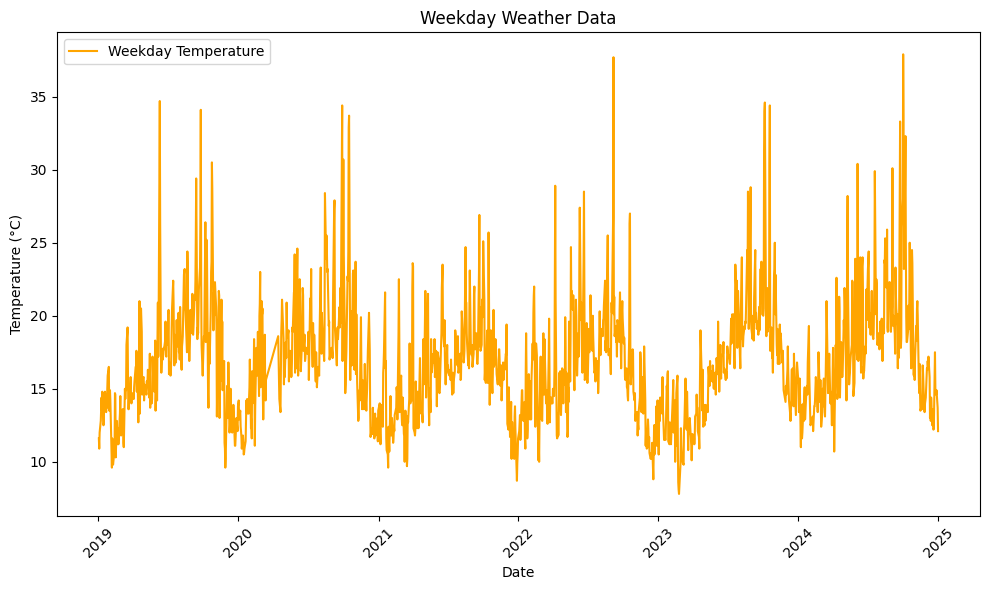

In [162]:
# Add a 'day_of_week' column to the weather data
combined_weather_data['day_of_week'] = combined_weather_data['date'].dt.dayofweek  # Monday=0, Sunday=6

# Split the weather data into weekend and weekday
weekend_weather = combined_weather_data[combined_weather_data['day_of_week'].isin([5, 6])]  # Saturday and Sunday
weekday_weather = combined_weather_data[~combined_weather_data['day_of_week'].isin([5, 6])]  # Monday to Friday

# Preview the data
print("Weekend Weather Data:")
print(weekend_weather.head())

print("\nWeekday Weather Data:")
print(weekday_weather.head())

# Chart the weekend weather data
plt.figure(figsize=(10, 6)) 
plt.plot(weekend_weather['date'], weekend_weather['temp_max'], label='Weekend Temperature', color='blue')
plt.title('Weekend Weather Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Chart the weekday weather data
plt.figure(figsize=(10, 6))
plt.plot(weekday_weather['date'], weekday_weather['temp_max'], label='Weekday Temperature', color='orange')
plt.title('Weekday Weather Data')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Let's see if a model can predict anything with just weekend sales data and weekend weather data

Copilit: Create an XBGoot Regression model that looks at the weekend sales data to see the effects of sales by the weekend weather data. Use standard scaling.

Combined Weekend Data:
   LOCATION ID LOCATION NAME       date DAY OF WEEK              MSD  \
0            6    Fort Mason 2019-01-05    Saturday  COFFEE & NA BEV   
1            6    Fort Mason 2019-01-05    Saturday             FOOD   
2            6    Fort Mason 2019-01-05    Saturday           RETAIL   
3            6    Fort Mason 2019-01-05    Saturday             FOOD   
4            6    Fort Mason 2019-01-05    Saturday             FOOD   

                          SD   AMOUNT  COMP AMOUNT  temp_max_x  temp_min_x  \
0       Retail Coffee Drinks  1020.72        16.33        12.7         9.4   
1  Retail Packaged-3rd party   259.51         2.24        12.7         9.4   
2              Retail Coffee   174.95         0.00        12.7         9.4   
3      Baked Goods-3rd party   174.75         0.00        12.7         9.4   
4         Baked Goods-Pantry   137.88         1.12        12.7         9.4   

   precipitation_x  temp_max_y  temp_min_y  precipitation_y  day_of_week  


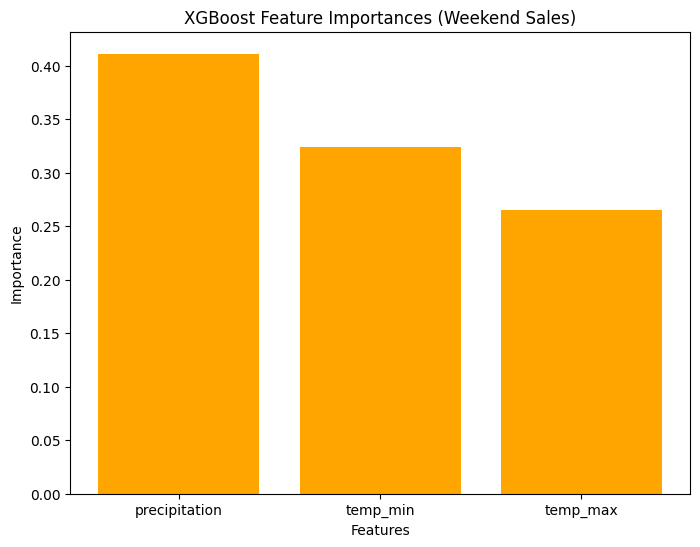

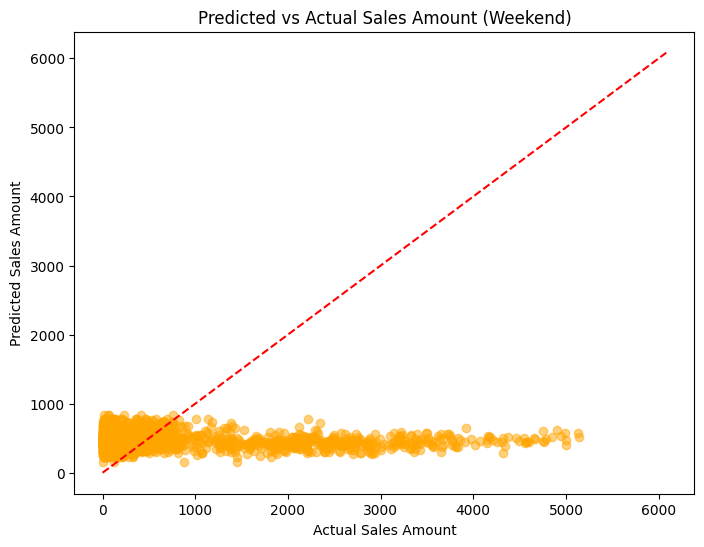

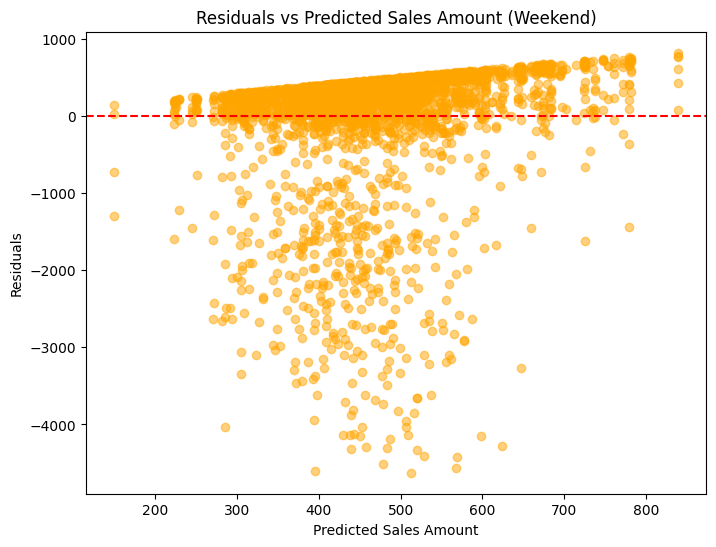

In [163]:
# combine the weekend weather data with the weekend sales data
combined_weekend_data = weekend_data.merge(weekend_weather, on='date', how='left')
# Preview the combined data
print("Combined Weekend Data:")
print(combined_weekend_data.head())

 # Save to CSV
#combined_weekend_data.to_csv("C:\\Dev\\School\\SFU\\Courses\\Bus774-AIforBusiness\\GroupProject\\Group4data\\combined_weather_sales_weekend.csv", index=False)

# # Remove all rows where SD is not Ice Cream
# combined_weekend_data_ice_cream = combined_weekend_data[combined_weekend_data['SD'] == 'Ice Cream']


# combined_weekend_data_daily_sales = combined_weekend_data.groupby('date')['AMOUNT'].sum()
# # Preview the combined daily weekend sales data
# print("Combined Weekend Daily Sales Data:")
# print(combined_weekend_data_daily_sales.head())


# Prepare the features (weekend weather data) and target (weekend sales amount)
X = combined_weekend_data[['temp_max_x', 'temp_min_x', 'precipitation_x']]
y = combined_weekend_data['AMOUNT']

# Apply standard scaling to the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Model Evaluation (Weekend Sales):")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': ['temp_max', 'temp_min', 'precipitation'],
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='orange')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances (Weekend Sales)")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount (Weekend)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='orange', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount (Weekend)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

THAT ABOVE STUFF IS BROKEN!!! - IGNORE (or fix)

Weekend Sales Prediction Model Evaluation:
Mean Squared Error (MSE): 772225.907713908
R-squared (R2): -0.0636457193802007
Mean Absolute Error (MAE): 538.1551327059586

Feature Importances:
         Feature  Importance
1       temp_min    0.443832
0       temp_max    0.436895
2  precipitation    0.119273


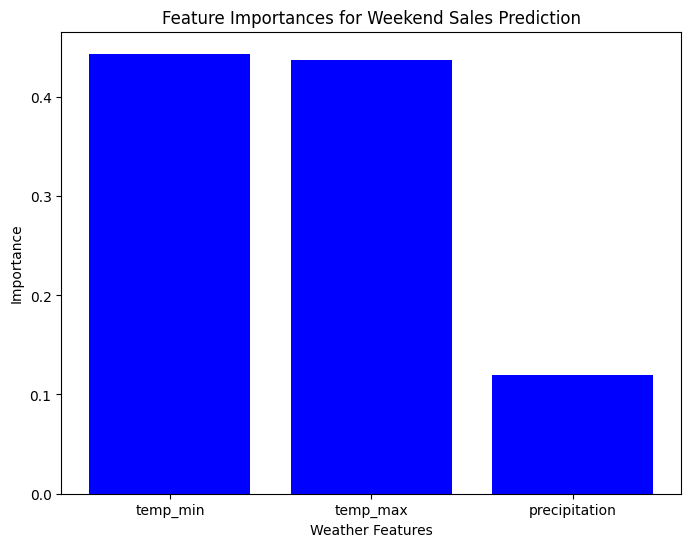

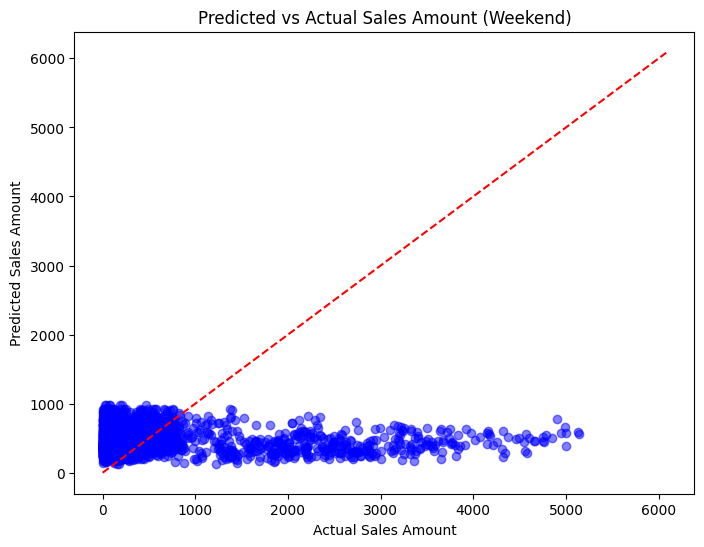

In [164]:
# Prepare the features (weather data) and target (sales amount)
X = weekend_data[['temp_max', 'temp_min', 'precipitation']]
y = weekend_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
weekend_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
weekend_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = weekend_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Weekend Sales Prediction Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': weekend_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Weekend Sales Prediction")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount (Weekend)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Ok - we know weekend sales and weekday sales are different, we need to train a model with that understanding

Weekday Sales Prediction Model Evaluation:
Mean Squared Error (MSE): 334927.4428858976
R-squared (R2): -0.05244364697362469
Mean Absolute Error (MAE): 362.73750102757685

Feature Importances:
         Feature  Importance
0       temp_max    0.449098
1       temp_min    0.438994
2  precipitation    0.111908


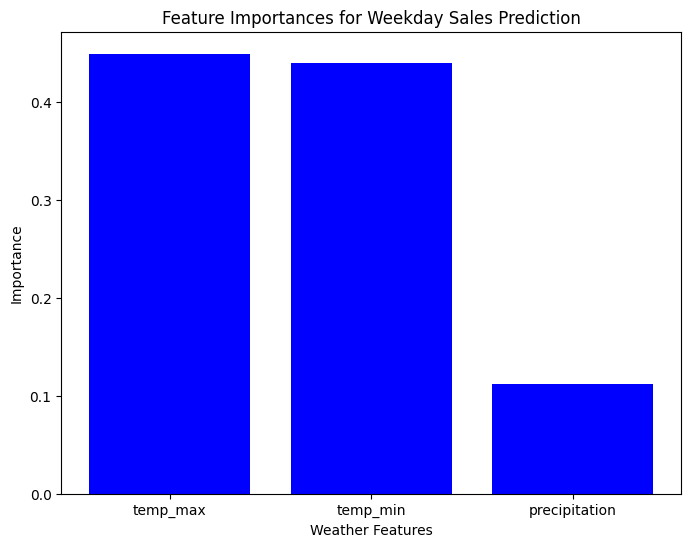

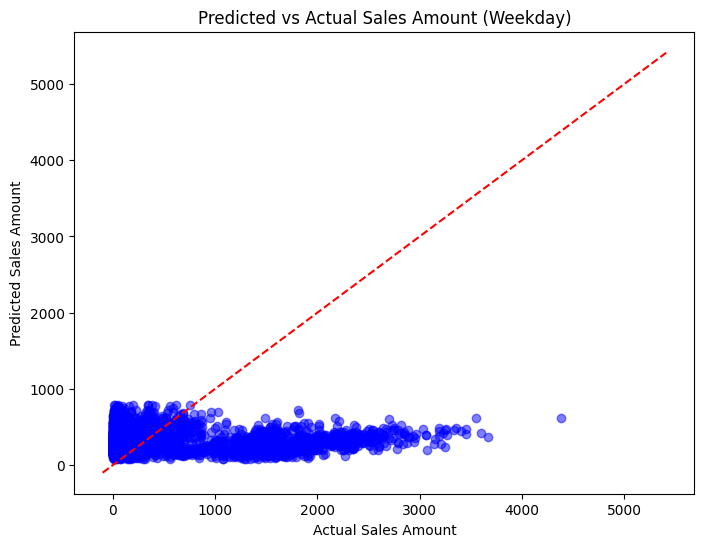

In [165]:
# # Filter the data for weekend sales only
# weekday_data = sales_weather_data[sales_weather_data['DAY OF WEEK'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
# print(weekend_data.head())

# Prepare the features (weather data) and target (sales amount)
X = weekday_data[['temp_max', 'temp_min', 'precipitation']]
y = weekday_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
weekday_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
weekday_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = weekday_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Weekday Sales Prediction Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': weekday_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Weekday Sales Prediction")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount (Weekday)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Weekend Ice Cream Sales Prediction Model Evaluation:
Mean Squared Error (MSE): 302.1067360342137
R-squared (R2): -0.9768822109642907
Mean Absolute Error (MAE): 11.567699606078012

Feature Importances:
         Feature  Importance
0       temp_max    0.538454
1       temp_min    0.270114
2  precipitation    0.191432


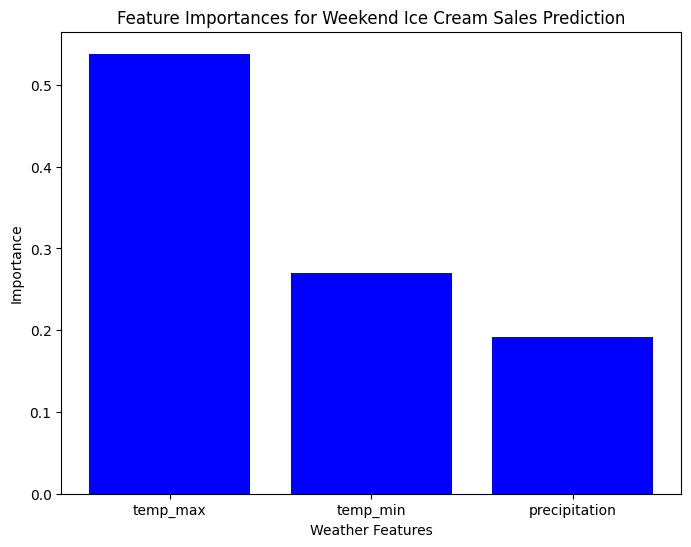

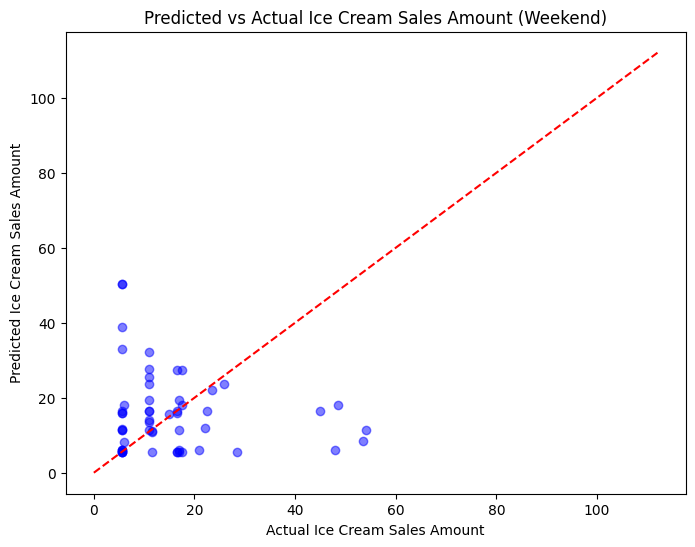

In [166]:
# Filter the data for weekend ice cream sales
weekend_ice_cream_data = weekend_data[weekend_data['SD'] == 'Ice Cream']

# Prepare the features (weather data) and target (sales amount)
X = weekend_ice_cream_data[['temp_max', 'temp_min', 'precipitation']]
#X = weekend_ice_cream_data[['temp_max']]
y = weekend_ice_cream_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
#ice_cream_weekend_model = RandomForestRegressor(n_estimators=100, random_state=42)
ice_cream_weekend_model = XGBRegressor(n_estimators=100, random_state=42)


# Fit the model to the training data
ice_cream_weekend_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ice_cream_weekend_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Weekend Ice Cream Sales Prediction Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ice_cream_weekend_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Weekend Ice Cream Sales Prediction")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Ice Cream Sales Amount")
plt.ylabel("Predicted Ice Cream Sales Amount")
plt.title("Predicted vs Actual Ice Cream Sales Amount (Weekend)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Summer Weekend Ice Cream Data:
      LOCATION ID LOCATION NAME       date DAY OF WEEK   MSD         SD  \
1843            6    Fort Mason 2019-06-01    Saturday  FOOD  Ice Cream   
1855            6    Fort Mason 2019-06-02      Sunday  FOOD  Ice Cream   
1930            6    Fort Mason 2019-06-08    Saturday  FOOD  Ice Cream   
1942            6    Fort Mason 2019-06-09      Sunday  FOOD  Ice Cream   
2019            6    Fort Mason 2019-06-15    Saturday  FOOD  Ice Cream   

      AMOUNT  COMP AMOUNT  temp_max  temp_min  precipitation  
1843    16.5          0.0      16.3      11.5            0.0  
1855     5.5          0.0      15.9      12.2            0.0  
1930   112.0          0.0      27.7      15.2            0.0  
1942    94.5          0.0      31.8      15.5            0.0  
2019     5.5          0.0      15.9      12.5            0.0  
Number of records: 72
Summer Weekend Ice Cream Sales Prediction Model Evaluation:
Mean Squared Error (MSE): 1040.4071909965041
R-squared (R2

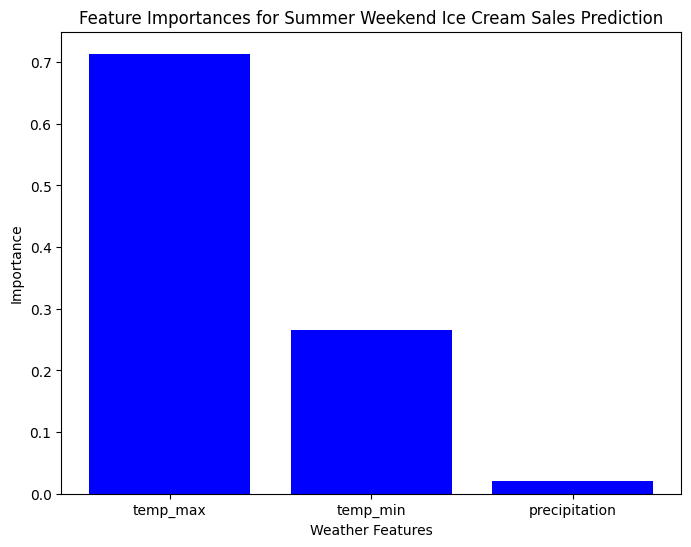

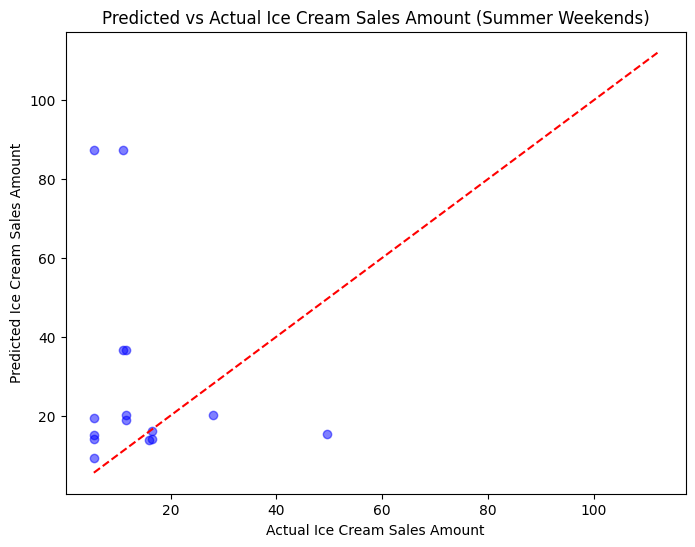

In [167]:
# Filter the data for weekends and summer months (June, July, August)
summer_weekend_ice_cream_data = weekend_ice_cream_data[
    weekend_ice_cream_data['date'].dt.month.isin([6, 7, 8])
]

# Preview the summer weekend ice cream data
print("Summer Weekend Ice Cream Data:")
print(summer_weekend_ice_cream_data.head())
# and length of the data
print("Number of records:", len(summer_weekend_ice_cream_data))

# Prepare the features (weather data) and target (sales amount)
X = summer_weekend_ice_cream_data[['temp_max', 'temp_min', 'precipitation']]
y = summer_weekend_ice_cream_data['AMOUNT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
summer_ice_cream_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
summer_ice_cream_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = summer_ice_cream_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Summer Weekend Ice Cream Sales Prediction Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': summer_ice_cream_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Weather Features")
plt.ylabel("Importance")
plt.title("Feature Importances for Summer Weekend Ice Cream Sales Prediction")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Ice Cream Sales Amount")
plt.ylabel("Predicted Ice Cream Sales Amount")
plt.title("Predicted vs Actual Ice Cream Sales Amount (Summer Weekends)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

Last try for weather theory, XGBoost on time filtered data (weekends vs weekdays, summer months) - FIXED THE MERGED DATA AT THIS POINT (Ignore the previous attempt)

Weekend Merged Data:
         date  temp_max  temp_min  precipitation      AMOUNT  day_of_week  \
4  2019-01-05      12.7       9.4            5.8   5836.6798            5   
5  2019-01-06      13.4       8.5           36.5   5163.5300            6   
11 2019-01-12      14.3       9.6            4.3  10117.3100            5   
12 2019-01-13      15.0       8.7            0.0   9615.3601            6   
18 2019-01-19      16.3      10.9            0.1  10170.0199            5   

    is_weekend  month  lagged_sales  
4            1      1     5615.5300  
5            1      1     5836.6798  
11           1      1     5587.1100  
12           1      1    10117.3100  
18           1      1     6466.5201  
Number of records: 610
XGBoost Model Evaluation:
Mean Squared Error (MSE): 8525795.541038726
R-squared (R2): -0.3003948258847169
Mean Absolute Error (MAE): 2429.1298204213626

Feature Importances:
         Feature  Importance
2  precipitation    0.450873
1       temp_min    0.288419
0   

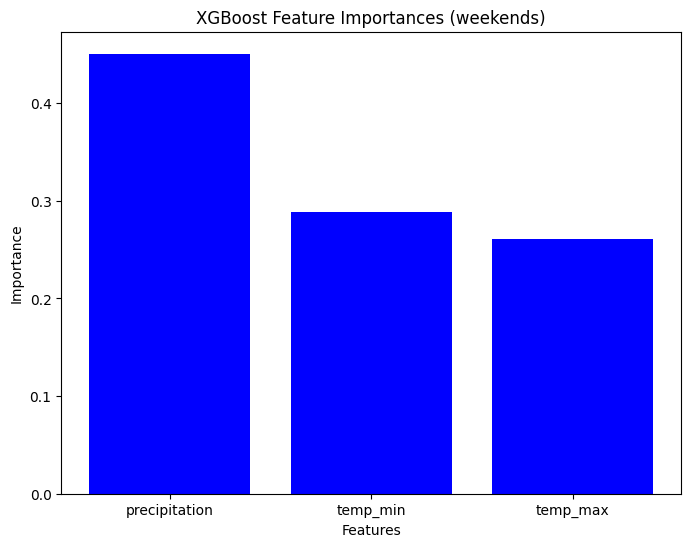

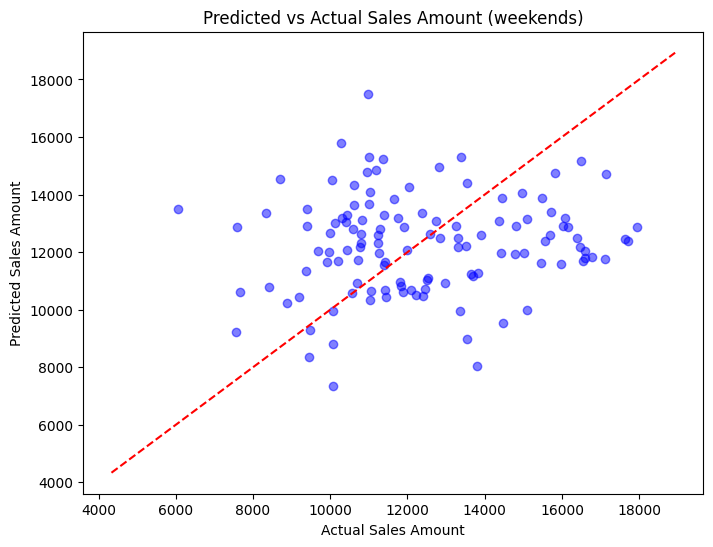

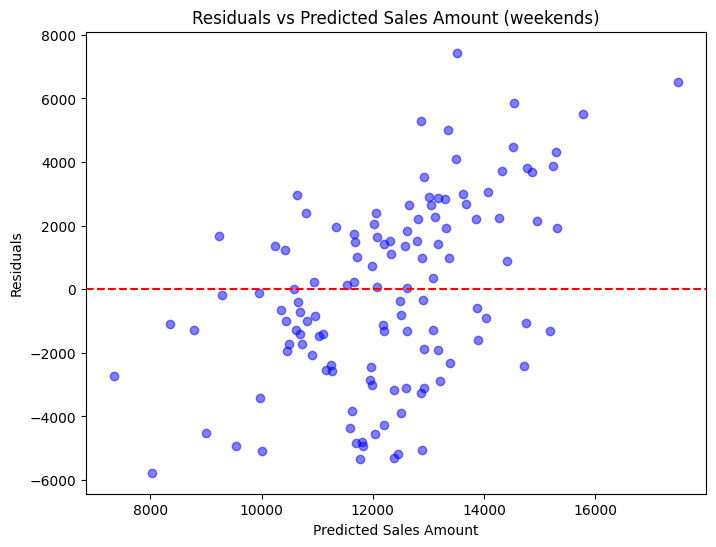

In [168]:
# # Prepare the data for modeling
# X = weekend_data[['temp_max', 'temp_min', 'precipitation']]
# y = weekend_data['AMOUNT']

# Separate weekends from weekdays from the mergded data
weekend_merged_data = merged_data[merged_data['day_of_week'].isin([5, 6])]  # Saturday and Sunday
weekday_merged_data = merged_data[~merged_data['day_of_week'].isin([5, 6])]  # Monday to Friday

# Preview the weekend merged data
print("Weekend Merged Data:")
print(weekend_merged_data.head())
# and length of the data
print("Number of records:", len(weekend_merged_data))

# Prepare the data for modeling
X = weekend_merged_data[['temp_max', 'temp_min', 'precipitation']]
y = weekend_merged_data['AMOUNT']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='blue')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances (weekends)")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount (weekends)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='blue', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount (weekends)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

XBoost (standard scalar) for weekday

Weekday Merged Data:
        date  temp_max  temp_min  precipitation     AMOUNT  day_of_week  \
2 2019-01-03      10.9       4.6            0.0  5226.5299            3   
3 2019-01-04      12.0       4.9            0.0  5615.5300            4   
6 2019-01-07      12.8       8.3            0.1  4376.4300            0   
7 2019-01-08      13.7      10.4            3.2  6144.3300            1   
8 2019-01-09      14.4      10.2            5.2  4207.8601            2   

   is_weekend  month  lagged_sales  
2           0      1     5359.4600  
3           0      1     5226.5299  
6           0      1     5163.5300  
7           0      1     4376.4300  
8           0      1     6144.3300  
Number of records: 1519
XGBoost Model Evaluation:
Mean Squared Error (MSE): 5552702.613495928
R-squared (R2): -0.01998621003637191
Mean Absolute Error (MAE): 1881.3493676398027

Feature Importances:
         Feature  Importance
0       temp_max    0.359297
1       temp_min    0.329296
2  precipitation    

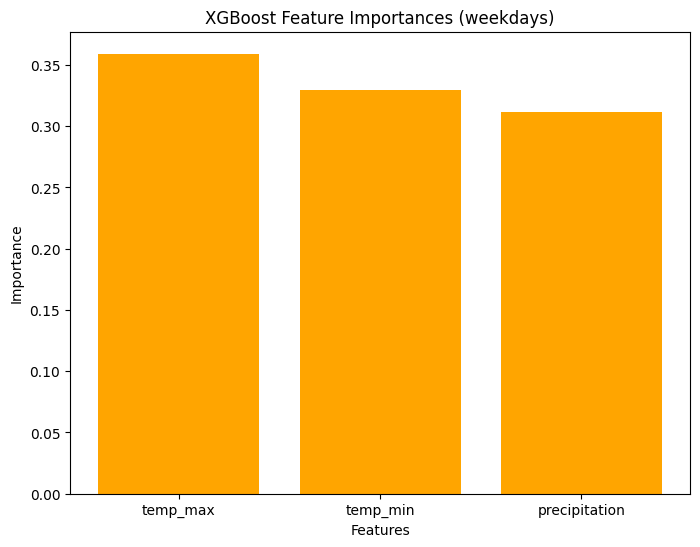

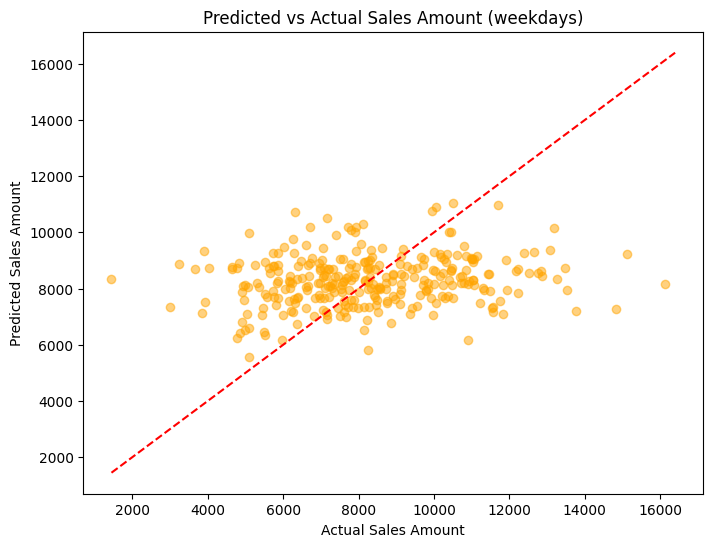

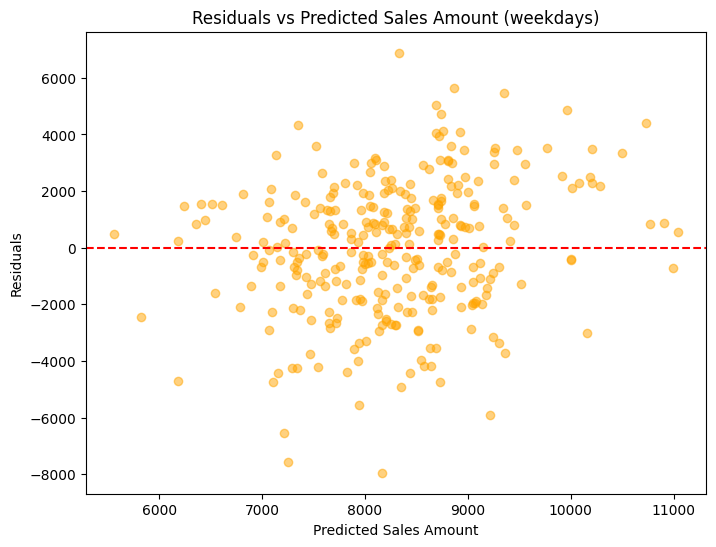

In [169]:
# Prepare the data for modeling
X = weekday_merged_data[['temp_max', 'temp_min', 'precipitation']]
y = weekday_merged_data['AMOUNT']

# Preview the weekend merged data
print("Weekday Merged Data:")
print(weekday_merged_data.head())
# and length of the data
print("Number of records:", len(weekday_merged_data))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='orange')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances (weekdays)")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.5)
plt.xlabel("Actual Sales Amount")
plt.ylabel("Predicted Sales Amount")
plt.title("Predicted vs Actual Sales Amount (weekdays)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()

# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='orange', alpha=0.5)
plt.xlabel("Predicted Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Sales Amount (weekdays)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

Now that we've fixed combined weekend/weakday sales, take one last try of getting the weekend data vs weekday data for ice cream product sales (I need the comined daily sales data - not the product data)

Top Ice Cream sales data:
      LOCATION ID LOCATION NAME       date DAY OF WEEK   MSD         SD  \
1930            6    Fort Mason 2019-06-08    Saturday  FOOD  Ice Cream   
1942            6    Fort Mason 2019-06-09      Sunday  FOOD  Ice Cream   
2523            6    Fort Mason 2019-07-27    Saturday  FOOD  Ice Cream   
3216            6    Fort Mason 2019-09-21    Saturday  FOOD  Ice Cream   
1420            6    Fort Mason 2019-04-28      Sunday  FOOD  Ice Cream   

      AMOUNT  COMP AMOUNT  temp_max  temp_min  precipitation  
1930   112.0          0.0      27.7      15.2            0.0  
1942    94.5          0.0      31.8      15.5            0.0  
2523    74.0          0.0      17.7      14.0            0.0  
3216    66.0          0.0      23.9      14.5            0.0  
1420    54.0          0.0      14.7      11.0            0.0  
Top days with the highest Ice Cream amounts:
           date  AMOUNT
1930 2019-06-08   112.0
1942 2019-06-09    94.5
2523 2019-07-27    74.0
3216

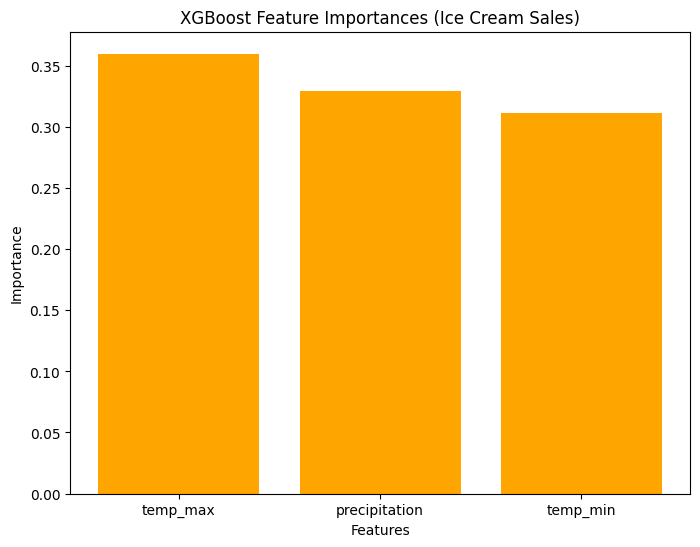

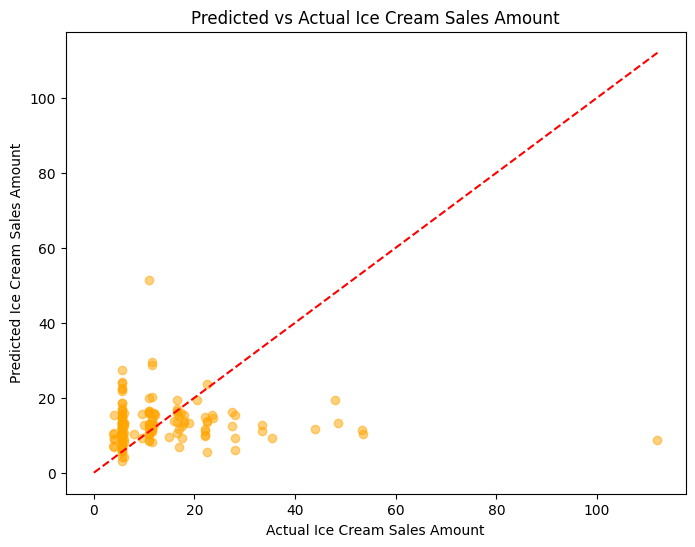

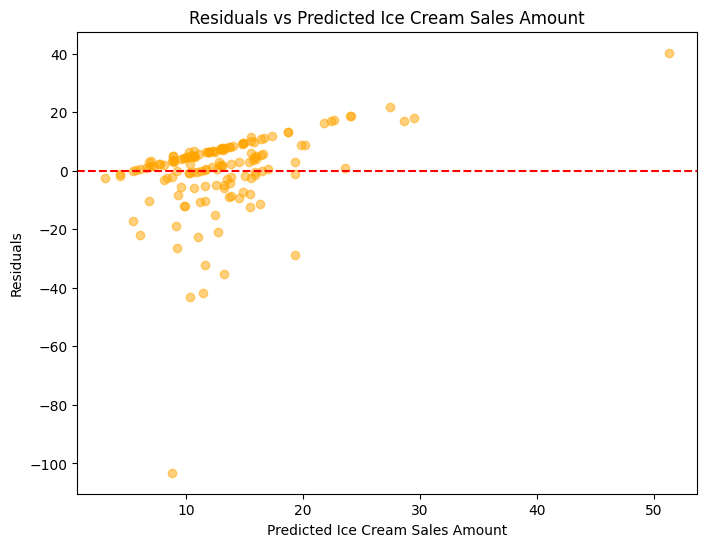

In [170]:
# Filter the data for Ice Cream sales
ice_cream_sales = sales_weather_data[sales_weather_data['SD'] == 'Ice Cream']

# Sort the data by 'AMOUNT' in descending order
top_ice_cream_sales = ice_cream_sales.sort_values(by='AMOUNT', ascending=False)
print("Top Ice Cream sales data:")
print(top_ice_cream_sales.head())


# Display the top days with the highest Ice Cream amounts
print("Top days with the highest Ice Cream amounts:")
print(top_ice_cream_sales[['date', 'AMOUNT']].head())

# Run XGBoost to determine if weather affects Ice Cream sales
# Prepare the features (weather data) and target (sales amount)
X = ice_cream_sales[['temp_max', 'temp_min', 'precipitation']]
y = ice_cream_sales['AMOUNT']

# Scale the data usign standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Create an XGBoost Regressor model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("XGBoost Model Evaluation:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Mean Absolute Error (MAE):", mae)

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='orange')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importances (Ice Cream Sales)")
plt.show()

# Plot the predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='orange', alpha=0.5)
plt.xlabel("Actual Ice Cream Sales Amount")
plt.ylabel("Predicted Ice Cream Sales Amount")
plt.title("Predicted vs Actual Ice Cream Sales Amount")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()
# Plot the residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_pred - y_test, color='orange', alpha=0.5)
plt.xlabel("Predicted Ice Cream Sales Amount")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Ice Cream Sales Amount")
plt.axhline(0, color='red', linestyle='--')
plt.show()

